In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [215]:
#obsolete
def convert2aafile(infile):
    inhandle = open(infile)
    header = inhandle.readline()
    outfile = open(infile.replace('result_nuc_',''),'w')
    liblist = header.rstrip().rsplit('\t')[6:]
    outfile.write('Loop1\tLoop2\t'+'\t'.join(liblist)+'\n')
    aadict = {}
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        aa = line[2]+'_'+line[3]
        if aa not in aadict:
            aadict[aa] = {}
            for lib in liblist:
                aadict[aa][lib] = 0
        for i,count in enumerate(line[6:]):
            aadict[aa][liblist[i]] += float(count)
    for aa in aadict:
        outfile.write('\t'.join(aa.rsplit('_')))
        for lib in liblist:
            outfile.write('\t'+str(aadict[aa][lib]))
        outfile.write('\n')
    outfile.close()
    inhandle.close()
#convert2aafile('../result/result_nuc_display_readcount_Fn22_2loop.txt')

In [14]:
#obsolete, use pandas to read csv
def readcount(infile):
    countdict = {}
    header = infile.readline().rstrip().rsplit('\t')
    liblist = header[2:]
    for line in infile:
        line = line.rstrip().rsplit('\t')
        muts = line[0]+'_'+line[1]
        countdict[muts] = {}
        for i in range(len(liblist)):
            countdict[muts][liblist[i]] = float(line[i+2])
    infile.close()
    return countdict

In [3]:
countdict = {}
explist = ['Fn22_1loop','Fn17_1loop','Fn22_2loop','Fn17_2loop']
liblist = ['Input','N-lysate','NP-lysate','N-purified','preclear']
for exp in explist:
    countdict[exp] = pd.read_csv('../result/display_readcount_'+exp+'.txt',sep='\t')

In [4]:
countdict['Fn22_1loop']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear
0       PNLFSKV  KRSFWSISVQ      1         0          0           0         0
1       PNLWFAV  KRRLGSNSAG      0         0          0           0         1
2       PNLWYKV  RPSFWSRVAG      0         0          0           0         1
3       PNLWFQV  KTLFWSNYVG      0         0          0           0         1
4       PMPWYKV  KRSFWAGSAG      0         0          0           0         1
...         ...         ...    ...       ...        ...         ...       ...
214871  PNMWYKV  KRSFWSNSGQ      0         0          0           0         1
214872  PNLWG*V  KRSFWSPKAG      1         0          0           0         0
214873  TYLWYKV  KRSFPRNSAG      0         0          0           0         1
214874  PNLWYKV  *FSFWSNSFG      1         0          0           0         0
214875  PNLWTHV  K**FWSNVNG      2         0          0           0         0

[214876 rows x 7 columns]

In [5]:
for exp in countdict:
    print(exp+' mutant types:'+str(len(countdict[exp])))

Fn22_1loop mutant types:214876
Fn17_1loop mutant types:294098
Fn22_2loop mutant types:11184811
Fn17_2loop mutant types:11776033


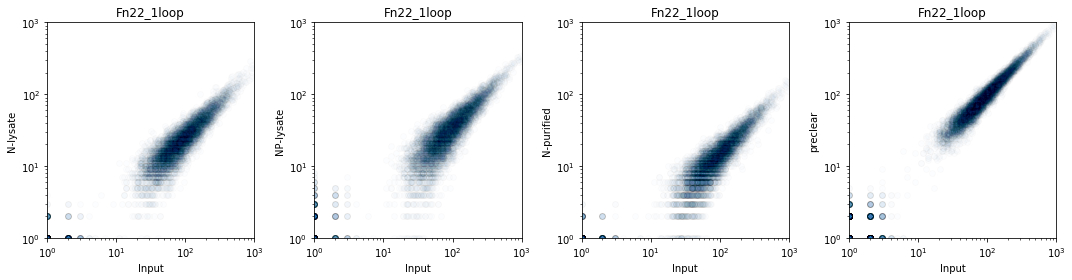

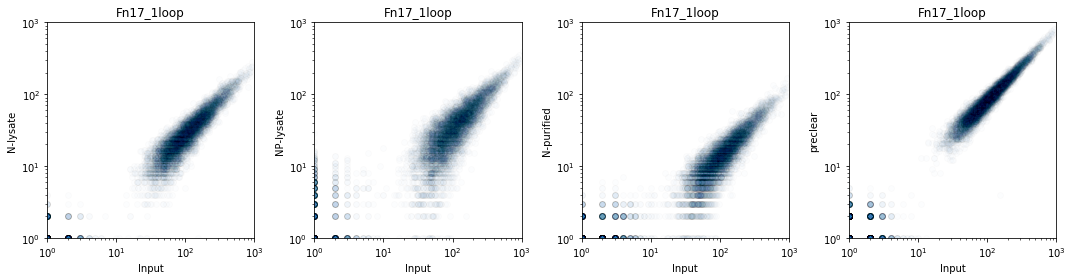

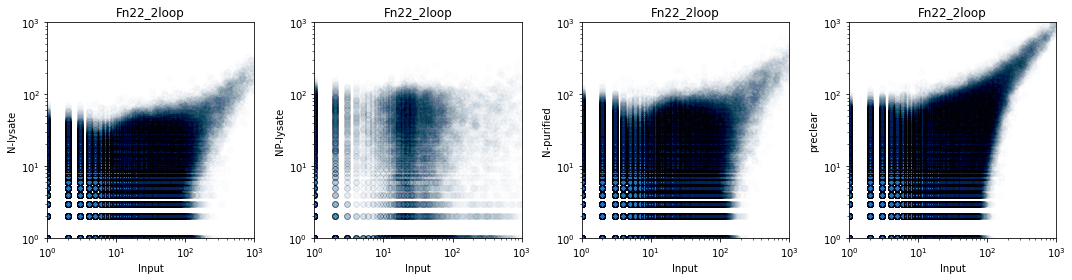

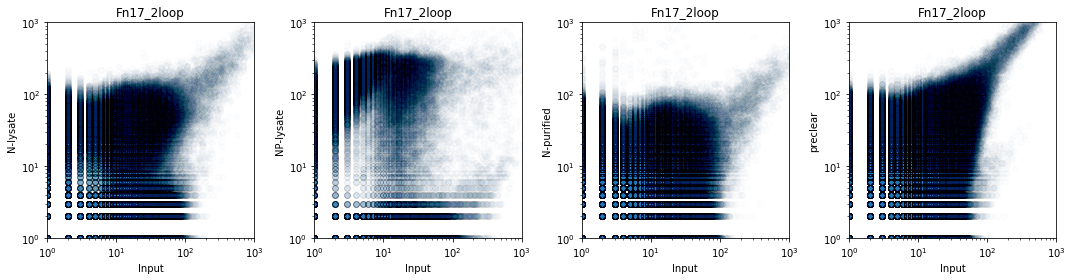

In [11]:
for exp in explist:
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter(countdict[exp]['Input'],countdict[exp][lib],alpha=0.01,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1,1e3])
        plt.ylim([1,1e3])
        plt.xlabel('Input')
        plt.ylabel(lib)
        plt.title(exp)
    plt.tight_layout()

In [6]:
depth = {}
for exp in explist:
    depth[exp] = {}
    for lib in liblist:
        depth[exp][lib] = sum(countdict[exp][lib])
        countdict[exp][lib+'_freq'] = countdict[exp][lib]/depth[exp][lib]

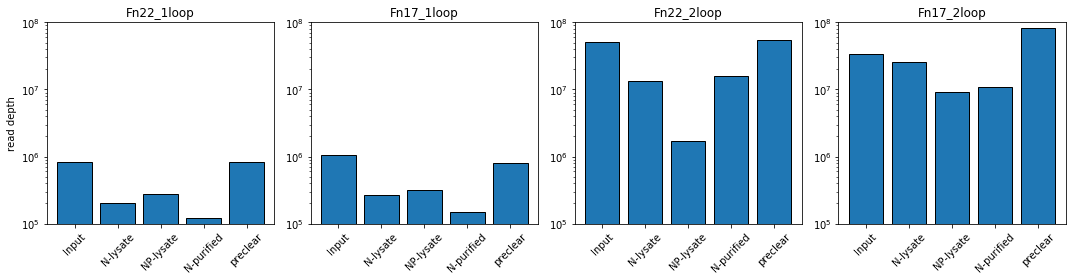

In [29]:
plt.figure(figsize=(15,4))
ploti = 0
for exp in explist:
    ploti += 1
    plt.subplot(1,4,ploti)
    ylist = []
    for lib in liblist:
        ylist.append(depth[exp][lib])
    plt.bar(range(len(liblist)),ylist,edgecolor='black')
    plt.xticks(range(len(liblist)),liblist,rotation=45)
    if ploti == 1: plt.ylabel('read depth')
    plt.title(exp)
    plt.ylim([1e5,1e8])
    plt.yscale('log')
plt.tight_layout()

In [516]:
depth

{'Fn22_1loop': {'Input': 817833,
  'N-lysate': 203548,
  'NP-lysate': 271260,
  'N-purified': 122735,
  'preclear': 831578},
 'Fn17_1loop': {'Input': 1037661,
  'N-lysate': 263703,
  'NP-lysate': 316834,
  'N-purified': 149103,
  'preclear': 800163},
 'Fn22_2loop': {'Input': 50899947.0,
  'N-lysate': 13383023.0,
  'NP-lysate': 1690758.0,
  'N-purified': 15772231.0,
  'preclear': 55537287.0},
 'Fn17_2loop': {'Input': 33679203,
  'N-lysate': 25778355,
  'NP-lysate': 9059771,
  'N-purified': 10700008,
  'preclear': 81448094}}

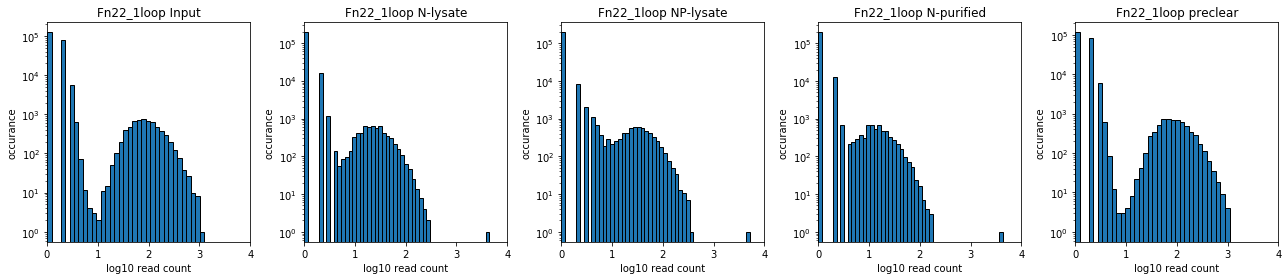

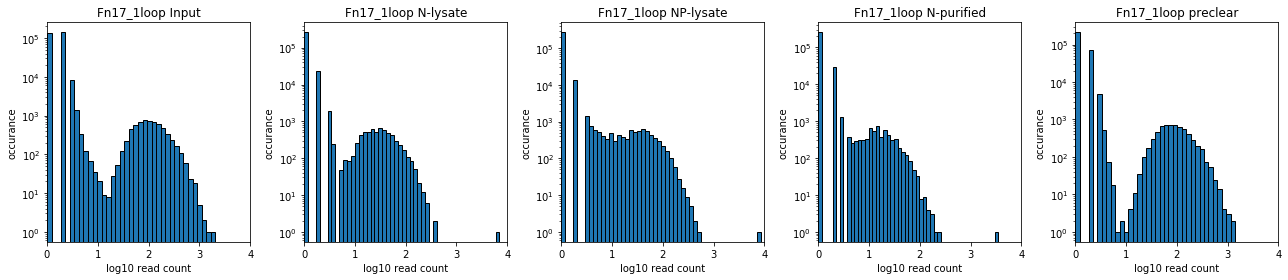

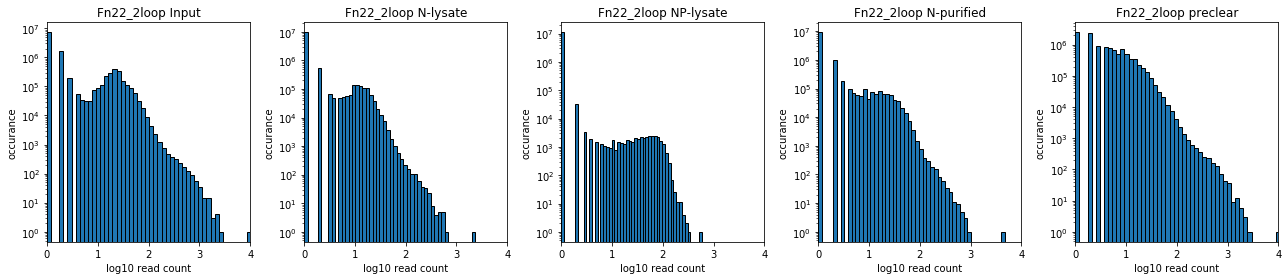

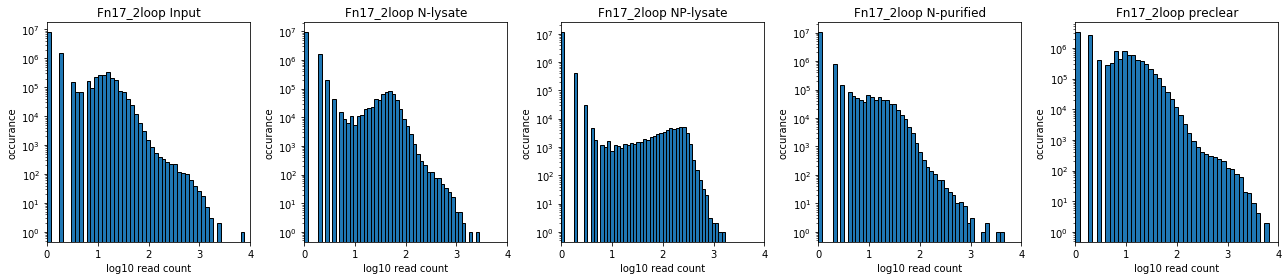

In [17]:
for exp in explist:
    plt.figure(figsize=(18,4))
    ploti = 0
    for lib in liblist:
        ploti += 1
        plt.subplot(1,5,ploti)
        plt.hist(np.log10(countdict[exp][lib]+1),bins=50,edgecolor='black')
        plt.title(exp + ' '+ lib)
        plt.ylabel('occurance')
        plt.xlabel('log10 read count')
        plt.xlim([0,4])
        plt.yscale('log')
    plt.tight_layout()

In [456]:
for exp in explist:
    if 'Fn17' in exp: refseq = refdict['Fn22']
    if 'Fn22' in exp: refseq = refdict['Fn17']
    fdata[exp]['cross_contamination'] = fdata[exp]['seq'].apply(lambda x: hamming(x,refseq)<=4)

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if __name__ == '__main__':
/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


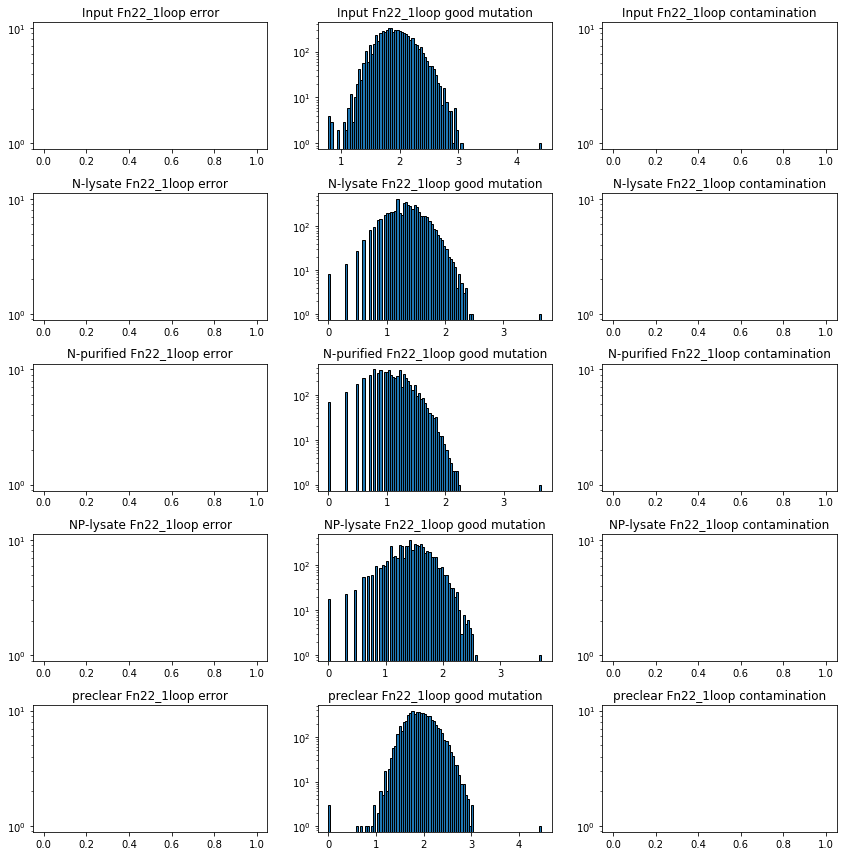

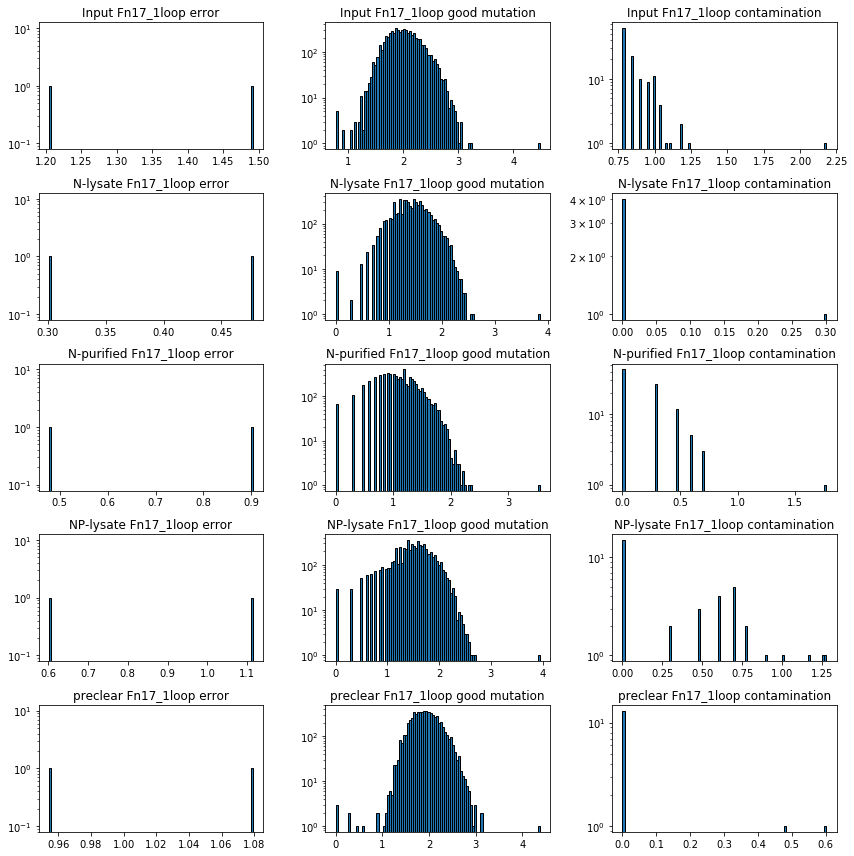

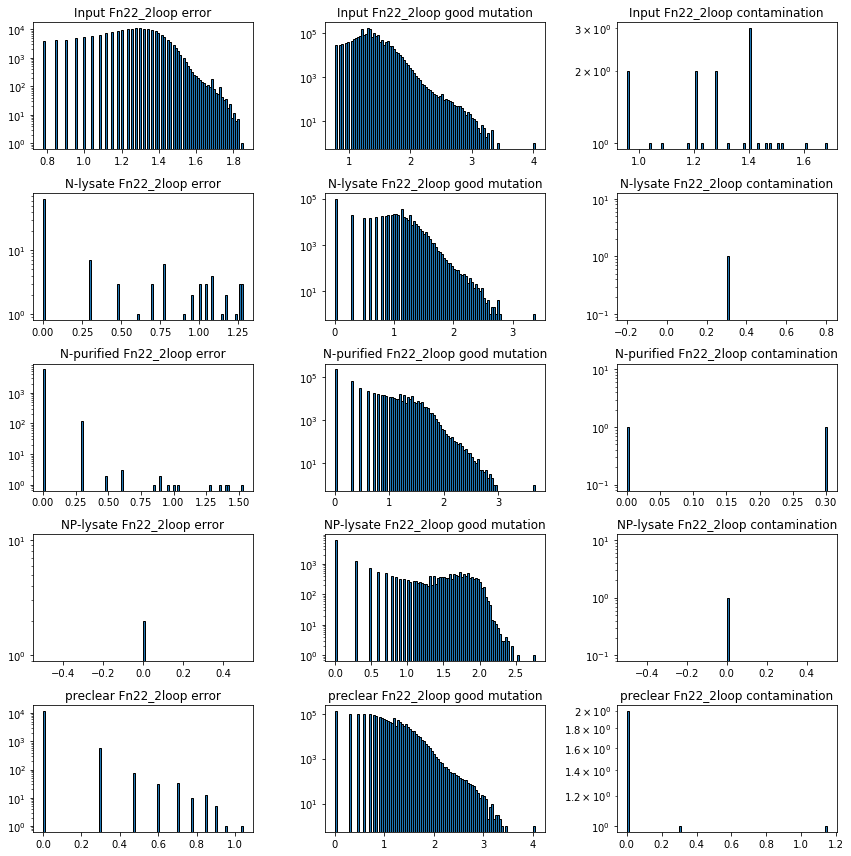

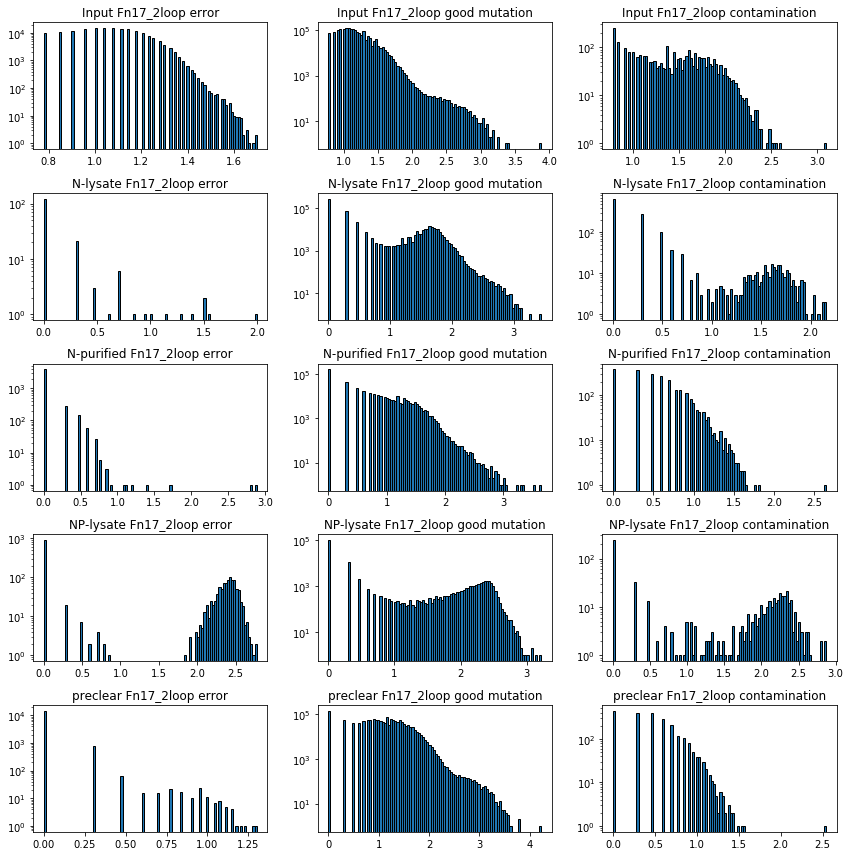

In [461]:
#readcount distribution
#errors
for exp in explist:
    plt.figure(figsize=(12,12))
    ploti = 0
    for lib in liblist:
        ploti += 1
        plt.subplot(5,3,ploti)
        plt.hist(np.log10(fdata[exp][(fdata[exp][lib]>0) & (fdata[exp]['mutpos'].apply(lambda x:len(x)>4)) & (fdata[exp]['cross_contamination']==False)][lib]),bins=100,edgecolor='black')
        plt.title(lib+' '+exp+' error')
        plt.yscale('log')
        ploti += 1
        plt.subplot(5,3,ploti)
        plt.hist(np.log10(fdata[exp][(fdata[exp][lib]>0) & (fdata[exp]['mutpos'].apply(lambda x:len(x)<=4))][lib]),bins=100,edgecolor='black')
        plt.title(lib+' '+exp+' good mutation')
        plt.yscale('log')
        ploti += 1
        plt.subplot(5,3,ploti)
        plt.hist(np.log10(fdata[exp][(fdata[exp][lib]>0) & (fdata[exp]['mutpos'].apply(lambda x:len(x)>4)) & (fdata[exp]['cross_contamination']==True)][lib]),bins=100,edgecolor='black')
        plt.title(lib+' '+exp+' contamination')
        plt.yscale('log')
    plt.tight_layout()
        

In [459]:
fdata[exp][(fdata[exp]['cross_contamination']==False) & (fdata[exp]['mutpos'].apply(lambda x:len(x)>4))]

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
12        PANYYAR  TRLRLCYMWQ      9         0          0           0   
30        *SNYYNG  TRWRFEQMWQ      8         0          0           0   
45        LKNYYNI  W*WRLYQMSI     16         0          0           0   
130       PDNYYSC  TRWRLPSMWQ     10         0          0           0   
302       PANY*LI  TTRRLYG*WQ     12         0          0           0   
...           ...         ...    ...       ...        ...         ...   
11775954  PANYRPI  TRWPEFQMWQ      9         0          0           0   
11775963  PANWTNI  TRQDLYRMWQ      9         0          0           0   
11775974  PFGYYNI  TRLGLYLMWQ     12         0          0           0   
11775999  PANYRVI  FPWRLYKPWQ     17         0          0           0   
11776031  PA*WYNI  WWWRLYQY*Q     11         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
12               0  2.672272e-07            0.0             0.0   
30               0  2.375353e-07            0.0             0.0   
45               0  4.750706e-07            0.0             0.0   
130              0  2.969191e-07            0.0             0.0   
302              0  3.563030e-07            0.0             0.0   
...            ...           ...            ...             ...   
11775954         1  2.672272e-07            0.0             0.0   
11775963         0  2.672272e-07            0.0             0.0   
11775974         0  3.563030e-07            0.0             0.0   
11775999         0  5.047625e-07            0.0             0.0   
11776031         0  3.266111e-07            0.0             0.0   

          N-purified_freq  preclear_freq  N-lysate_enrich  NP-lysate_enrich  \
12                    0.0   0.000000e+00              0.0               0.0   
30                    0.0   0.000000e+00              0.0               0.0   
45                    0.0   0.000000e+00              0.0               0.0   
130                   0.0   0.000000e+00              0.0               0.0   
302                   0.0   0.000000e+00              0.0               0.0   
...                   ...            ...              ...               ...   
11775954              0.0   1.227776e-08              0.0               0.0   
11775963              0.0   0.000000e+00              0.0               0.0   
11775974              0.0   0.000000e+00              0.0               0.0   
11775999              0.0   0.000000e+00              0.0               0.0   
11776031              0.0   0.000000e+00              0.0               0.0   

          N-purified_enrich  preclear_enrich                 seq  \
12                      0.0         0.000000  PANYYAR_TRLRLCYMWQ   
30                      0.0         0.000000  *SNYYNG_TRWRFEQMWQ   
45                      0.0         0.000000  LKNYYNI_W*WRLYQMSI   
130                     0.0         0.000000  PDNYYSC_TRWRLPSMWQ   
302                     0.0         0.000000  PANY*LI_TTRRLYG*WQ   
...                     ...              ...                 ...   
11775954                0.0         0.050188  PANYRPI_TRWPEFQMWQ   
11775963                0.0         0.000000  PANWTNI_TRQDLYRMWQ   
11775974                0.0         0.000000  PFGYYNI_TRLGLYLMWQ   
11775999                0.0         0.000000  PANYRVI_FPWRLYKPWQ   
11776031                0.0         0.000000  PA*WYNI_WWWRLYQY*Q   

                         mutpos  cross_contamination  
12           [5, 6, 10, 13, 14]                False  
30            [0, 1, 6, 12, 13]                False  
45         [0, 1, 8, 9, 16, 17]                False  
130           [1, 5, 6, 13, 14]                False  
302       [4, 5, 9, 10, 14, 15]                False  
...                         ...                  ...  
11775954     [4, 5, 11, 12, 13]                False  
11775963     [3, 4, 10, 11, 14]                False  
11775974     [1, 2, 10, 11, 14]                False  
11775999   [4,

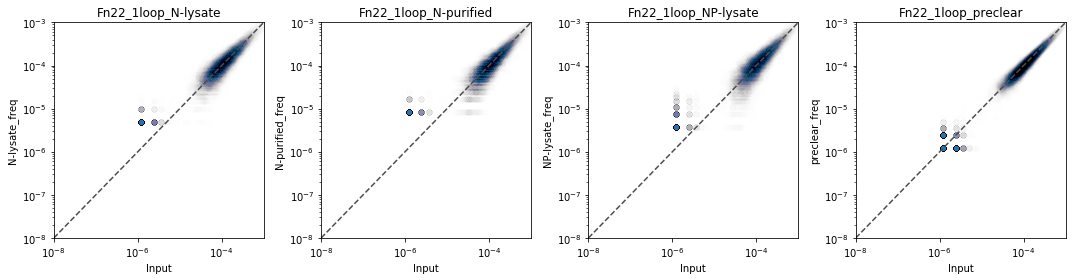

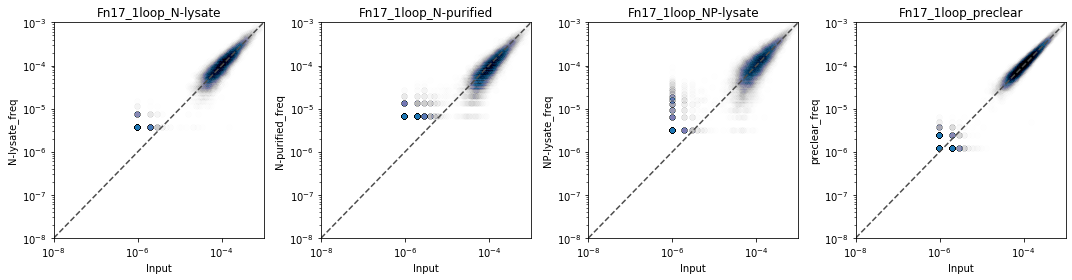

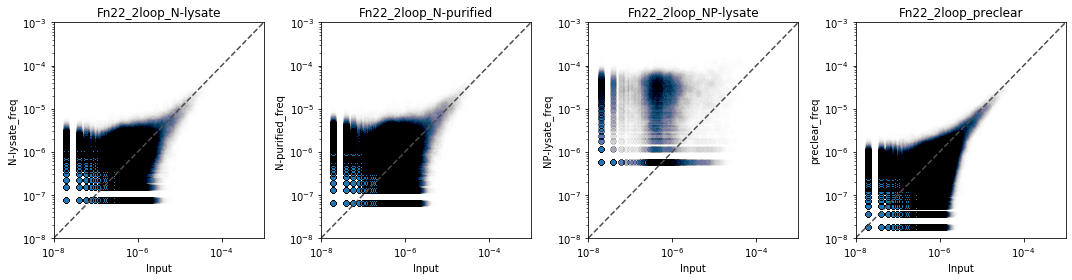

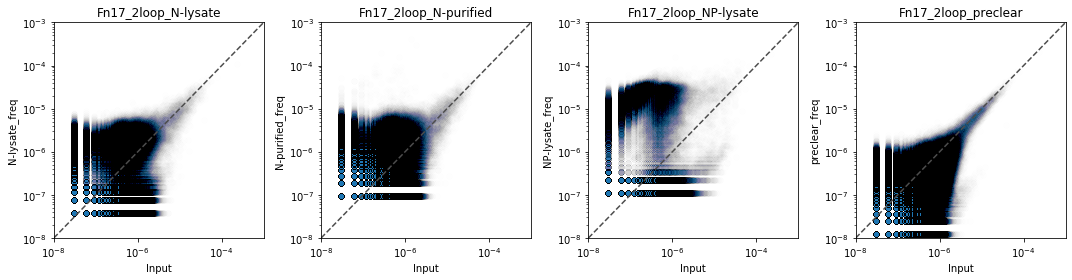

In [462]:
def freq_cor(exp):
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter(countdict[exp]['Input_freq'],countdict[exp][lib+'_freq'],alpha=0.002,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-8,1e-3])
        plt.ylim([1e-8,1e-3])
        plt.xlabel('Input')
        plt.ylabel(lib+'_freq')
        plt.title(exp+'_'+lib)
        plt.plot([1e-8, 1e-3], [1e-8, 1e-3], ls="--", c=".3")
    plt.tight_layout()

    
for exp in explist:
    freq_cor(exp)

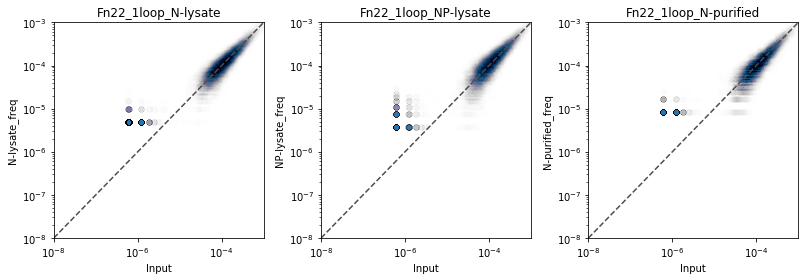

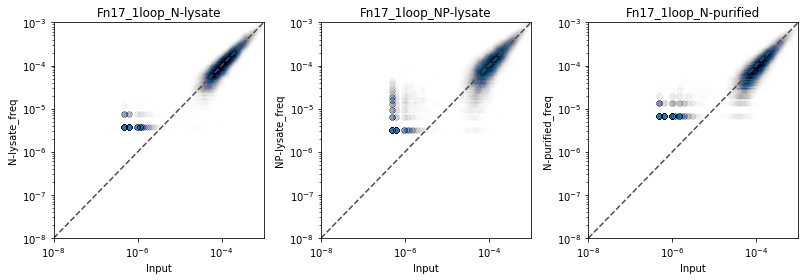

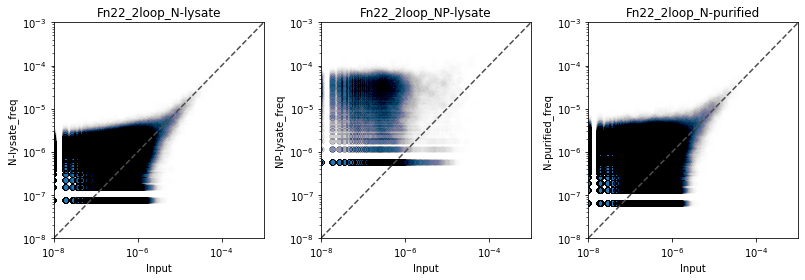

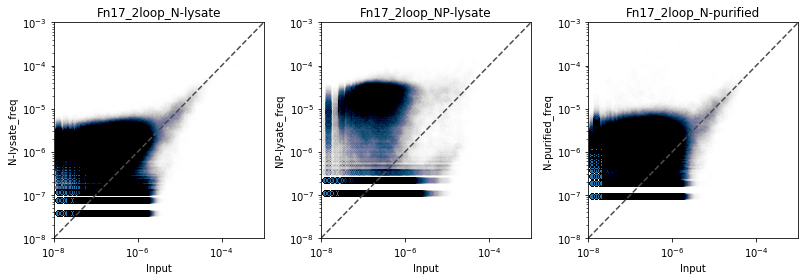

In [77]:
def freq_cor(exp):
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter((countdict[exp]['Input_freq']+countdict[exp]['preclear_freq'])/2,countdict[exp][lib+'_freq'],alpha=0.002,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-8,1e-3])
        plt.ylim([1e-8,1e-3])
        plt.xlabel('Input')
        plt.ylabel(lib+'_freq')
        plt.title(exp+'_'+lib)
        plt.plot([1e-8, 1e-3], [1e-8, 1e-3], ls="--", c=".3")
    plt.tight_layout()

    
for exp in explist:
    freq_cor(exp)

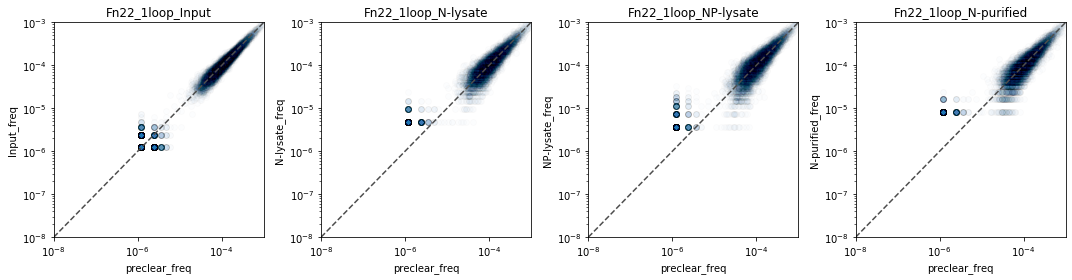

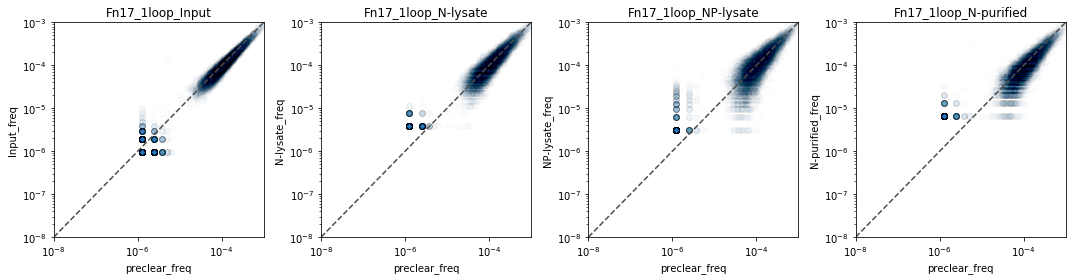

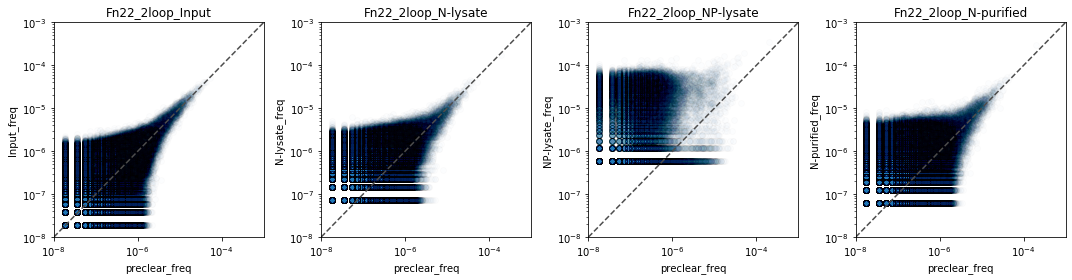

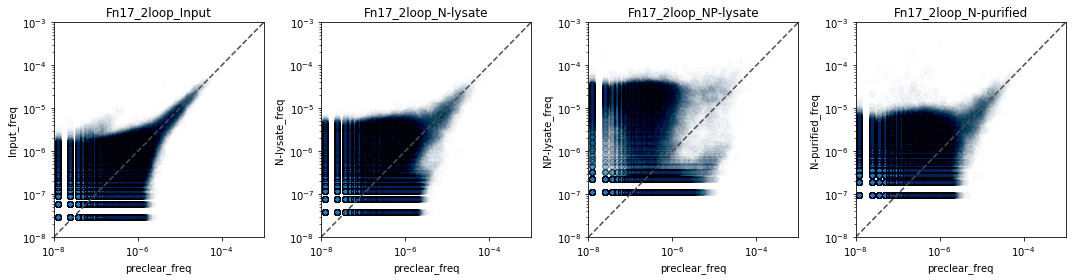

In [22]:
def freq_cor(exp):
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[:4]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter(countdict[exp]['preclear_freq'],countdict[exp][lib+'_freq'],alpha=0.01,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-8,1e-3])
        plt.ylim([1e-8,1e-3])
        plt.xlabel('preclear_freq')
        plt.ylabel(lib+'_freq')
        plt.title(exp+'_'+lib)
        plt.plot([1e-8, 1e-3], [1e-8, 1e-3], ls="--", c=".3")
    plt.tight_layout()

    
for exp in explist:
    freq_cor(exp)

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


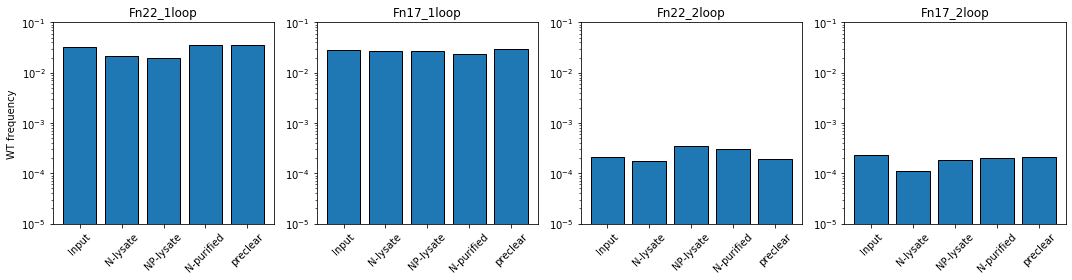

In [63]:
refdict = {'Fn22':'PNLWYKV_KRSFWSNSAG', 'Fn17':'PANYYNI_TRWRLYQMWQ'}
fdata = {}; wtfreq = {}; mdata={}
for exp in explist:
    wtfreq[exp] = {}
    fdata[exp] = countdict[exp][countdict[exp]['Input']>5]
   # fdata[exp] = mdata[exp][mdata[exp]['mutpos'].apply(lambda x:len(x)<=6)]  #Filter out the multi-mutations and potential cross-lib contamination
    aa = refdict[exp.rsplit('_')[0]]
    aa1 = aa.rsplit('_')[0]
    aa2 = aa.rsplit('_')[1]
    for lib in liblist:
        wtrecord = fdata[exp][(fdata[exp]['Loop1']==aa1) & (fdata[exp]['Loop2']==aa2)]
        wtfreq[exp][lib+'_freq'] = float(wtrecord[lib+'_freq'])
    for lib in liblist[1:]:
        fdata[exp][lib+'_enrich'] = (fdata[exp][lib+'_freq']/fdata[exp]['Input_freq'])/(wtfreq[exp][lib+'_freq']/wtfreq[exp]['Input_freq'])
    for lib in liblist[1:-1]:
        fdata[exp][lib+'_enrich2'] = (fdata[exp][lib+'_freq']/(fdata[exp]['Input_freq']+fdata[exp]['preclear_freq']))/(wtfreq[exp][lib+'_freq']/(wtfreq[exp]['Input_freq']+wtfreq[exp]['preclear_freq']))
plt.figure(figsize=(15,4))
ploti = 0
for exp in explist:
    ploti += 1
    plt.subplot(1,4,ploti)
    ylist = []
    for lib in liblist:
        ylist.append(wtfreq[exp][lib+'_freq'])
    plt.bar(range(len(liblist)),ylist,edgecolor='black')
    plt.xticks(range(len(liblist)),liblist,rotation=45)
    if ploti == 1: plt.ylabel('WT frequency')
    plt.title(exp)
    plt.ylim([1e-5,1e-1])
    plt.yscale('log')
plt.tight_layout()

In [8]:
refdict = {'Fn22':'PNLWYKV_KRSFWSNSAG', 'Fn17':'PANYYNI_TRWRLYQMWQ'}
mdata={}
for exp in explist:
    wtfreq[exp] = {}
    mdata[exp] = countdict[exp][countdict[exp]['Input']>5]
mdata

{'Fn22_1loop':           Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
 17      PNLWYKV  KRSFWLWSAG    160        48         49          23       144   
 28      PRKWYKV  KRSFWSNSAG    109        30         55          17       139   
 58      PNLWYKV  QHSFWSNSAG     40         8         12           6        38   
 100     PNLWYKV  KRSFWSRFAG     73        21         28          15        84   
 171     PNLMWKV  KRSFWSNSAG     89        10         27           4        83   
 ...         ...         ...    ...       ...        ...         ...       ...   
 214499  PNLWYKV  KRPSWSNSAG     93        49         42          17       119   
 214513  PNLWYKV  YWSFWSNSAG     40        14         25           6        41   
 214642  PNLWYKV  FPSFWSNSAG     97        27         39          18        84   
 214665  PNLWYKV  KRSFWSNAKG     71        17         28          14        70   
 214801  PAYWYKV  KRSFWSNSAG     71        20         21           6       101   
 


In [12]:
fdata['Fn17_2loop'].sort_values(by='N-lysate_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
9758134   PFLYYNI  TRWRLYQASQ      6       221          0          10   
6134414   PANYSLI  TRWLRYQMWQ      6       216          1           2   
9429394   PSSYYNI  TRWRLYQMTK      6       162          1          16   
10413123  PLLYYNI  TRWREAQMWQ      8       216          0           8   
3545663   PANRSNI  TRWRMIQMWQ      6       157          0           0   
...           ...         ...    ...       ...        ...         ...   
4597660   PANYANI  TRWRLHQMWQ     11         0          0           0   
4597620   PANYMCI  TRWRTVQMWQ     11         0          0           0   
4597619   FDNYYNI  TRWRDYQMWQ      8         0          0           0   
4597603   PANEMNI  TRWRLWLMWQ     13         0          1           0   
11776031  PA*WYNI  WWWRLYQY*Q     11         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
9758134         66  1.781515e-07       0.000009    0.000000e+00   
6134414         89  1.781515e-07       0.000008    1.103781e-07   
9429394         53  1.781515e-07       0.000006    1.103781e-07   
10413123       103  2.375353e-07       0.000008    0.000000e+00   
3545663         17  1.781515e-07       0.000006    0.000000e+00   
...            ...           ...            ...             ...   
4597660          6  3.266111e-07       0.000000    0.000000e+00   
4597620          0  3.266111e-07       0.000000    0.000000e+00   
4597619          5  2.375353e-07       0.000000    0.000000e+00   
4597603          5  3.859949e-07       0.000000    1.103781e-07   
11776031         0  3.266111e-07       0.000000    0.000000e+00   

          N-purified_freq  preclear_freq  N-lysate_enrich  NP-lysate_enrich  \
9758134      9.345787e-07   8.103320e-07       100.497338          0.000000   
6134414      1.869157e-07   1.092720e-06        98.223642          0.767525   
9429394      1.495326e-06   6.507212e-07        73.667732          0.767525   
10413123     7.476630e-07   1.264609e-06        73.667732          0.000000   
3545663      0.000000e+00   2.087219e-07        71.394036          0.000000   
...                   ...            ...              ...               ...   
4597660      0.000000e+00   7.366655e-08         0.000000          0.000000   
4597620      0.000000e+00   0.000000e+00         0.000000          0.000000   
4597619      0.000000e+00   6.138879e-08         0.000000          0.000000   
4597603      0.000000e+00   6.138879e-08         0.000000          0.354243   
11776031     0.000000e+00   0.000000e+00         0.000000          0.000000   

          N-purified_enrich  preclear_enrich  
9758134            6.062470         4.968618  
6134414            1.212494         6.700106  
9429394            9.699953         3.989951  
10413123           3.637482         5.815541  
3545663            0.000000         1.279795  
...                     ...              ...  
4597660            0.000000         0.246378  
4597620            0.000000         0.000000  
4597619            0.000000         0.282308  
4597603            0.000000         0.173728  
11776031           0.000000         0.000000  

[1912883 rows x 16 columns]

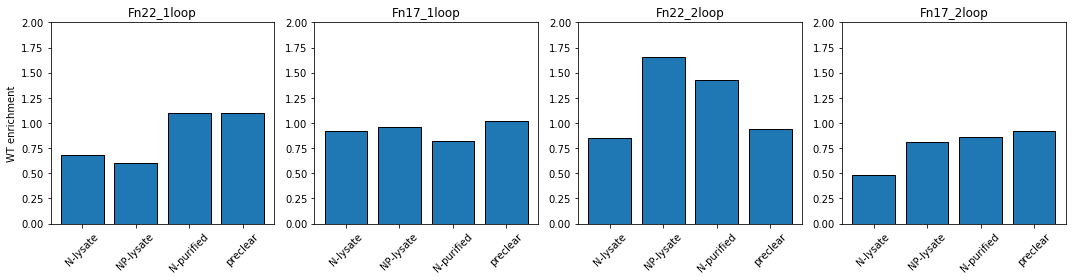

In [46]:
plt.figure(figsize=(15,4))
ploti = 0
for exp in explist:
    ploti += 1
    plt.subplot(1,4,ploti)
    ylist = []
    for lib in liblist[1:]:
        ylist.append(wtfreq[exp][lib+'_freq']/wtfreq[exp]['Input_freq'])
    plt.bar(range(len(liblist)-1),ylist,edgecolor='black')
    plt.xticks(range(len(liblist)-1),liblist[1:],rotation=45)
    if ploti == 1: plt.ylabel('WT enrichment')
    plt.title(exp)
    plt.ylim([0,2])
plt.tight_layout()

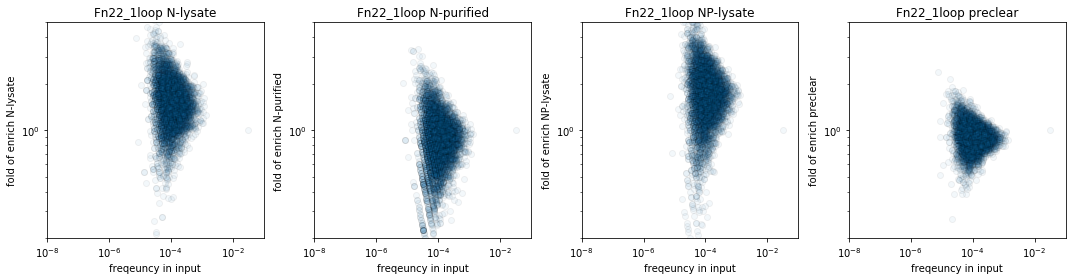

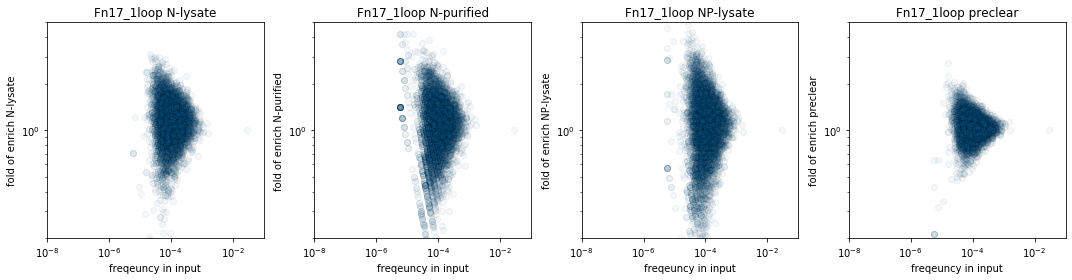

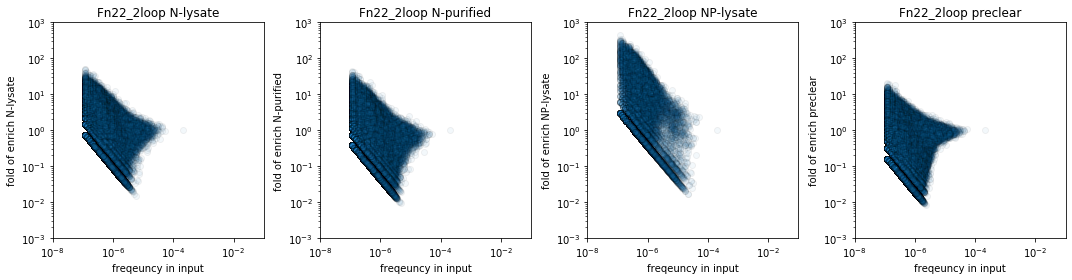

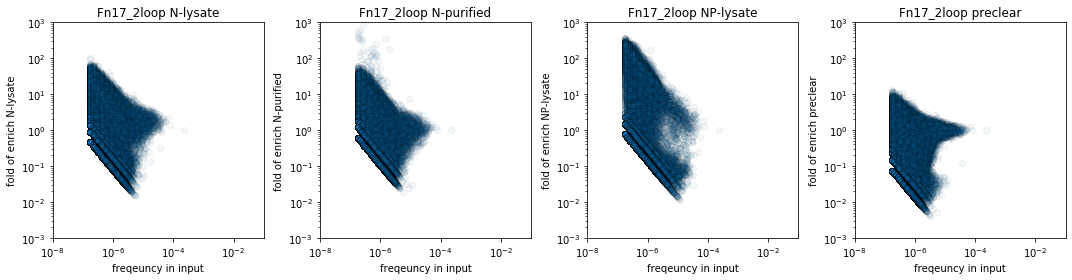

In [503]:
for exp in explist:
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter(fdata[exp]['Input_freq'],fdata[exp][lib+'_enrich'],alpha=0.05,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-8,1e-1])
        if '1loop' in exp: 
            plt.ylim([0.2,5])
        else:
            plt.ylim([1e-3,1e3])
        plt.title(exp+' '+lib)
        plt.xlabel('freqeuncy in input')
        plt.ylabel('fold of enrich '+lib)
    plt.tight_layout()
    plt.savefig('frequency2enrichment_'+exp+'.png')


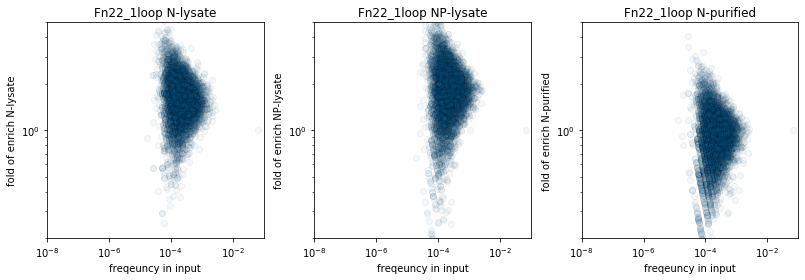

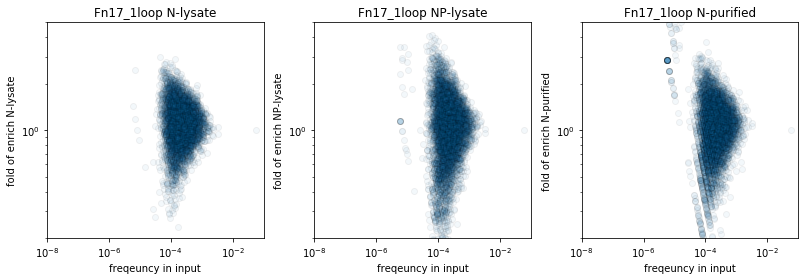

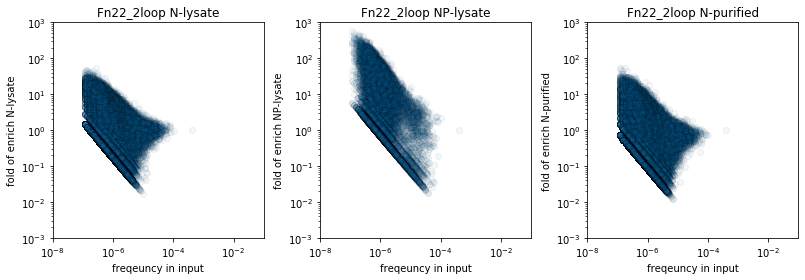

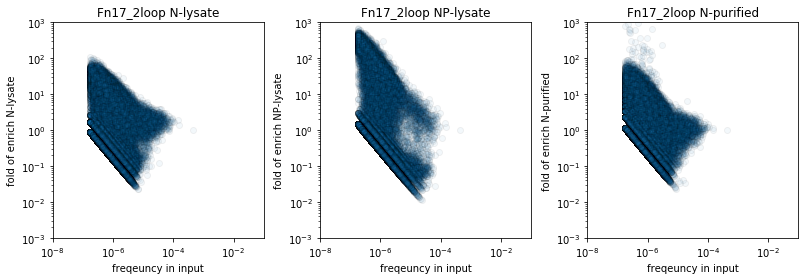

In [76]:
for exp in explist:
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(1,4,ploti)
        plt.scatter(fdata[exp]['Input_freq']+fdata[exp]['preclear_freq'],fdata[exp][lib+'_enrich2'],alpha=0.05,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-8,1e-1])
        if '1loop' in exp: 
            plt.ylim([0.2,5])
        else:
            plt.ylim([1e-3,1e3])
        plt.title(exp+' '+lib)
        plt.xlabel('freqeuncy in input')
        plt.ylabel('fold of enrich '+lib)
    plt.tight_layout()
    plt.savefig('frequency2enrichment2_'+exp+'.png')


In [152]:
fdata['Fn17_1loop'].sort_values(by='N-purified_enrich',ascending=False)
#'Fn22':'PNLWYKV_KRSFWSNSAG'
#'Fn17':'PANYYNI_TRWRLYQMWQ'

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
266177  PNLWYLF  KRSFWSNSAG      7         0          6           5         0   
290652  PNLWYKV  KLSFWSNSAG      6         0          0           4         0   
250824  PLLWYKV  KRSFWSNSAG     10         0          4           5         0   
99363   ILLWYKV  KRSFWSNSAG      6         0          0           3         0   
95231   PNLWYKV  KRSFLSNSAG      6         0          0           3         0   
...         ...         ...    ...       ...        ...         ...       ...   
137120  P*LWYKV  KRSFWSNSAG      6         0          0           0         0   
34029   PANYYNI  TRENLYQMWQ     14         3          3           0        21   
147346  PNLWYKV  LMSFWSNSAG      6         0          0           0         0   
175631  STLWYKV  KRSFWSNSAG      9         0          0           0         0   
53226   PNLWYKV  KRSFWSYSAG      6         0          1           0         0   

        Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
266177    0.000007       0.000000        0.000019         0.000034   
290652    0.000006       0.000000        0.000000         0.000027   
250824    0.000010       0.000000        0.000013         0.000034   
99363     0.000006       0.000000        0.000000         0.000020   
95231     0.000006       0.000000        0.000000         0.000020   
...            ...            ...             ...              ...   
137120    0.000006       0.000000        0.000000         0.000000   
34029     0.000013       0.000011        0.000009         0.000000   
147346    0.000006       0.000000        0.000000         0.000000   
175631    0.000009       0.000000        0.000000         0.000000   
53226     0.000006       0.000000        0.000003         0.000000   

        preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
266177       0.000000         0.000000          2.936306           6.028878   
290652       0.000000         0.000000          0.000000           5.626953   
250824       0.000000         0.000000          1.370276           4.220215   
99363        0.000000         0.000000          0.000000           4.220215   
95231        0.000000         0.000000          0.000000           4.220215   
...               ...              ...               ...                ...   
137120       0.000000         0.000000          0.000000           0.000000   
34029        0.000026         0.913617          0.734077           0.000000   
147346       0.000000         0.000000          0.000000           0.000000   
175631       0.000000         0.000000          0.000000           0.000000   
53226        0.000000         0.000000          0.570948           0.000000   

        preclear_enrich                 seq  \
266177         0.000000  PNLWYLF_KRSFWSNSAG   
290652         0.000000  PNLWYKV_KLSFWSNSAG   
250824         0.000000  PLLWYKV_KRSFWSNSAG   
99363          0.000000  ILLWYKV_KRSFWSNSAG   
95231          0.000000  PNLWYKV_KRSFLSNSAG   
...                 ...                 ...   
137120         0.000000  P*LWYKV_KRSFWSNSAG   
34029          1.913793  PANYYNI_TRENLYQMWQ   
147346         0.000000  PNLWYKV_LMSFWSNSAG   
175631         0.000000  STLWYKV_KRSFWSNSAG   
53226          0.000000  PNLWYKV_KRSFWSYSAG   

                                                   mutpos  
266177  [1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16,...  
290652  [1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...  
250824  [1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16,...  
99363   [0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, ...  
95231      [1, 2, 3, 5, 6, 8, 10, 11, 13, 14, 15, 16, 17]  
...                                                   ...  
137120  [1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16,...  
34029                                            [10, 11]  
147346  [1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...  
175631  [0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, ...  
53226   [1, 2, 3, 5, 6

In [70]:
fdata['Fn17_2loop'].sort_values(by='N-lysate_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
9758134   PFLYYNI  TRWRLYQASQ      6       221          0          10   
6134414   PANYSLI  TRWLRYQMWQ      6       216          1           2   
9429394   PSSYYNI  TRWRLYQMTK      6       162          1          16   
10413123  PLLYYNI  TRWREAQMWQ      8       216          0           8   
3545663   PANRSNI  TRWRMIQMWQ      6       157          0           0   
...           ...         ...    ...       ...        ...         ...   
4597660   PANYANI  TRWRLHQMWQ     11         0          0           0   
4597620   PANYMCI  TRWRTVQMWQ     11         0          0           0   
4597619   FDNYYNI  TRWRDYQMWQ      8         0          0           0   
4597603   PANEMNI  TRWRLWLMWQ     13         0          1           0   
11776031  PA*WYNI  WWWRLYQY*Q     11         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
9758134         66  1.781515e-07       0.000009    0.000000e+00   
6134414         89  1.781515e-07       0.000008    1.103781e-07   
9429394         53  1.781515e-07       0.000006    1.103781e-07   
10413123       103  2.375353e-07       0.000008    0.000000e+00   
3545663         17  1.781515e-07       0.000006    0.000000e+00   
...            ...           ...            ...             ...   
4597660          6  3.266111e-07       0.000000    0.000000e+00   
4597620          0  3.266111e-07       0.000000    0.000000e+00   
4597619          5  2.375353e-07       0.000000    0.000000e+00   
4597603          5  3.859949e-07       0.000000    1.103781e-07   
11776031         0  3.266111e-07       0.000000    0.000000e+00   

          N-purified_freq  preclear_freq  N-lysate_enrich  NP-lysate_enrich  \
9758134      9.345787e-07   8.103320e-07       100.497338          0.000000   
6134414      1.869157e-07   1.092720e-06        98.223642          0.767525   
9429394      1.495326e-06   6.507212e-07        73.667732          0.767525   
10413123     7.476630e-07   1.264609e-06        73.667732          0.000000   
3545663      0.000000e+00   2.087219e-07        71.394036          0.000000   
...                   ...            ...              ...               ...   
4597660      0.000000e+00   7.366655e-08         0.000000          0.000000   
4597620      0.000000e+00   0.000000e+00         0.000000          0.000000   
4597619      0.000000e+00   6.138879e-08         0.000000          0.000000   
4597603      0.000000e+00   6.138879e-08         0.000000          0.354243   
11776031     0.000000e+00   0.000000e+00         0.000000          0.000000   

          N-purified_enrich  preclear_enrich  
9758134            6.062470         4.968618  
6134414            1.212494         6.700106  
9429394            9.699953         3.989951  
10413123           3.637482         5.815541  
3545663            0.000000         1.279795  
...                     ...              ...  
4597660            0.000000         0.246378  
4597620            0.000000         0.000000  
4597619            0.000000         0.282308  
4597603            0.000000         0.173728  
11776031           0.000000         0.000000  

[1912883 rows x 16 columns]

In [13]:
fdata['Fn17_1loop'][fdata['Fn17_1loop']['Loop1']=='PANMTNI']
fdata['Fn17_1loop'][fdata['Fn17_1loop']['Loop1']=='PFLYYNI']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
6802  PFLYYNI  TRWRLYQMWQ    713       165        246         115       568   

      Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
6802    0.000687       0.000626        0.000776         0.000771   

      preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
6802        0.00071         0.986656          1.181935            1.36136   

      preclear_enrich  
6802         1.016395

In [72]:
fdata['Fn17_1loop'][fdata['Fn17_1loop']['Loop2']=='TRWRLYQMSN']
fdata['Fn17_1loop'][fdata['Fn17_1loop']['Loop2']=='TRWRLYQASQ']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
244269  PANYYNI  TRWRLYQASQ    238        74         75          36       193   

        Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
244269    0.000229       0.000281        0.000237         0.000241   

        preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
244269       0.000241         1.325641          1.079524           1.276704   

        preclear_enrich  
244269         1.034628

In [9]:
from scipy.stats import spearmanr

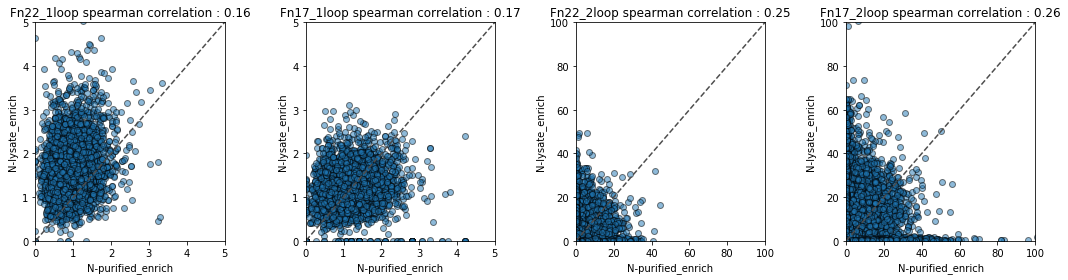

In [62]:
plt.figure(figsize=(15,4))
ploti = 0
for exp in explist:
    ploti += 1
    plt.subplot(1,4,ploti)
    plt.scatter(fdata[exp]['N-purified_enrich'],fdata[exp]['N-lysate_enrich'],alpha=0.5,edgecolor='black')
    #plt.xscale('log')
    #plt.yscale('log')
    if '1loop' in exp:
        plt.xlim([0,5])
        plt.ylim([0,5])
    else:
        plt.xlim([0,100])
        plt.ylim([0,100])
    plt.plot([1e-2, 1e2], [1e-2, 1e2], ls="--", c=".3")
    plt.xlabel('N-purified_enrich')
    plt.ylabel('N-lysate_enrich')
    rho = spearmanr(fdata[exp]['N-purified_enrich'],fdata[exp]['N-lysate_enrich'])[0]
    plt.title(exp+' spearman correlation : '+str(round(rho,2)))
plt.tight_layout()

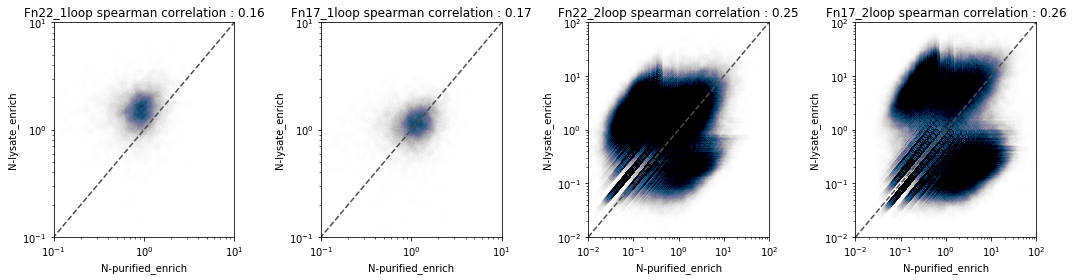

In [495]:
plt.figure(figsize=(15,4))
ploti = 0
for exp in explist:
    ploti += 1
    plt.subplot(1,4,ploti)
    plt.scatter(mdata[exp]['N-purified_enrich'],mdata[exp]['N-lysate_enrich'],alpha=0.002,edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    if '1loop' in exp:
        plt.xlim([0.1,10])
        plt.ylim([0.1,10])
    else:
        plt.xlim([1e-2,100])
        plt.ylim([1e-2,100])
    plt.plot([1e-2, 1e2], [1e-2, 1e2], ls="--", c=".3")
    plt.xlabel('N-purified_enrich')
    plt.ylabel('N-lysate_enrich')
    rho = spearmanr(fdata[exp]['N-purified_enrich'],fdata[exp]['N-lysate_enrich'])[0]
    plt.title(exp+' spearman correlation : '+str(round(rho,2)))
plt.tight_layout()

In [73]:
fdata['Fn22_2loop'].sort_values(by='N-lysate_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
225719    LSLWYKV  KRSFWSSPAG    6.0      66.0        0.0         5.0   
735233    PVLWYKV  KRSFWSVVAG    6.0      66.0        0.0        15.0   
38325     DSLWYKV  KRSFWSNSLL    6.0      65.0        0.0         3.0   
273078    PNLASKV  KRSFWSNSLL    6.0      64.0        0.0         3.0   
1800535   *ALWYKV  KRSFWSLSAG    6.0      56.0        0.0         0.0   
...           ...         ...    ...       ...        ...         ...   
2926081   PNLWYRR  KRSRPSNSAG   18.0       0.0        0.0         1.0   
2926077   PNLWYWM  KRSTRSNSAG   34.0       0.0        0.0         0.0   
2926075   PNLWGSV  KRSFWSLGAG   26.0       0.0        0.0        14.0   
2926071   PNLAVKV  *WSFWSNSAG   12.0       0.0        0.0         0.0   
11184809  PNRHYKV  KRSMLSNSAG   15.0       0.0       45.0         0.0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
225719        60.0  1.178783e-07       0.000005        0.000000   
735233        34.0  1.178783e-07       0.000005        0.000000   
38325         99.0  1.178783e-07       0.000005        0.000000   
273078        76.0  1.178783e-07       0.000005        0.000000   
1800535       24.0  1.178783e-07       0.000004        0.000000   
...            ...           ...            ...             ...   
2926081        6.0  3.536349e-07       0.000000        0.000000   
2926077        7.0  6.679771e-07       0.000000        0.000000   
2926075       13.0  5.108060e-07       0.000000        0.000000   
2926071        0.0  2.357566e-07       0.000000        0.000000   
11184809       0.0  2.946958e-07       0.000000        0.000027   

          N-purified_freq  preclear_freq  N-lysate_enrich  NP-lysate_enrich  \
225719       3.170129e-07   1.080355e-06        49.187712          0.000000   
735233       9.510386e-07   6.122013e-07        49.187712          0.000000   
38325        1.902077e-07   1.782586e-06        48.442444          0.000000   
273078       1.902077e-07   1.368450e-06        47.697175          0.000000   
1800535      0.000000e+00   4.321421e-07        41.735028          0.000000   
...                   ...            ...              ...               ...   
2926081      6.340257e-08   1.080355e-07         0.000000          0.000000   
2926077      0.000000e+00   1.260414e-07         0.000000          0.000000   
2926075      8.876360e-07   2.340770e-07         0.000000          0.000000   
2926071      0.000000e+00   0.000000e+00         0.000000          0.000000   
11184809     0.000000e+00   0.000000e+00         0.000000         54.584483   

          N-purified_enrich  preclear_enrich  
225719             1.878293         9.709265  
735233             5.634878         5.501917  
38325              1.126976        16.020287  
273078             1.126976        12.298402  
1800535            0.000000         3.883706  
...                     ...              ...  
2926081            0.125220         0.323642  
2926077            0.000000         0.199897  
2926075            1.213666         0.485463  
2926071            0.000000         0.000000  
11184809           0.000000         0.000000  

[2011540 rows x 16 columns]

In [74]:
fdata['Fn22_1loop'][fdata['Fn22_1loop']['Loop1']=='LSLWYKV']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
4151  LSLWYKV  KRSFWSNSAG    709       179        228          97       758   

      Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
4151    0.000867       0.000879        0.000841          0.00079   

      preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
4151       0.000912         1.490169           1.60741           0.826435   

      preclear_enrich  
4151         0.958789

In [75]:
fdata['Fn22_1loop'][fdata['Fn22_1loop']['Loop2']=='KRSFWSSPAG']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
106339  PNLWYKV  KRSFWSSPAG    179        68         51          30       196   

        Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
106339    0.000219       0.000334        0.000188         0.000244   

        preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
106339       0.000236         2.242253          1.424148           1.012398   

        preclear_enrich  
106339         0.981981

In [155]:
sum(fdata['Fn17_1loop'][fdata['Fn17_1loop']['seq']==refdict['Fn22']]['Input_freq'])

0.0001464832927131308

In [14]:
from distance import hamming

In [65]:
for exp in explist:
    fdata[exp]['seq']=fdata[exp]['Loop1']+'_'+fdata[exp]['Loop2']

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
mdata = {}
for exp in explist:
    refseq = refdict[exp.rsplit('_')[0]]
    fdata[exp]['mutpos'] = fdata[exp]['seq'].apply(lambda x:[i for i in range(len(x)) if x[i] != refseq[i]])
    mdata[exp] = fdata[exp][fdata[exp]['mutpos'].apply(lambda x:len(x)<=4)] #Filter multi-mutations and potential cross-library contaminations
mdata['Fn17_2loop']

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
1         PRHYYNI  TRWRLYQLRQ     11         0          0           0   
6         PAISYNI  TRWRSDQMWQ     22        57          0           0   
7         PANYYLD  TLMRLYQMWQ     16         0          0           0   
17        PANYYTV  TRWRLYDVWQ     15         1          0           0   
23        LPNYYNI  TKARLYQMWQ     11        27          0           0   
...           ...         ...    ...       ...        ...         ...   
11776006  *KNYYNI  TRWSLYQMWQ     21         0          0           1   
11776019  YRNYYNI  TRWYAYQMWQ     17         0          0           0   
11776022  PANYYE*  TRWRLYQMDM     15         0          0           1   
11776023  PANYSSI  TRWRGAQMWQ     11         3          0           0   
11776025  PENYYNI  TRWRLYPAWQ     14         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
1               30  3.266111e-07   0.000000e+00             0.0  ...   
6               11  6.532221e-07   2.211157e-06             0.0  ...   
7                9  4.750706e-07   0.000000e+00             0.0  ...   
17               1  4.453787e-07   3.879223e-08             0.0  ...   
23              18  3.266111e-07   1.047390e-06             0.0  ...   
...            ...           ...            ...             ...  ...   
11776006        29  6.235302e-07   0.000000e+00             0.0  ...   
11776019        18  5.047625e-07   0.000000e+00             0.0  ...   
11776022         0  4.453787e-07   0.000000e+00             0.0  ...   
11776023        38  3.266111e-07   1.163767e-07             0.0  ...   
11776025         6  4.156868e-07   0.000000e+00             0.0  ...   

          preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
1          3.683327e-07         0.000000               0.0           0.000000   
6          1.350553e-07         7.069126               0.0           0.000000   
7          1.104998e-07         0.000000               0.0           0.000000   
17         1.227776e-08         0.181896               0.0           0.000000   
23         2.209996e-07         6.697067               0.0           0.000000   
...                 ...              ...               ...                ...   
11776006   3.560550e-07         0.000000               0.0           0.173213   
11776019   2.209996e-07         0.000000               0.0           0.000000   
11776022   0.000000e+00         0.000000               0.0           0.242499   
11776023   4.665548e-07         0.744119               0.0           0.000000   
11776025   7.366655e-08         0.000000               0.0           0.000000   

          preclear_enrich  N-lysate_enrich2  NP-lysate_enrich2  \
1                1.231889          0.000000                0.0   
6                0.225846         11.220699                0.0   
7                0.254077          0.000000                0.0   
17               0.030113          0.339066                0.0   
23               0.739133          7.650961                0.0   
...                   ...               ...                ...   
11776006         0.623766          0.000000                0.0   
11776019         0.478263          0.000000                0.0   
11776022         0.000000          0.000000                0.0   
11776023         1.560392          0.586923                0.0   
11776025         0.193583          0.000000                0.0   

          N-purified_enrich2                 seq          mutpos  
1                   0.000000  PRHYYNI_TRWRLYQLRQ  [1, 2, 15, 16]  
6                   0.000000  PAISYNI_TRWRSDQMWQ  [2, 3, 12, 13]  
7                   0.000000  PANYYLD_TLMRLYQMWQ   [5, 6, 9, 10]  
17                  0.000000  PANYYTV_TRWRLYDVWQ  [5, 6, 14, 15]  
23                  0.000000  LPNYYNI_TKARLYQMWQ   [0, 1, 9, 10]  
...                      ...                 ...             ...  
11776006            0.211188  *KNYY

Fn22_1loop
Fn17_1loop
Fn22_2loop
Fn17_2loop


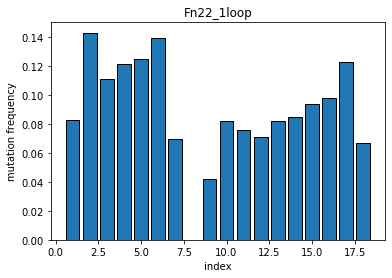

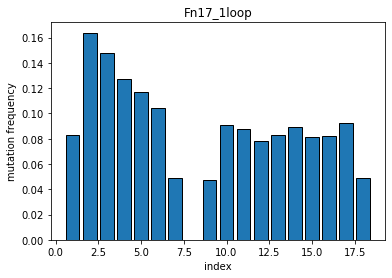

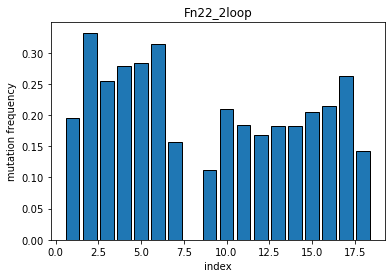

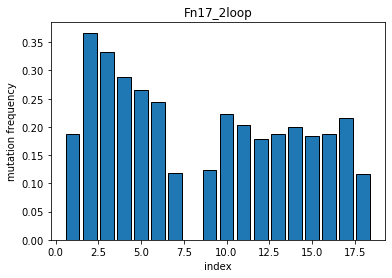

In [130]:
for exp in explist:
    print(exp)
    mutdict = {}
    refseq = refdict[exp.rsplit('_')[0]]
    for i in range(len(refseq)):
        mutdict[i] = sum(fdata[exp][fdata[exp]['mutpos'].apply(lambda x: i in x)]['Input_freq'])
    plt.figure()
    xlist = []
    ylist = []
    for i in range(len(refseq)):
        xlist.append(i+1)
        ylist.append(mutdict[i])
    plt.bar(xlist,ylist,edgecolor='black')
    plt.title(exp)
    plt.ylabel('mutation frequency')
    plt.xlabel('index')

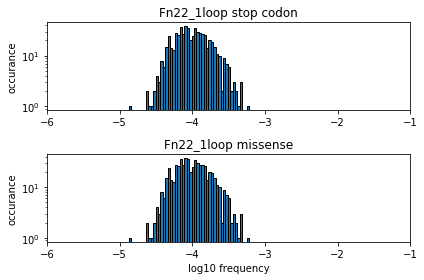

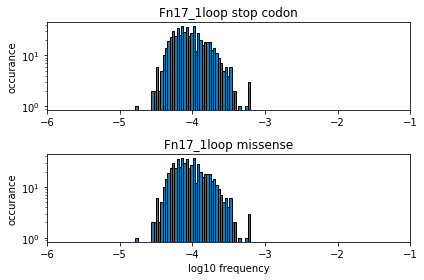

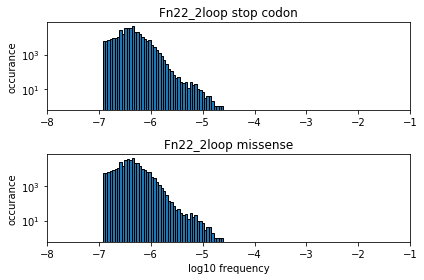

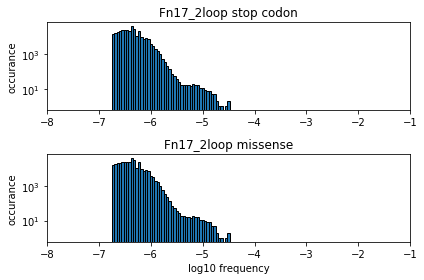

In [171]:
#stop codon frequency
for exp in explist:
    #stoplist = fdata[exp][fdata[exp]['seq'].str.contains('\*')]['Input_freq']
    #mislist  = fdata[exp][~fdata[exp]['seq'].str.contains('\*')]['Input_freq']
    stoplist = mdata[exp][mdata[exp]['seq'].str.contains('\*')]['Input_freq']
    mislist  = mdata[exp][mdata[exp]['seq'].str.contains('\*')]['Input_freq']

    plt.figure()
    plt.subplot(2,1,1)
    plt.hist(np.log10(stoplist),bins=50,edgecolor='black')
    plt.title(exp + ' stop codon')
    plt.ylabel('occurance')
    if '1loop' in exp:
        plt.xlim([-6,-1])
    else:
        plt.xlim([-8,-1])
    plt.yscale('log')
    plt.subplot(2,1,2)
    plt.hist(np.log10(mislist),bins=50,edgecolor='black')
    plt.title(exp+' missense')
    plt.ylabel('occurance')
    plt.xlabel('log10 frequency')
    if '1loop' in exp:
        plt.xlim([-6,-1])
    else:
        plt.xlim([-8,-1])
    plt.yscale('log')
    plt.tight_layout()

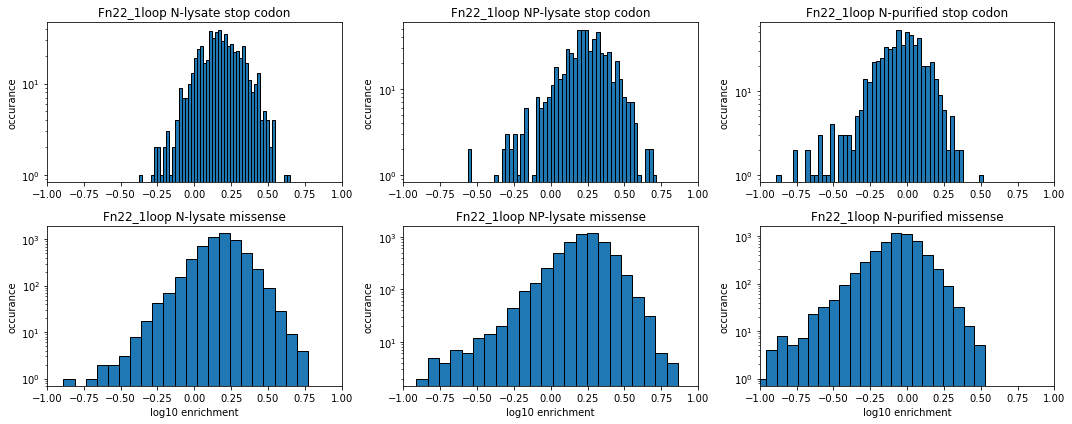

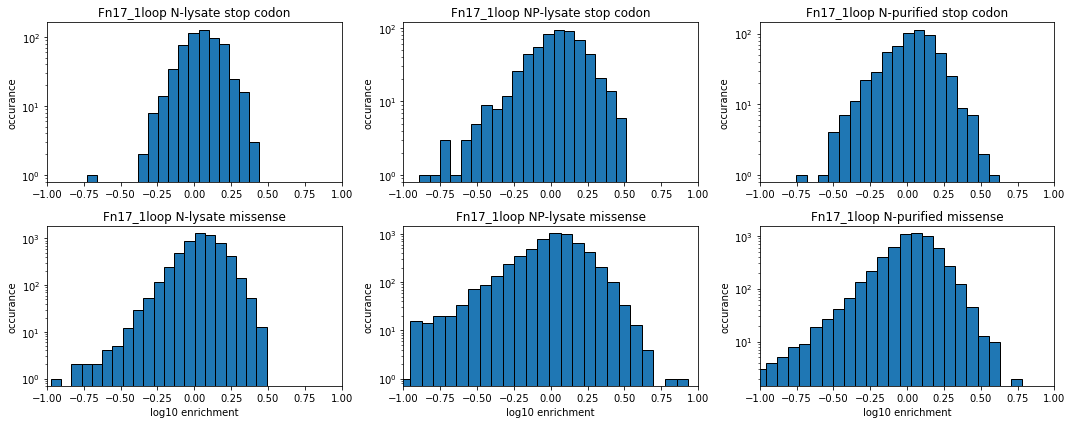

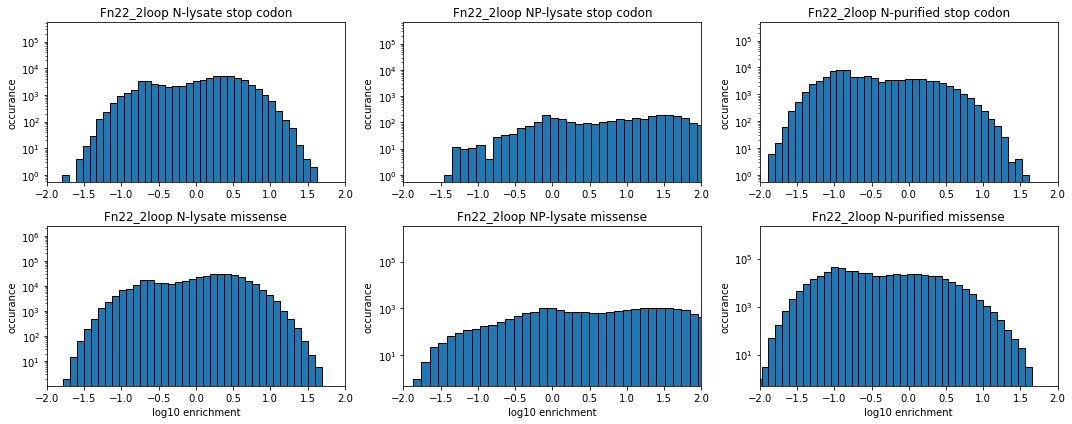

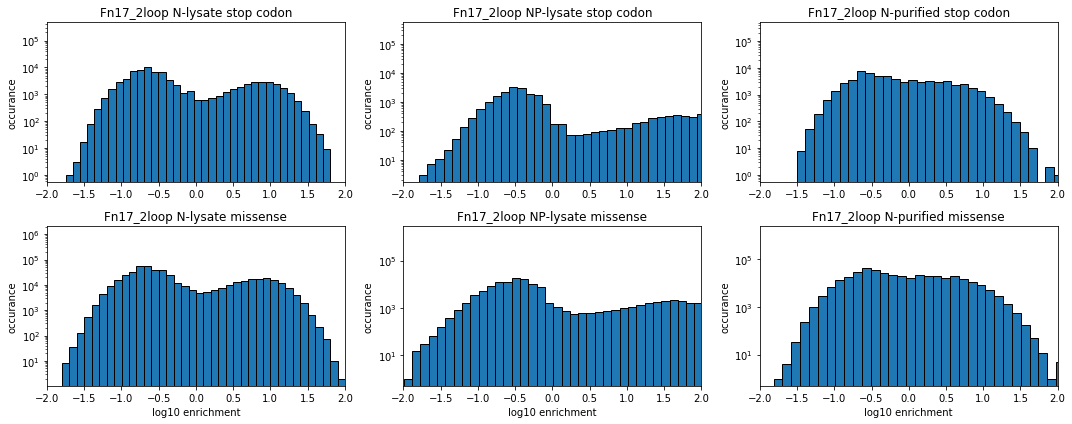

In [136]:
#stop codon
for exp in explist:
    stopdict = {}; misdict = {}
    for lib in liblist[1:-1]:
        stopdict[lib] = fdata[exp][fdata[exp]['seq'].str.contains('\*')][lib+'_enrich']
        misdict[lib] = fdata[exp][~fdata[exp]['seq'].str.contains('\*')][lib+'_enrich']
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(2,3,ploti)
        plt.hist(np.log10(stopdict[lib]+1e-3),bins=50,edgecolor='black')
        plt.title(exp+' '+lib+' stop codon')
        plt.ylabel('occurance')
        if '1loop' in exp:
            plt.xlim([-1,1])
        else:
            plt.xlim([-2,2])
        plt.yscale('log')
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(2,3,ploti)
        plt.hist(np.log10(misdict[lib]+1e-3),bins=50,edgecolor='black')
        plt.title(exp+' '+lib+' missense')
        plt.ylabel('occurance')
        plt.xlabel('log10 enrichment')
        if '1loop' in exp:
            plt.xlim([-1,1])
        else:
            plt.xlim([-2,2])
        plt.yscale('log')
    plt.tight_layout()

In [137]:
fdata

{'Fn22_1loop':           Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
 17      PNLWYKV  KRSFWLWSAG    160        48         49          23       144   
 28      PRKWYKV  KRSFWSNSAG    109        30         55          17       139   
 58      PNLWYKV  QHSFWSNSAG     40         8         12           6        38   
 100     PNLWYKV  KRSFWSRFAG     73        21         28          15        84   
 171     PNLMWKV  KRSFWSNSAG     89        10         27           4        83   
 ...         ...         ...    ...       ...        ...         ...       ...   
 214499  PNLWYKV  KRPSWSNSAG     93        49         42          17       119   
 214513  PNLWYKV  YWSFWSNSAG     40        14         25           6        41   
 214642  PNLWYKV  FPSFWSNSAG     97        27         39          18        84   
 214665  PNLWYKV  KRSFWSNAKG     71        17         28          14        70   
 214801  PAYWYKV  KRSFWSNSAG     71        20         21           6       101   
 


Fn22_1loop
Fn17_1loop
Fn22_2loop
Fn17_2loop


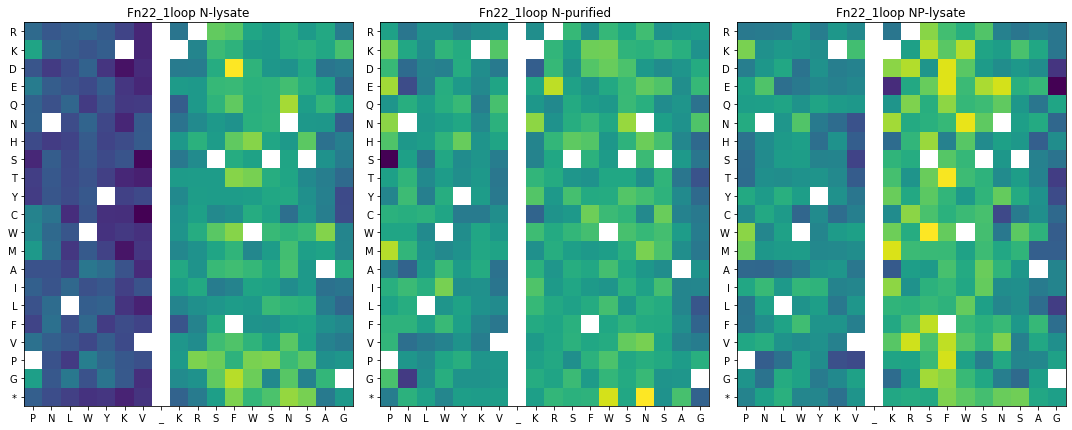

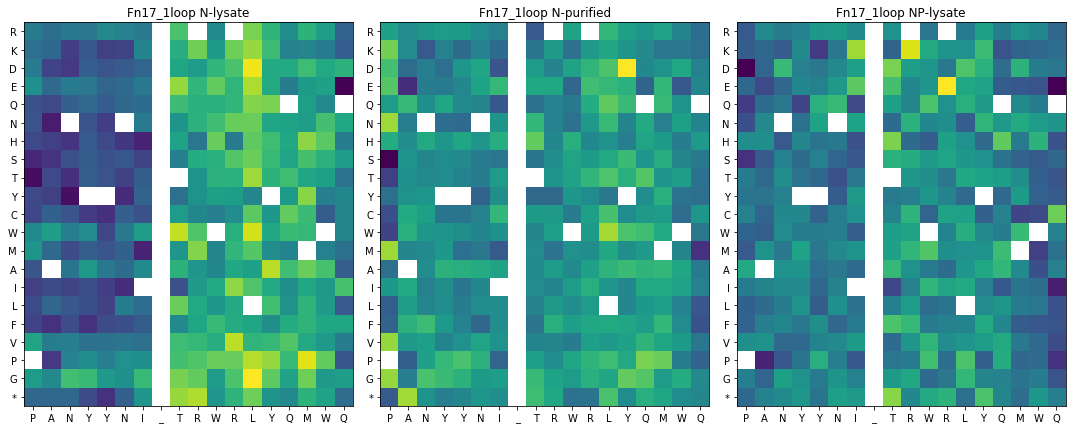

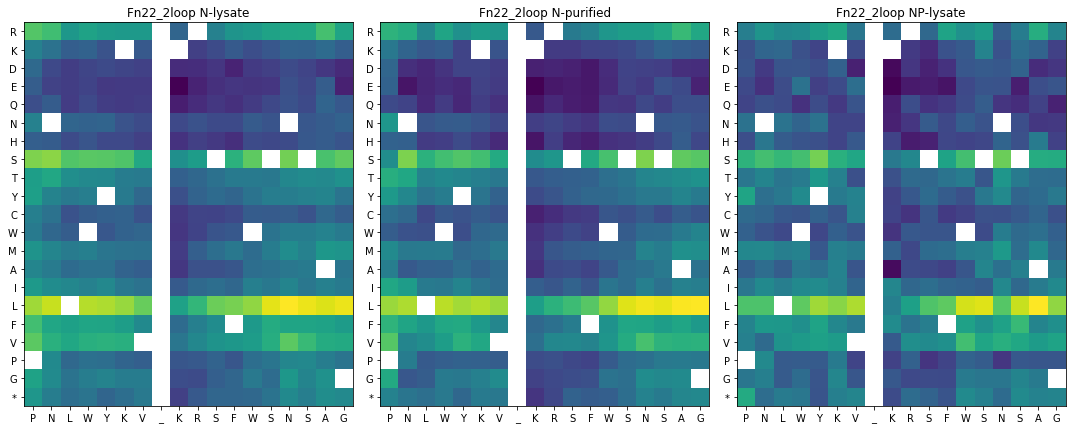

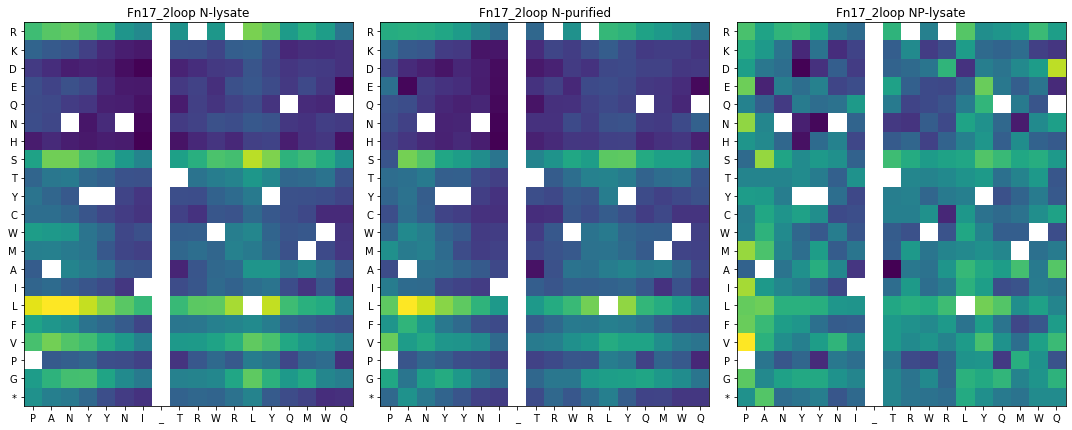

In [207]:
#heatmap
liblist = ['Input','N-lysate','N-purified','NP-lysate','preclear']
aalist = ['R','K','D','E','Q','N','H','S','T','Y','C','W','M','A','I','L','F','V','P','G','*']
for exp in explist:
    print(exp)
    refseq = refdict[exp.rsplit('_')[0]]
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        heatarray = []
        for i in range(len(aalist)):
            heatarray.append([])
            for j in range(len(refseq)):
                heatarray[i].append(np.mean(mdata[exp][(mdata[exp]['mutpos'].apply(lambda x: j in x)) & (mdata[exp]['seq'].apply(lambda x: x[j]==aalist[i]))][lib+'_enrich']))
        plt.subplot(1,3,ploti)
        plt.imshow(heatarray)
        plt.xticks(np.arange(len(refseq)),list(refseq))
        plt.yticks(np.arange(len(aalist)),aalist)
        plt.title(exp+' '+lib)
    plt.tight_layout()

In [181]:
for exp in explist:
    if '1loop' in exp: continue
    mdata[exp+'_agg_Loop1'] = mdata[exp].groupby('Loop1').agg('mean')
    mdata[exp+'_agg_Loop2'] = mdata[exp].groupby('Loop2').agg('mean') 

In [208]:
for exp in mdata:
    if 'agg' in exp:
        outfile = open(exp,'w')
        mdata[exp].to_csv(outfile)
        outfile.close()

In [195]:
fdata['Fn17_2loop'].sort_values(by='N-purified',ascending=False)

#fdata['Fn17_2loop'][fdata['Fn17_2loop']['Loop2']=='TREQLYQMWQ'].sort_values(by='N-lysate_enrich',ascending=False)


Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
6422882   PWAYYNI  PEWRLYQMWQ     47        28          2        4484   
6579716   TLNYYNI  TRWTLYQMWQ     63        31          3        3252   
1645960   PANYYNI  TRWRLYQMWQ   7686      2817       1669        2113   
3920039   PANMTNI  TRWRLYQMSN      9         6          0        2097   
9529445   PSNYYNI  TRWRLYQRYQ     24        14          0        1667   
...           ...         ...    ...       ...        ...         ...   
4422868   PANYHGI  TRWRLYQMNT      7         0          0           0   
4422857   PANYHGI  TRWRLYQMND     15         0          0           0   
4422851   PKTYYNI  TEHRLYQMWQ     15         0          0           0   
4422827   PWMYYNI  TRWRLFGMWQ     12         0          0           0   
11776031  PA*WYNI  WWWRLYQY*Q     11         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
6422882          0  1.395520e-06   1.086183e-06    2.207561e-07   
6579716         88  1.870591e-06   1.202559e-06    3.311342e-07   
1645960      17016  2.282121e-04   1.092777e-04    1.842210e-04   
3920039         16  2.672272e-07   2.327534e-07    0.000000e+00   
9529445         20  7.126059e-07   5.430913e-07    0.000000e+00   
...            ...           ...            ...             ...   
4422868          1  2.078434e-07   0.000000e+00    0.000000e+00   
4422857          0  4.453787e-07   0.000000e+00    0.000000e+00   
4422851          0  4.453787e-07   0.000000e+00    0.000000e+00   
4422827          7  3.563030e-07   0.000000e+00    0.000000e+00   
11776031         0  3.266111e-07   0.000000e+00    0.000000e+00   

          N-purified_freq  preclear_freq  N-lysate_enrich  N-purified_enrich  \
6422882          0.000419   0.000000e+00         1.625450         347.031286   
6579716          0.000304   1.080443e-06         1.342563         187.763370   
1645960          0.000197   2.089183e-04         1.000000           1.000000   
3920039          0.000196   1.964441e-07         1.818956         847.533365   
9529445          0.000156   2.455552e-07         1.591587         252.653455   
...                   ...            ...              ...                ...   
4422868          0.000000   1.227776e-08         0.000000           0.000000   
4422857          0.000000   0.000000e+00         0.000000           0.000000   
4422851          0.000000   0.000000e+00         0.000000           0.000000   
4422827          0.000000   8.594431e-08         0.000000           0.000000   
11776031         0.000000   0.000000e+00         0.000000           0.000000   

          NP-lysate_enrich  preclear_enrich                 seq  \
6422882           0.195964         0.000000  PWAYYNI_PEWRLYQMWQ   
6579716           0.219293         0.630936  TLNYYNI_TRWTLYQMWQ   
1645960           1.000000         1.000000  PANYYNI_TRWRLYQMWQ   
3920039           0.000000         0.803009  PANMTNI_TRWRLYQMSN   
9529445           0.000000         0.376410  PSNYYNI_TRWRLYQRYQ   
...                    ...              ...                 ...   
4422868           0.000000         0.064528  PANYHGI_TRWRLYQMNT   
4422857           0.000000         0.000000  PANYHGI_TRWRLYQMND   
4422851           0.000000         0.000000  PKTYYNI_TEHRLYQMWQ   
4422827           0.000000         0.263487  PWMYYNI_TRWRLFGMWQ   
11776031          0.000000         0.000000  PA*WYNI_WWWRLYQY*Q   

                        mutpos  
6422882           [1, 2, 8, 9]  
6579716             [0, 1, 11]  
1645960                     []  
3920039         [3, 4, 16, 17]  
9529445            [1, 15, 16]  
...                        ...  
4422868         [4, 5, 16, 17]  
4422857         [4, 5, 16, 17]  
4422851          [1, 2, 9, 10]  
4422827         [1, 2, 13, 14]  
11776031  [2, 3, 8, 9, 15, 16]  

[1912883 rows x 18 columns]

In [211]:
mdata['Fn17_2loop'].sort_values(by='N-lysate_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
9758134   PFLYYNI  TRWRLYQASQ      6       221          0          10   
6134414   PANYSLI  TRWLRYQMWQ      6       216          1           2   
9429394   PSSYYNI  TRWRLYQMTK      6       162          1          16   
10413123  PLLYYNI  TRWREAQMWQ      8       216          0           8   
3545663   PANRSNI  TRWRMIQMWQ      6       157          0           0   
...           ...         ...    ...       ...        ...         ...   
4598082   IINYYNI  TRWRLAPMWQ     32         0          0           0   
4598078   PEIYYNI  SRWKDYQMWQ      8         0          0           0   
4598068   PAYRYNI  **WRLYQMWQ     25         0          0           0   
4598058   PANYRGI  TRICLYQMWQ     25         0          0           1   
11776031  PA*WYNI  WWWRLYQY*Q     11         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
9758134         66  1.781515e-07       0.000009    0.000000e+00   
6134414         89  1.781515e-07       0.000008    1.103781e-07   
9429394         53  1.781515e-07       0.000006    1.103781e-07   
10413123       103  2.375353e-07       0.000008    0.000000e+00   
3545663         17  1.781515e-07       0.000006    0.000000e+00   
...            ...           ...            ...             ...   
4598082         13  9.501412e-07       0.000000    0.000000e+00   
4598078          0  2.375353e-07       0.000000    0.000000e+00   
4598068         13  7.422979e-07       0.000000    0.000000e+00   
4598058          8  7.422979e-07       0.000000    0.000000e+00   
11776031         0  3.266111e-07       0.000000    0.000000e+00   

          N-purified_freq  preclear_freq  N-lysate_enrich  N-purified_enrich  \
9758134      9.345787e-07   8.103320e-07       100.497338           6.062470   
6134414      1.869157e-07   1.092720e-06        98.223642           1.212494   
9429394      1.495326e-06   6.507212e-07        73.667732           9.699953   
10413123     7.476630e-07   1.264609e-06        73.667732           3.637482   
3545663      0.000000e+00   2.087219e-07        71.394036           0.000000   
...                   ...            ...              ...                ...   
4598082      0.000000e+00   1.596109e-07         0.000000           0.000000   
4598078      0.000000e+00   0.000000e+00         0.000000           0.000000   
4598068      0.000000e+00   1.596109e-07         0.000000           0.000000   
4598058      9.345787e-08   9.822207e-08         0.000000           0.145499   
11776031     0.000000e+00   0.000000e+00         0.000000           0.000000   

          NP-lysate_enrich  preclear_enrich                 seq  \
9758134           0.000000         4.968618  PFLYYNI_TRWRLYQASQ   
6134414           0.767525         6.700106  PANYSLI_TRWLRYQMWQ   
9429394           0.767525         3.989951  PSSYYNI_TRWRLYQMTK   
10413123          0.000000         5.815541  PLLYYNI_TRWREAQMWQ   
3545663           0.000000         1.279795  PANRSNI_TRWRMIQMWQ   
...                    ...              ...                 ...   
4598082           0.000000         0.183500  IINYYNI_TRWRLAPMWQ   
4598078           0.000000         0.000000  PEIYYNI_SRWKDYQMWQ   
4598068           0.000000         0.234880  PAYRYNI_**WRLYQMWQ   
4598058           0.000000         0.144542  PANYRGI_TRICLYQMWQ   
11776031          0.000000         0.000000  PA*WYNI_WWWRLYQY*Q   

                        mutpos  
9758134         [1, 2, 15, 16]  
6134414         [4, 5, 11, 12]  
9429394         [1, 2, 16, 17]  
10413123        [1, 2, 12, 13]  
3545663         [3, 4, 12, 13]  
...                        ...  
4598082         [0, 1, 13, 14]  
4598078      [1, 2, 8, 11, 12]  
4598068           [2, 3, 8, 9]  
4598058         [4, 5, 10, 11]  
11776031  [2, 3, 8, 9, 15, 16]  

[1907014 rows x 18 columns]

In [198]:
fdata['Fn22_2loop'].sort_values(by='N-purified_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
531553    PNTWYKV  KRSFVSNSAG    6.0      22.0        0.0       119.0   
545238    PNLWYLG  KRSFWLLSAG    6.0      43.0        0.0       112.0   
979659    LTLWYKV  KRSFWSMSAG    7.0       7.0        0.0       128.0   
2116264   TLLWYKV  KRSFWSNSI*    6.0       0.0        0.0       109.0   
9078516   NFLWYKV  KRSFWSLYAG    6.0       1.0        0.0        94.0   
...           ...         ...    ...       ...        ...         ...   
3164665   PNEFYKV  GHSFWSNSAG   11.0       0.0        0.0         0.0   
3164662   PNLRSKV  KQSFWSNSAG   16.0       0.0        0.0         0.0   
3164653   PLVWYKV  GSSFWSNSAG   37.0      35.0        0.0         0.0   
3164614   ISLWYKV  KRSFWSNDQG   16.0       1.0        0.0         0.0   
11184809  PNRHYKV  KRSMLSNSAG   15.0       0.0       45.0         0.0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
531553        39.0  1.178783e-07   1.643874e-06        0.000000   
545238        73.0  1.178783e-07   3.213026e-06        0.000000   
979659        54.0  1.375247e-07   5.230507e-07        0.000000   
2116264       18.0  1.178783e-07   0.000000e+00        0.000000   
9078516       10.0  1.178783e-07   7.472153e-08        0.000000   
...            ...           ...            ...             ...   
3164665        3.0  2.161102e-07   0.000000e+00        0.000000   
3164662        4.0  3.143422e-07   0.000000e+00        0.000000   
3164653       43.0  7.269163e-07   2.615254e-06        0.000000   
3164614        2.0  3.143422e-07   7.472153e-08        0.000000   
11184809       0.0  2.946958e-07   0.000000e+00        0.000027   

          N-purified_freq  preclear_freq  N-lysate_enrich  N-purified_enrich  \
531553           0.000008   7.022309e-07        16.395904          44.703368   
545238           0.000007   1.314432e-06        32.046540          42.073758   
979659           0.000008   9.723197e-07         4.471610          41.215110   
2116264          0.000007   3.241066e-07         0.000000          40.946782   
9078516          0.000006   1.800592e-07         0.745268          35.311904   
...                   ...            ...              ...                ...   
3164665          0.000000   5.401776e-08         0.000000           0.000000   
3164662          0.000000   7.202368e-08         0.000000           0.000000   
3164653          0.000000   7.742546e-07         4.229902           0.000000   
3164614          0.000000   3.601184e-08         0.279476           0.000000   
11184809         0.000000   0.000000e+00         0.000000           0.000000   

          NP-lysate_enrich  preclear_enrich                 seq  \
531553            0.000000         6.311022  PNTWYKV_KRSFVSNSAG   
545238            0.000000        11.812939  PNLWYLG_KRSFWLLSAG   
979659            0.000000         7.490004  LTLWYKV_KRSFWSMSAG   
2116264           0.000000         2.912779  TLLWYKV_KRSFWSNSI*   
9078516           0.000000         1.618211  NFLWYKV_KRSFWSLYAG   
...                    ...              ...                 ...   
3164665           0.000000         0.264798  PNEFYKV_GHSFWSNSAG   
3164662           0.000000         0.242732  PNLRSKV_KQSFWSNSAG   
3164653           0.000000         1.128374  PLVWYKV_GSSFWSNSAG   
3164614           0.000000         0.121366  ISLWYKV_KRSFWSNDQG   
11184809         54.584483         0.000000  PNRHYKV_KRSMLSNSAG   

                  mutpos  
531553           [2, 12]  
545238    [5, 6, 13, 14]  
979659        [0, 1, 14]  
2116264   [0, 1, 16, 17]  
9078516   [0, 1, 14, 15]  
...                  ...  
3164665     [2, 3, 8, 9]  
3164662        [3, 4, 9]  
3164653     [1, 2, 8, 9]  
3164614   [0, 1, 15, 16]  
11184809  [2, 3, 11, 12]  

[2011540 rows x 18 columns]

In [203]:
fdata['Fn22_1loop'][fdata['Fn22_1loop']['Loop1']=='PNLWYLG']
#fdata['Fn22_1loop'][fdata['Fn22_1loop']['Loop2']=='KRSFVSNSAG']

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
187780  PNLWYLG  KRSFWSNSAG    413        72        122          65       366   

        Input_freq  N-lysate_freq  NP-lysate_freq  N-purified_freq  \
187780    0.000505       0.000354         0.00045          0.00053   

        preclear_freq  N-lysate_enrich  N-purified_enrich  NP-lysate_enrich  \
187780        0.00044          1.02899           0.950707          1.476549   

        preclear_enrich                 seq  mutpos  
187780         0.794751  PNLWYLG_KRSFWSNSAG  [5, 6]

Fn22_1loop
Fn17_1loop
Fn22_2loop
Fn17_2loop


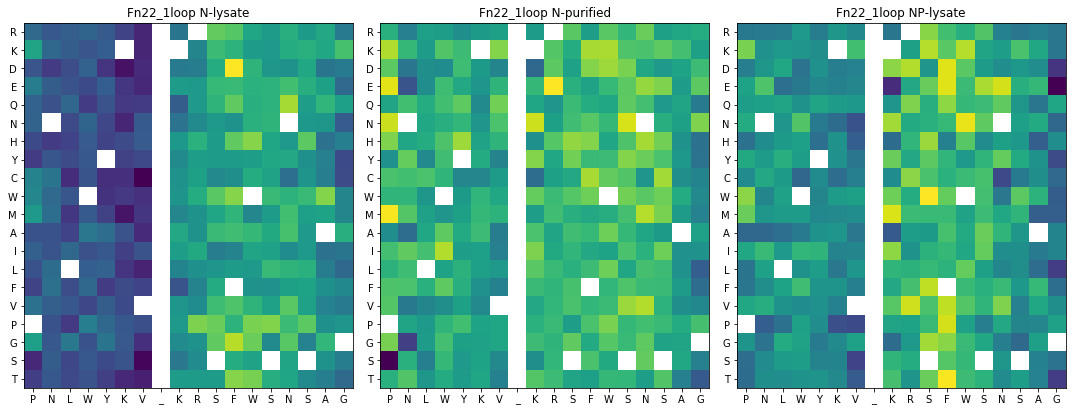

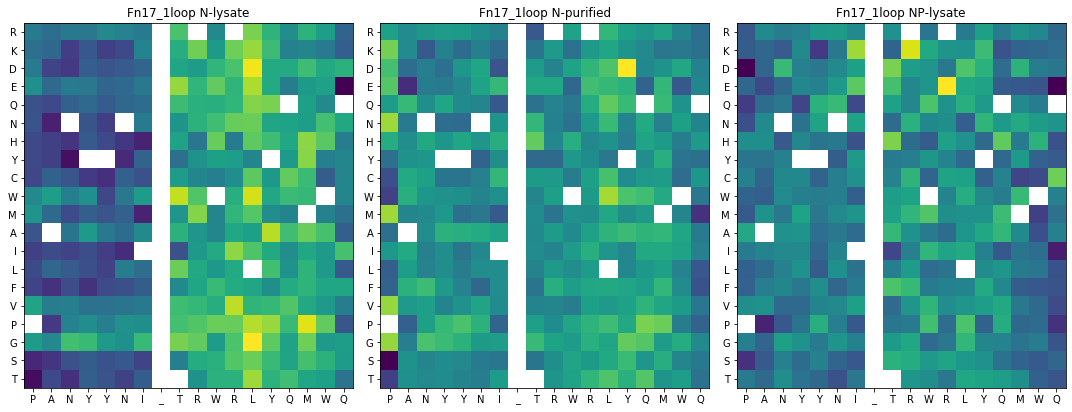

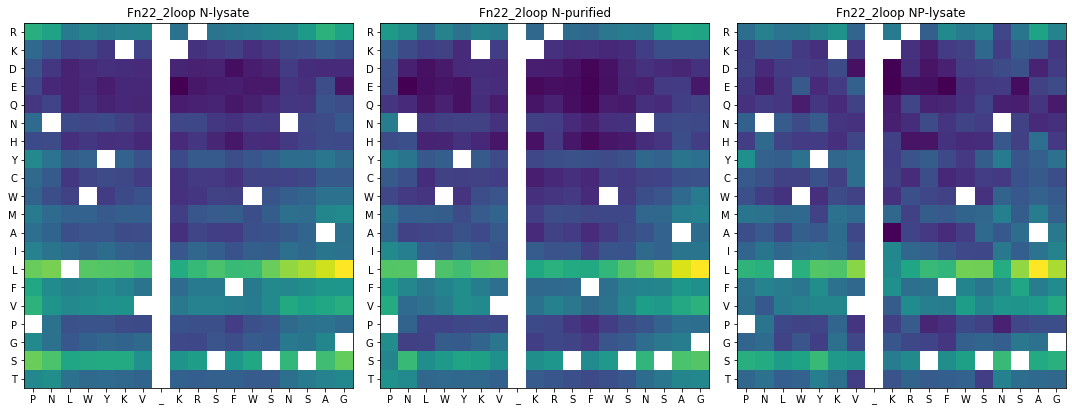

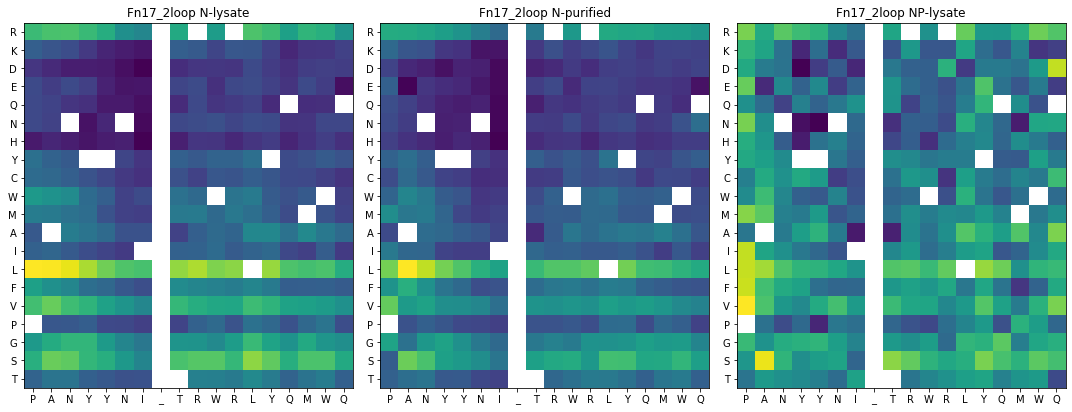

In [437]:
liblist = ['Input','N-lysate','N-purified','NP-lysate','preclear']
aalist = ['R','K','D','E','Q','N','H','Y','C','W','M','A','I','L','F','V','P','G','S','T']
heatdict = {}
for exp in explist:
    heatdict[exp] = {}
    print(exp)
    refseq = refdict[exp.rsplit('_')[0]]
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        #print(lib)
        ploti += 1
        heatarray = []
        for i in range(len(aalist)):
            heatarray.append([])
            for j in range(len(refseq)):
                heatarray[i].append(np.mean(mdata[exp][(mdata[exp]['mutpos'].apply(lambda x: j in x)) & (mdata[exp]['seq'].apply(lambda x: x[j]==aalist[i]))][lib+'_enrich']))
        plt.subplot(1,3,ploti)
        plt.imshow(heatarray)
        plt.xticks(np.arange(len(refseq)),list(refseq))
        plt.yticks(np.arange(len(aalist)),aalist)
        plt.title(exp+' '+lib)
        heatdict[exp][lib] = heatarray
    plt.tight_layout()

In [473]:
j=1; i = 1
mdata[exp][(mdata[exp]['mutpos'].apply(lambda x: j in x)) & (mdata[exp]['seq'].apply(lambda x: x[j]==aalist[i])) & (mdata[exp]['NP-lysate_enrich']>0 )]

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
2187      PKGYYNI  GSWRLYQMWQ     20         2          1           0   
5342      VKNYYNI  TRWRLFGMWQ      9         0          1          32   
9458      VKNYYNI  TRLRLYQMWQ     66         2         83           0   
21040     PKWYYNI  TRWRLVLMWQ     16         1          1           0   
21737     PKKYYNI  TRGMLYQMWQ      8         0          2           0   
...           ...         ...    ...       ...        ...         ...   
11721577  MKNYYNI  TRWRLYQSTQ     15         0          1           0   
11727022  PKMYYNI  TRW*VYQMWQ     15         0          1           0   
11735098  PKVYYNI  TRWRLYQLLQ     21         1          1           0   
11752224  GKNYYNI  TRWLVYQMWQ     15         1          1           1   
11772342  LKNYYNI  TRWPLYQMWQ     47         1          1           1   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
2187            18  5.938383e-07   7.758447e-08    1.103781e-07  ...   
5342             0  2.672272e-07   0.000000e+00    1.103781e-07  ...   
9458            62  1.959666e-06   7.758447e-08    9.161379e-06  ...   
21040           25  4.750706e-07   3.879223e-08    1.103781e-07  ...   
21737            0  2.375353e-07   0.000000e+00    2.207561e-07  ...   
...            ...           ...            ...             ...  ...   
11721577        20  4.453787e-07   0.000000e+00    1.103781e-07  ...   
11727022         9  4.453787e-07   0.000000e+00    1.103781e-07  ...   
11735098        57  6.235302e-07   3.879223e-08    1.103781e-07  ...   
11752224        32  4.453787e-07   3.879223e-08    1.103781e-07  ...   
11772342        60  1.395520e-06   3.879223e-08    1.103781e-07  ...   

          N-lysate_predict  NP-lysate_predict  N-purified_predict  \
2187              1.446630           0.257901            1.141520   
5342              1.428324           0.257901            1.014912   
9458              3.367359           0.932726            2.325125   
21040             1.531406           0.257901            1.364096   
21737             0.951324           0.257901            0.509376   
...                    ...                ...                 ...   
11721577          1.285757           0.257901            0.721166   
11727022          1.112532           0.257901            0.509376   
11735098          2.891161           0.257901            2.159788   
11752224          2.156831           0.257901            1.395118   
11772342          2.064163           0.932726            1.703623   

          N-lysate_predict2  NP-lysate_predict2  N-purified_predict2  \
2187               0.017551            0.042935             1.713912   
5342               0.611590           -1.335085             1.601531   
9458              -0.131535           -2.887773             6.036017   
21040              1.403837           -1.006745             1.347236   
21737             -0.405481           -1.050864             0.320568   
...                     ...                 ...                  ...   
11721577           0.906490           -1.249063             1.195056   
11727022           0.033890           -1.857882             0.628668   
11735098           1.570491            0.106357             1.064711   
11752224           1.044752           -1.509593             0.844765   
11772342          -1.415371           -2.298303             5.543828   

         N-lysate_abs_enrich N-purified_abs_enrich  NP-lysate_abs_enrich  \
2187                0.130649              0.000000              0.185872   
5342                0.000000             11.191419              0.413049   
9458                0.039591              0.000000              4.674969   
21040               0.081656              0.000000              0.232340   
21737               0.000000              0.000000              0.929361   
...                      ...                   ...                   ...   
11721577            0.000000              0.

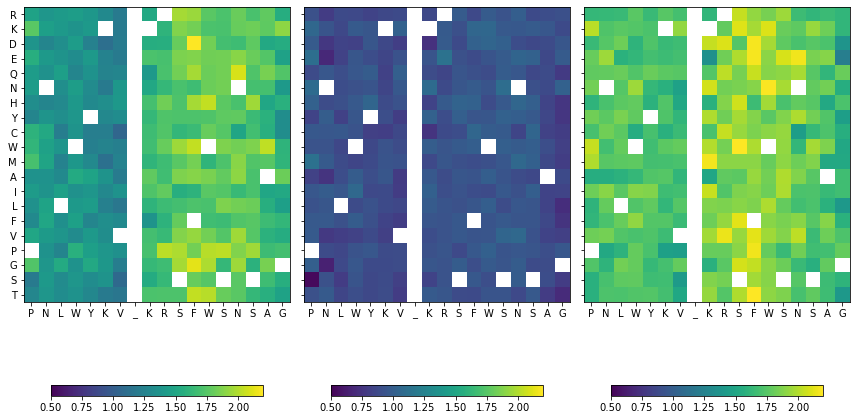

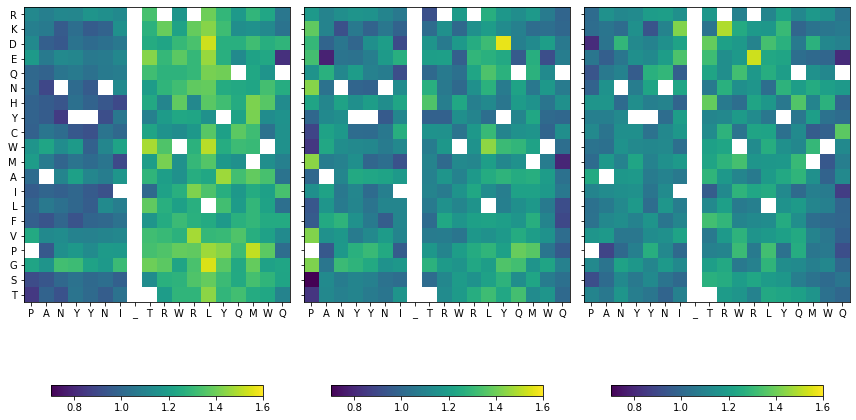

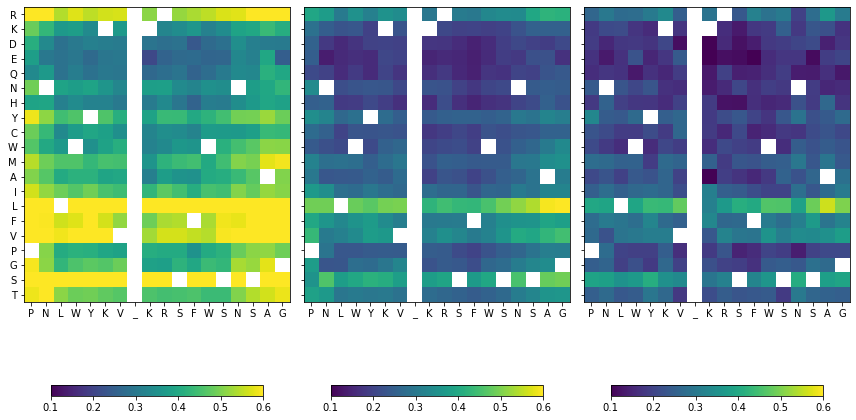

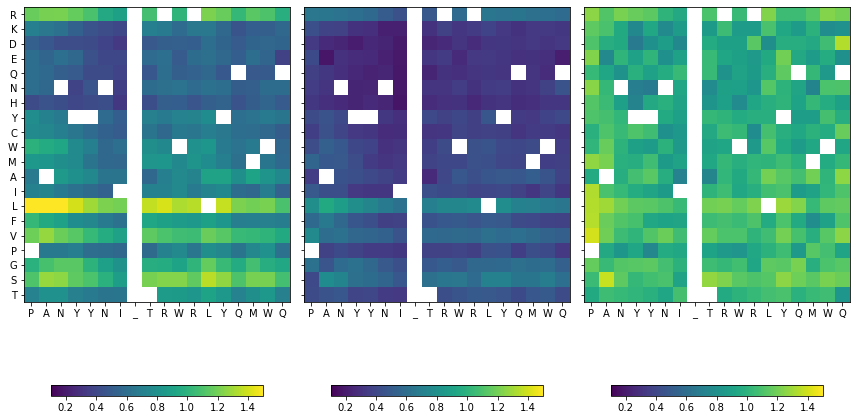

In [442]:
colordict = {'Fn22_1loop':(0.5,2.2),'Fn17_1loop':(0.7,1.6),'Fn22_2loop':(0.1,0.6),'Fn17_2loop':(0.1,1.5)}

    
for exp in explist:
    vmin,vmax = colordict[exp]
    refseq = refdict[exp.rsplit('_')[0]]
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,8))
    for ploti,ax in enumerate(axes.flat):
        #mask
        lib = liblist[ploti+1]
        im = ax.imshow(heatdict[exp][lib],cmap='viridis',vmax=vmax,vmin=vmin)
        ax.set_xticks(np.arange(len(refseq)))
        ax.set_xticklabels(list(refseq))
        ax.set_yticks(np.arange(len(aalist)))
        if ploti == 0:
            ax.set_yticklabels(aalist)
        else:
            ax.set_yticklabels([])
        #bottom, top = ax.get_ylim()
        #ax.set_ylim(bottom + 0.5, top - 0.5)
        fig.colorbar(im, ax=ax,orientation='horizontal',shrink=0.8)
    #fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.savefig('heatmap_normalized_'+exp+'.png',dpi=300)

In [156]:
for lib in liblist:
    print(lib,sum(fdata['Fn17_1loop'][fdata['Fn17_1loop']['seq']==refdict['Fn22']][lib+'_freq']))

Input 0.0001464832927131308
N-lysate 3.792144950948605e-06
N-purified 0.000395699617043252
NP-lysate 5.996831148172229e-05
preclear 4.998981457528028e-06


In [157]:
for lib in liblist:
    print(lib,sum(fdata['Fn22_1loop'][fdata['Fn22_1loop']['seq']==refdict['Fn17']][lib+'_freq']))

Input 0
N-lysate 0
N-purified 0
NP-lysate 0
preclear 0


In [158]:
mdata = {}
for exp in explist:
    mdata[exp] = fdata[exp][fdata[exp]['mutpos'].apply(lambda x:len(x)<=4)]

In [204]:
for exp in explist:
    outfile = open(exp,'w')
    mdata[exp].to_csv(outfile)
    outfile.close()

In [160]:
for exp in explist:
    print(mdata[exp])

          Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  preclear  \
17      PNLWYKV  KRSFWLWSAG    160        48         49          23       144   
28      PRKWYKV  KRSFWSNSAG    109        30         55          17       139   
58      PNLWYKV  QHSFWSNSAG     40         8         12           6        38   
100     PNLWYKV  KRSFWSRFAG     73        21         28          15        84   
171     PNLMWKV  KRSFWSNSAG     89        10         27           4        83   
...         ...         ...    ...       ...        ...         ...       ...   
214499  PNLWYKV  KRPSWSNSAG     93        49         42          17       119   
214513  PNLWYKV  YWSFWSNSAG     40        14         25           6        41   
214642  PNLWYKV  FPSFWSNSAG     97        27         39          18        84   
214665  PNLWYKV  KRSFWSNAKG     71        17         28          14        70   
214801  PAYWYKV  KRSFWSNSAG     71        20         21           6       101   

        Input_freq  N-lysat

In [8]:
mdata[exp]

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
1         PRHYYNI  TRWRLYQLRQ     11         0          0           0   
6         PAISYNI  TRWRSDQMWQ     22        57          0           0   
7         PANYYLD  TLMRLYQMWQ     16         0          0           0   
17        PANYYTV  TRWRLYDVWQ     15         1          0           0   
23        LPNYYNI  TKARLYQMWQ     11        27          0           0   
...           ...         ...    ...       ...        ...         ...   
11776006  *KNYYNI  TRWSLYQMWQ     21         0          0           1   
11776019  YRNYYNI  TRWYAYQMWQ     17         0          0           0   
11776022  PANYYE*  TRWRLYQMDM     15         0          0           1   
11776023  PANYSSI  TRWRGAQMWQ     11         3          0           0   
11776025  PENYYNI  TRWRLYPAWQ     14         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  \
1               30  3.266111e-07   0.000000e+00             0.0   
6               11  6.532221e-07   2.211157e-06             0.0   
7                9  4.750706e-07   0.000000e+00             0.0   
17               1  4.453787e-07   3.879223e-08             0.0   
23              18  3.266111e-07   1.047390e-06             0.0   
...            ...           ...            ...             ...   
11776006        29  6.235302e-07   0.000000e+00             0.0   
11776019        18  5.047625e-07   0.000000e+00             0.0   
11776022         0  4.453787e-07   0.000000e+00             0.0   
11776023        38  3.266111e-07   1.163767e-07             0.0   
11776025         6  4.156868e-07   0.000000e+00             0.0   

          N-purified_freq  preclear_freq  N-lysate_enrich  NP-lysate_enrich  \
1            0.000000e+00   3.683327e-07         0.000000               0.0   
6            0.000000e+00   1.350553e-07         7.069126               0.0   
7            0.000000e+00   1.104998e-07         0.000000               0.0   
17           0.000000e+00   1.227776e-08         0.181896               0.0   
23           0.000000e+00   2.209996e-07         6.697067               0.0   
...                   ...            ...              ...               ...   
11776006     9.345787e-08   3.560550e-07         0.000000               0.0   
11776019     0.000000e+00   2.209996e-07         0.000000               0.0   
11776022     9.345787e-08   0.000000e+00         0.000000               0.0   
11776023     0.000000e+00   4.665548e-07         0.744119               0.0   
11776025     0.000000e+00   7.366655e-08         0.000000               0.0   

          N-purified_enrich  preclear_enrich                 seq  \
1                  0.000000         1.231889  PRHYYNI_TRWRLYQLRQ   
6                  0.000000         0.225846  PAISYNI_TRWRSDQMWQ   
7                  0.000000         0.254077  PANYYLD_TLMRLYQMWQ   
17                 0.000000         0.030113  PANYYTV_TRWRLYDVWQ   
23                 0.000000         0.739133  LPNYYNI_TKARLYQMWQ   
...                     ...              ...                 ...   
11776006           0.173213         0.623766  *KNYYNI_TRWSLYQMWQ   
11776019           0.000000         0.478263  YRNYYNI_TRWYAYQMWQ   
11776022           0.242499         0.000000  PANYYE*_TRWRLYQMDM   
11776023           0.000000         1.560392  PANYSSI_TRWRGAQMWQ   
11776025           0.000000         0.193583  PENYYNI_TRWRLYPAWQ   

                  mutpos  
1         [1, 2, 15, 16]  
6         [2, 3, 12, 13]  
7          [5, 6, 9, 10]  
17        [5, 6, 14, 15]  
23         [0, 1, 9, 10]  
...                  ...  
11776006      [0, 1, 11]  
11776019  [0, 1, 11, 12]  
11776022  [5, 6, 16, 17]  
11776023  [4, 5, 12, 13]  
11776025     [1, 14, 15]  

[1739024 rows x 18 columns]

In [17]:
from tensorflow.keras.utils import to_categorical

In [20]:
exp = 'Fn17_2loop'
maxe = np.log10(max(mdata[exp]['N-lysate_enrich']))
mindict = {'1loop':1e-1,'2loop':1e-3}
mine = mindict[exp.rsplit('_')[-1]]

In [18]:
aalist = ['R','K','D','E','Q','N','H','S','T','Y','C','W','M','A','I','L','F','V','P','G','*']
aadict = {}; aacount = 0
for aa in aalist:
    aadict[aa] = aacount
    aacount += 1
    
def seq2binary(seq):
    binarray = np.zeros(shape=(21,17),dtype=bool)
    pos = 0
    for aa in seq:
        if aa == '_': continue
        binarray[aadict[aa]][pos] = True
        pos += 1
    return binarray.flatten()


In [21]:
def enrich2binary(enrich):
    binlist = np.zeros(shape=10,dtype=bool)
    binlist[int((np.log10(enrich+mine)-np.log10(mine))/(maxe-np.log10(mine))*9)] = True
    return binlist
enrich2binary(10**maxe)

array([False, False, False, False, False, False, False, False, False,
        True])

In [22]:
#maybe change everything into binary data... So there will be no confusion of numeric difference
#sequence 17aa * 21 type = 357 points
#label max(fitness)-min(fitness), divide into 10 categories
input_data = np.array(list([seq2binary(x) for x in mdata[exp]['seq']]))
input_label = np.array(list([enrich2binary(x) for x in mdata[exp]['N-lysate_enrich']]))
#input_label = np.array(list([x for x in mdata[exp]['N-lysate_enrich']]))

In [282]:
input_data0 = input_data[:int(len(input_data)*0.9)]
input_label0 = input_label[:int(len(input_data)*0.9)]
val_data0 = input_data[int(len(input_data)*0.9):]
val_label0 = input_label[int(len(input_data)*0.9):]
val_label1 = list(mdata[exp]['N-lysate_enrich'])[int(len(input_data)*0.9):]

In [307]:
model = tf.keras.Sequential([
# Adds a densely-connected layer with 64 units to the model:
layers.Dense(128, activation='relu', input_shape=(357,)),
# Add another:
layers.Dense(64, activation='relu'),
# Add an output layer with 10 output units:
layers.Dense(10)])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['accuracy'])


In [312]:
model.fit(input_data0, input_label0, epochs=10, batch_size=32)

Train on 5711 samples
Epoch 1/10
5711/5711 [==============================] - 1s 161us/sample - loss: 0.0605 - accuracy: 0.5470
Epoch 2/10
5711/5711 [==============================] - 1s 113us/sample - loss: 0.0564 - accuracy: 0.5729
Epoch 3/10
5711/5711 [==============================] - 1s 111us/sample - loss: 0.0552 - accuracy: 0.5868
Epoch 4/10
4288/5711 [=====================>........] - ETA: 0s - loss: 0.0546 - accuracy: 0.5882

KeyboardInterrupt: 

In [30]:
def cat2value(catarrays):
    valuelist = []
    for array in catarrays:
        fit = 0
        for i in range(len(array)):
            fit += array[i] * i
        valuelist.append(fit)
    return valuelist

In [292]:
result = model.predict(val_data0, batch_size=32)
#resultv = cat2value(result)
#val_labelv = cat2value(val_label0)

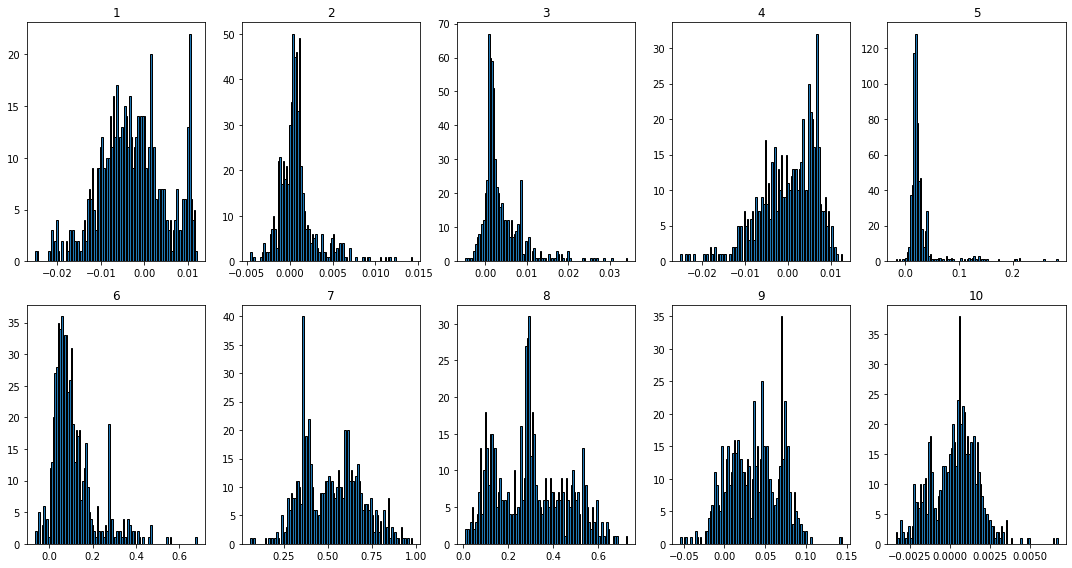

In [256]:
plt.figure(figsize=(15,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist([x[i] for x in result],bins=100,edgecolor='black')
    plt.title(str(i+1))
plt.tight_layout()

<BarContainer object of 10 artists>

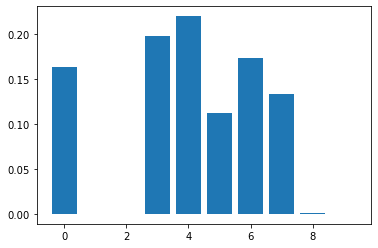

In [236]:
plt.bar(range(10),result[4])

In [239]:
len(resultv),len([x for x in resultv if x == 4.0147521368216985])

(173903, 10324)

In [240]:
list(mdata[exp]['seq'])[int(len(input_data)*0.9):]

['PGLYYNI_TRWMAYQMWQ',
 'PANKWNI_TRWRLGPMWQ',
 'PANYCTI_TRWRWVQMWQ',
 'PAEEYNI_TRWRLYQMSV',
 'PLSYYNI_TRVALYQMWQ',
 'LLNYYNI_YSWRLYQMWQ',
 'PANYVGI_TRWRLMWMWQ',
 'PANPGNI_TWSRLYQMWQ',
 'PANYYIS_TRWSFYQMWQ',
 '*LNYYNI_TRWRLYIFWQ',
 'PANYGAI_TRWINYQMWQ',
 'PAALYNI_TRWRLYQTMQ',
 'PANM*NI_TRWRLSVMWQ',
 'PANYMRI_TRRNLYQMWQ',
 'PAAGYNI_PVWRLYQMWQ',
 'PANYYRH_TRLRLYQMWQ',
 'MLNYYNI_TRWRL*LMWQ',
 'WYNYYNI_TRWAPYQMWQ',
 'PMLYYNI_TGRRLYQMWQ',
 'PALPYNI_TRWRLASMWQ',
 'PALTYNI_TRWRRWQMWQ',
 'PANGNNI_TRWCIYQMWQ',
 'P*RYYNI_TLKRLYQMWQ',
 'PANYVVI_TRWRYKQMWQ',
 'PAVGYNI_TRWRLDLMWQ',
 'PANCRNI_TRWFSYQMWQ',
 'ELNYYNI_TRWRAYQMWQ',
 'PANYKEI_TRWRLYQMK*',
 'PVLYYNI_KQWRLYQMWQ',
 'SMNYYNI_GQWRLYQMWQ',
 'PANYLSI_TRWRNCQMWQ',
 'PSHYYNI_TRCVLYQMWQ',
 'ARNYYNI_WGWRLYQMWQ',
 'GLNYYNI_TRCELYQMWQ',
 'PANYTCI_TRWRLNVMWQ',
 'PANYTEI_TRWRLNLMWQ',
 'PETYYNI_TRWRYDQMWQ',
 'PANYYPA_TRWAVYQMWQ',
 'PANY*II_TRWRLSYMWQ',
 'PKGYYNI_TRNRLYQMWQ',
 'PANYYYF_TRWRLYQCSQ',
 'PANYSNI_YVWRLYQMWQ',
 'PANIQNI_TRWRKNQMWQ',
 'PANYYII_T

In [31]:
from scipy.stats import pearsonr

SpearmanrResult(correlation=0.3843303322989618, pvalue=0.0)

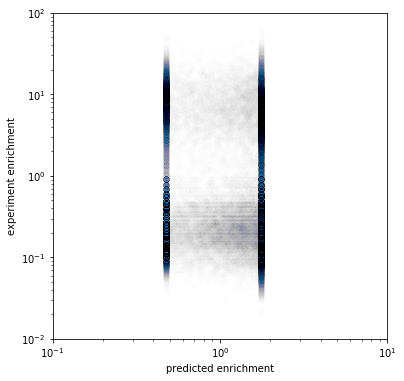

In [298]:
plt.figure(figsize=(6,6))
plt.scatter(result,val_label0,alpha=0.002,edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,10])
plt.ylim([1e-2,1e2])
plt.xlabel('predicted enrichment')
plt.ylabel('experiment enrichment')
spearmanr(result,val_label0)

In [289]:
len(result),len([x for x in result if x == 0.33629376])

(173903, 70638)

In [206]:
[to_categorical(x) for x in mdata['Fn17_1loop']['N-lysate_enrich']]

[array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0., 1.], dtype=fl

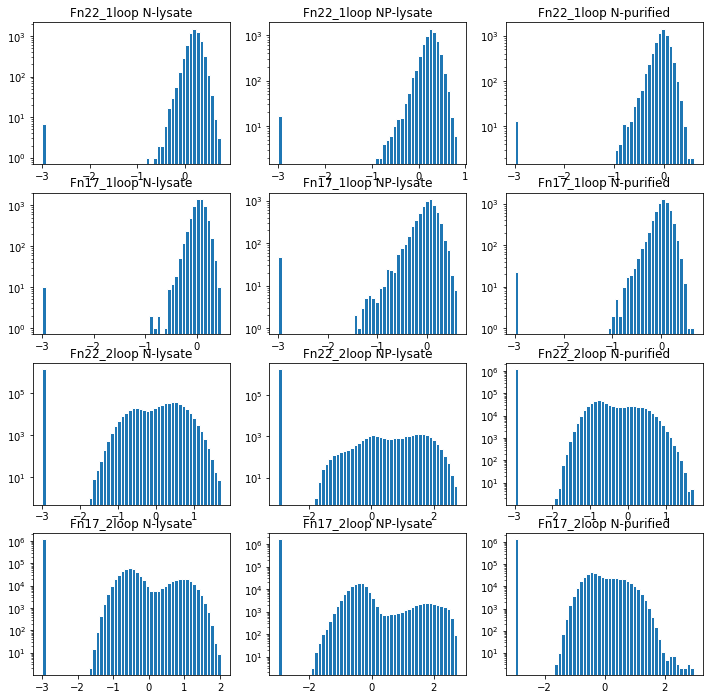

In [71]:
plt.figure(figsize=(12,12))
ploti = 0
for exp in explist:
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(4,3,ploti)
        plt.hist(np.log10(mdata[exp][lib+'_enrich2']+0.001),bins=50,edgecolor='white')
        plt.title(exp+' '+lib)
        plt.yscale('log')

In [33]:
from functools import partial
def run_ML(input_data0,input_label0,val_data0):
    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 64 units to the model:
    layers.Dense(357, activation=partial(tf.nn.leaky_relu, alpha=0.2), input_shape=(357,)),
    # Add another:
    layers.Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.2)),
    layers.Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.2)),
    # Add an output layer with 10 output units:
    layers.Dense(10)])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss='mse',
                  metrics=['accuracy'])
    
    model.fit(input_data0, input_label0, epochs=10, batch_size=32)
    
    result = model.predict(val_data0, batch_size=32)
    return result

Train on 5711 samples
Epoch 1/10
5711/5711 [==============================] - 1s 204us/sample - loss: 0.0649 - accuracy: 0.5528
Epoch 2/10
5711/5711 [==============================] - 1s 166us/sample - loss: 0.0571 - accuracy: 0.5747
Epoch 3/10
5711/5711 [==============================] - 1s 127us/sample - loss: 0.0556 - accuracy: 0.5756
Epoch 4/10
5711/5711 [==============================] - 1s 135us/sample - loss: 0.0549 - accuracy: 0.5847
Epoch 5/10
5711/5711 [==============================] - 1s 119us/sample - loss: 0.0543 - accuracy: 0.5922
Epoch 6/10
5711/5711 [==============================] - 1s 109us/sample - loss: 0.0535 - accuracy: 0.5938
Epoch 7/10
5711/5711 [==============================] - 1s 118us/sample - loss: 0.0530 - accuracy: 0.5973
Epoch 8/10
5711/5711 [==============================] - 1s 120us/sample - loss: 0.0521 - accuracy: 0.6055
Epoch 9/10
5711/5711 [==============================] - 1s 117us/sample - loss: 0.0524 - accuracy: 0.6057
Epoch 10/10
5711/5711 [=

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 5713 samples
Epoch 1/10
5713/5713 [==============================] - 1s 183us/sample - loss: 0.0763 - accuracy: 0.3457
Epoch 2/10
5713/5713 [==============================] - 1s 114us/sample - loss: 0.0726 - accuracy: 0.3592
Epoch 3/10
5713/5713 [==============================] - 1s 120us/sample - loss: 0.0722 - accuracy: 0.3788
Epoch 4/10
5713/5713 [==============================] - 1s 123us/sample - loss: 0.0718 - accuracy: 0.3727
Epoch 5/10
5713/5713 [==============================] - 1s 118us/sample - loss: 0.0714 - accuracy: 0.3902
Epoch 6/10
5713/5713 [==============================] - 1s 142us/sample - loss: 0.0712 - accuracy: 0.3893
Epoch 7/10
5713/5713 [==============================] - 1s 173us/sample - loss: 0.0710 - accuracy: 0.3949
Epoch 8/10
5713/5713 [==============================] - 1s 181us/sample - loss: 0.0712 - accuracy: 0.3961
Epoch 9/10
5713/5713 [==============================] - 1s 156us/sample - loss: 0.0710 - accuracy: 0.4008
Epoch 10/10
5713/5713 [=

1565121/1565121 [==============================] - 178s 114us/sample - loss: 0.0454 - accuracy: 0.7483
Epoch 3/10
1565121/1565121 [==============================] - 176s 112us/sample - loss: 0.1561 - accuracy: 0.7436
Epoch 4/10
1565121/1565121 [==============================] - 178s 114us/sample - loss: 0.0888 - accuracy: 0.7459
Epoch 5/10
1565121/1565121 [==============================] - 178s 113us/sample - loss: 0.0713 - accuracy: 0.7453
Epoch 6/10
1565121/1565121 [==============================] - 179s 114us/sample - loss: 0.1243 - accuracy: 0.7431
Epoch 7/10
1565121/1565121 [==============================] - 175s 112us/sample - loss: 0.0797 - accuracy: 0.7454
Epoch 8/10
1565121/1565121 [==============================] - 176s 113us/sample - loss: 0.0937 - accuracy: 0.7429
Epoch 9/10
1565121/1565121 [==============================] - 177s 113us/sample - loss: 0.0994 - accuracy: 0.7434
Epoch 10/10
1565121/1565121 [==============================] - 179s 115us/sample - loss: 0.0752 - a

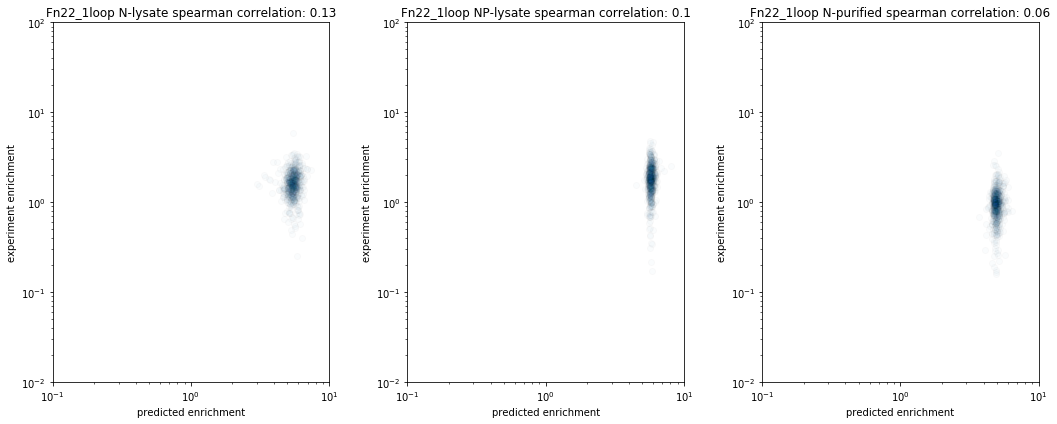

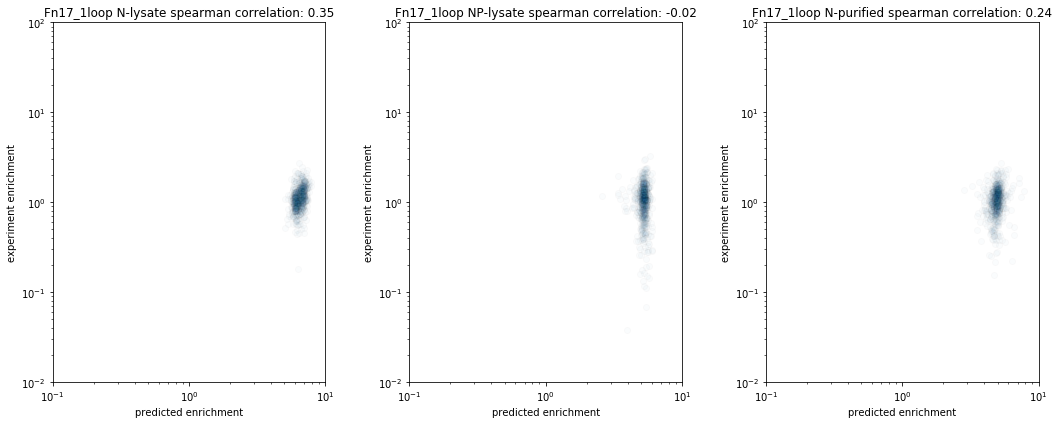

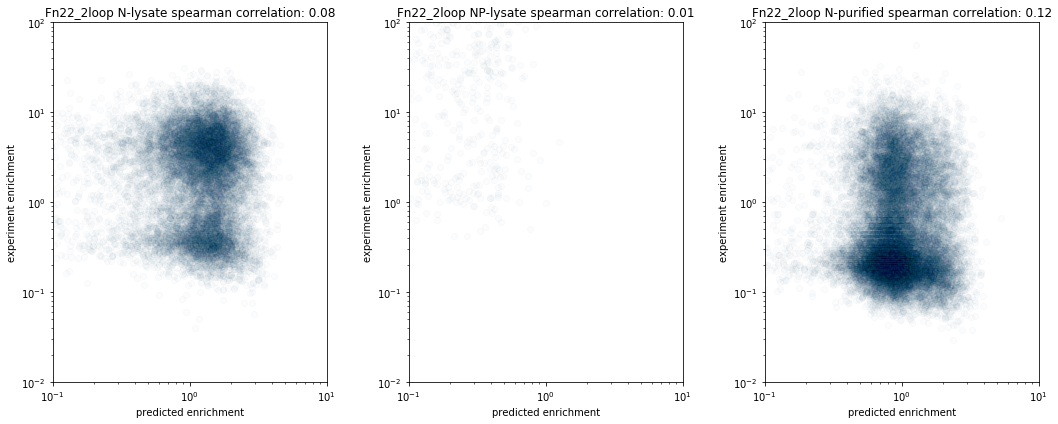

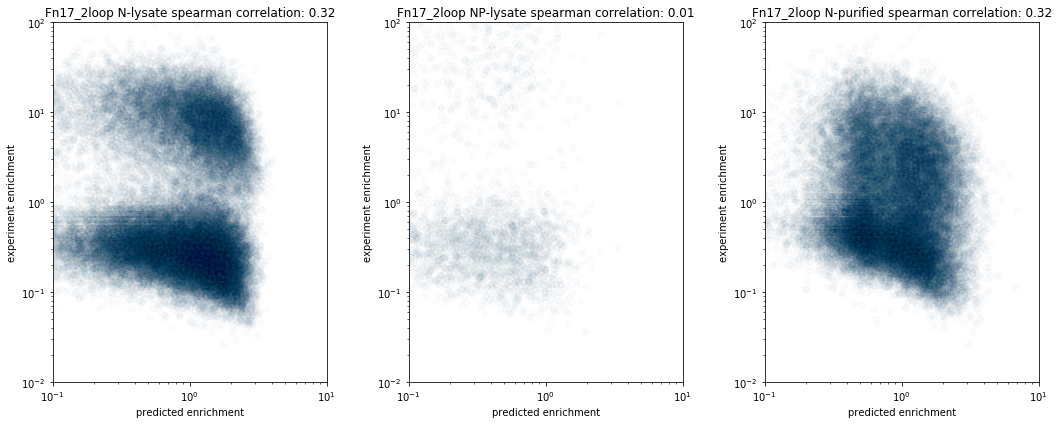

In [67]:
for exp in explist:
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        maxe = np.log10(max(mdata[exp][lib+'_enrich2']))
        mine = mindict[exp.rsplit('_')[-1]]
        input_data = np.array(list([seq2binary(x) for x in mdata[exp]['seq']]))
        input_label = np.array(list([enrich2binary(x) for x in mdata[exp][lib+'_enrich2']]))
        #input_label = np.array(list([x for x in mdata[exp]['N-lysate_enrich']]))
        input_data0 = input_data[:int(len(input_data)*0.9)]
        input_label0 = input_label[:int(len(input_data)*0.9)]
        val_data0 = input_data[int(len(input_data)*0.9):]
        val_label0 = input_label[int(len(input_data)*0.9):]
        val_label1 = list(mdata[exp][lib+'_enrich2'])[int(len(input_data)*0.9):]

        result = run_ML(input_data0,input_label0,input_data)
        mdata[exp][lib+'_predict3'] = cat2value(result)
        
        resultv = cat2value(result[int(len(input_data)*0.9):])
        plt.subplot(1,3,ploti)
        plt.scatter(resultv,val_label1,alpha=0.02,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1e-1,10])
        plt.ylim([1e-2,1e2])
        plt.xlabel('predicted enrichment')
        plt.ylabel('experiment enrichment')
        plt.title(exp+' '+lib+' spearman correlation: '+str(round(spearmanr(resultv,val_label1)[0],2)))
    plt.tight_layout()
        #spearmanr(resultv,val_label1)

ML model 1:

3 layer. 128 relu; 64 relu; 10. categorical output


Model 2:

4 Layer. 357 leaky_relu; 64 leaky_relu; 64 leaky_relu; 10. categorical output

Model 3:

Same model as model 2, but use enrich2 as input. (enrichment normalized to the sum of input and preclear) 

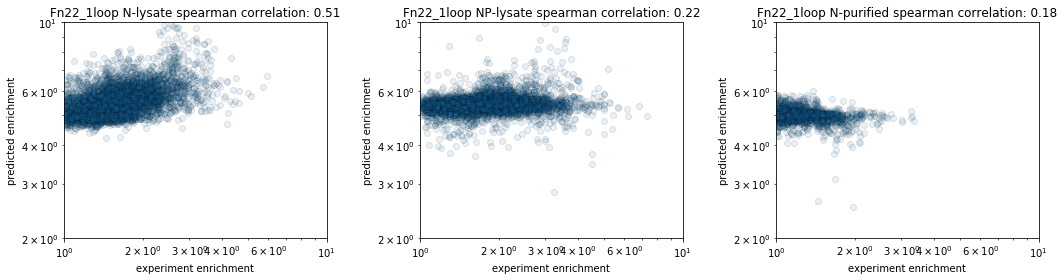

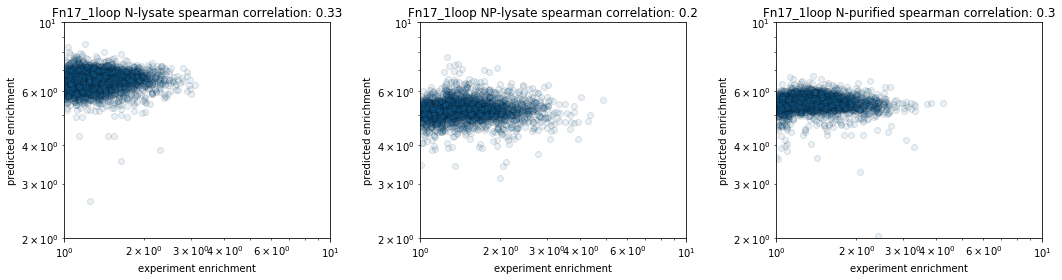

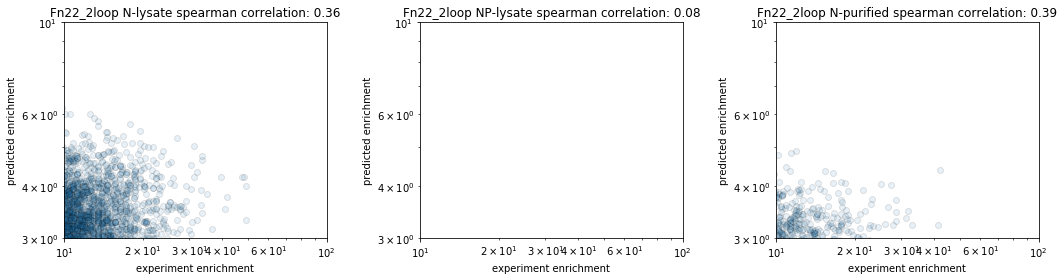

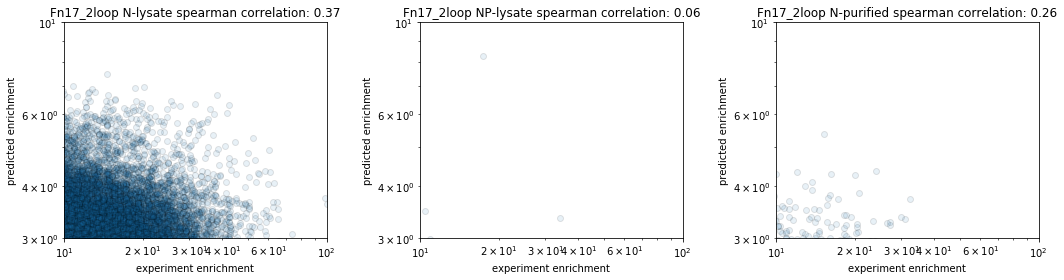

In [61]:
for exp in explist:
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(1,3,ploti)
        plt.scatter(mdata[exp][(mdata[exp][lib+'_enrich']>1) & (mdata[exp][lib+'_predict2']>1)][lib+'_enrich'],mdata[exp][(mdata[exp][lib+'_enrich']>1) & (mdata[exp][lib+'_predict2']>1)][lib+'_predict2'],alpha=0.1,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        if '1loop' in exp:
            plt.xlim([1,1e1])
            plt.ylim([2,1e1])
        else:
            plt.xlim([10,1e2])
            plt.ylim([3,1e1])
        plt.xlabel('experiment enrichment')
        plt.ylabel('predicted enrichment')
        plt.title(exp+' '+lib+' spearman correlation: '+str(round(spearmanr(mdata[exp][lib+'_enrich'],mdata[exp][lib+'_predict2'])[0],2)))
    plt.tight_layout()
    plt.savefig('ANN_correlation_'+exp+'.png')

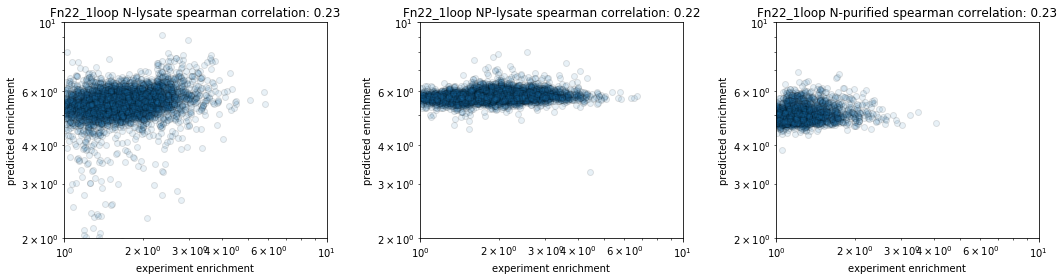

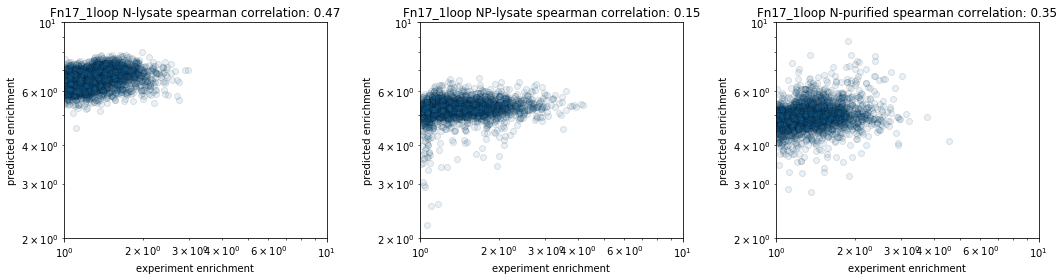

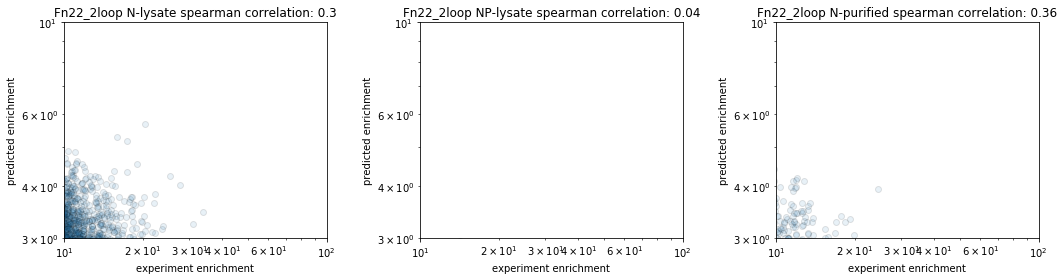

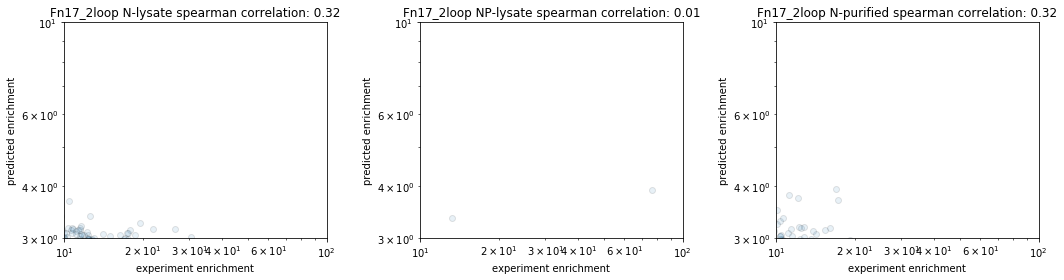

In [72]:
for exp in explist:
    plt.figure(figsize=(15,4))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(1,3,ploti)
        plt.scatter(mdata[exp][(mdata[exp][lib+'_enrich2']>1) & (mdata[exp][lib+'_predict3']>1)][lib+'_enrich2'],mdata[exp][(mdata[exp][lib+'_enrich2']>1) & (mdata[exp][lib+'_predict3']>1)][lib+'_predict3'],alpha=0.1,edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        if '1loop' in exp:
            plt.xlim([1,1e1])
            plt.ylim([2,1e1])
        else:
            plt.xlim([10,1e2])
            plt.ylim([3,1e1])
        plt.xlabel('experiment enrichment')
        plt.ylabel('predicted enrichment')
        plt.title(exp+' '+lib+' spearman correlation: '+str(round(spearmanr(mdata[exp][lib+'_enrich2'],mdata[exp][lib+'_predict3'])[0],2)))
    plt.tight_layout()
    plt.savefig('ANN_correlation_'+exp+'.png')

In [318]:
input_data.shape

(6346, 357)

In [319]:
result.shape

(635, 10)

In [322]:
mdata[exp]

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
1         PRHYYNI  TRWRLYQLRQ     11         0          0           0   
6         PAISYNI  TRWRSDQMWQ     22        57          0           0   
7         PANYYLD  TLMRLYQMWQ     16         0          0           0   
17        PANYYTV  TRWRLYDVWQ     15         1          0           0   
23        LPNYYNI  TKARLYQMWQ     11        27          0           0   
...           ...         ...    ...       ...        ...         ...   
11776006  *KNYYNI  TRWSLYQMWQ     21         0          0           1   
11776019  YRNYYNI  TRWYAYQMWQ     17         0          0           0   
11776022  PANYYE*  TRWRLYQMDM     15         0          0           1   
11776023  PANYSSI  TRWRGAQMWQ     11         3          0           0   
11776025  PENYYNI  TRWRLYPAWQ     14         0          0           0   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
1               30  3.266111e-07   0.000000e+00             0.0  ...   
6               11  6.532221e-07   2.211157e-06             0.0  ...   
7                9  4.750706e-07   0.000000e+00             0.0  ...   
17               1  4.453787e-07   3.879223e-08             0.0  ...   
23              18  3.266111e-07   1.047390e-06             0.0  ...   
...            ...           ...            ...             ...  ...   
11776006        29  6.235302e-07   0.000000e+00             0.0  ...   
11776019        18  5.047625e-07   0.000000e+00             0.0  ...   
11776022         0  4.453787e-07   0.000000e+00             0.0  ...   
11776023        38  3.266111e-07   1.163767e-07             0.0  ...   
11776025         6  4.156868e-07   0.000000e+00             0.0  ...   

          preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
1          3.683327e-07         0.000000               0.0           0.000000   
6          1.350553e-07         7.069126               0.0           0.000000   
7          1.104998e-07         0.000000               0.0           0.000000   
17         1.227776e-08         0.181896               0.0           0.000000   
23         2.209996e-07         6.697067               0.0           0.000000   
...                 ...              ...               ...                ...   
11776006   3.560550e-07         0.000000               0.0           0.173213   
11776019   2.209996e-07         0.000000               0.0           0.000000   
11776022   0.000000e+00         0.000000               0.0           0.242499   
11776023   4.665548e-07         0.744119               0.0           0.000000   
11776025   7.366655e-08         0.000000               0.0           0.000000   

          preclear_enrich                 seq          mutpos  \
1                1.231889  PRHYYNI_TRWRLYQLRQ  [1, 2, 15, 16]   
6                0.225846  PAISYNI_TRWRSDQMWQ  [2, 3, 12, 13]   
7                0.254077  PANYYLD_TLMRLYQMWQ   [5, 6, 9, 10]   
17               0.030113  PANYYTV_TRWRLYDVWQ  [5, 6, 14, 15]   
23               0.739133  LPNYYNI_TKARLYQMWQ   [0, 1, 9, 10]   
...                   ...                 ...             ...   
11776006         0.623766  *KNYYNI_TRWSLYQMWQ      [0, 1, 11]   
11776019         0.478263  YRNYYNI_TRWYAYQMWQ  [0, 1, 11, 12]   
11776022         0.000000  PANYYE*_TRWRLYQMDM  [5, 6, 16, 17]   
11776023         1.560392  PANYSSI_TRWRGAQMWQ  [4, 5, 12, 13]   
11776025         0.193583  PENYYNI_TRWRLYPAWQ     [1, 14, 15]   

         N-lysate_predict  NP-lysate_predict  N-purified_predict  
1                1.704917           0.257901            1.537130  
6                1.313743           0.257901            0.730171  
7                1.428324           0.257901            0.993136  
17               0.945065           0.257901            0.509376  
23               1.285618           0.257901            0.651112  
...                   ...                ...                 ...  
11776006         2.006415           0.257901   

In [324]:
clist = {}
for exp in ['Fn17_2loop','Fn22_2loop']:
    clist[exp] = mdata[exp][((mdata[exp]['N-lysate_enrich']>10) & (mdata[exp]['N-purified_enrich']>10) & (mdata[exp]['NP-lysate_enrich'] < 1)) | 
                            ((mdata[exp]['NP-lysate_enrich'] < 1) & ( ((mdata[exp]['N-purified_enrich']>80) & (mdata[exp]['N-lysate_enrich']>5)) | ((mdata[exp]['N-purified_enrich']>5) & (mdata[exp]['N-lysate_enrich']>80))   ))]
    
    
#(N_purify, N_lysate >10 and NP_lysate <1) or (maxenrich_N>80 and minenrich_N>5 and NP_lysate <1)

In [338]:
mask = {}
for exp in ['Fn17_1loop','Fn22_1loop']:
    mask[exp] = mdata[exp][((mdata[exp]['N-lysate_enrich']>1)|(mdata[exp]['N-purified_enrich']>1)) & ((mdata[exp]['N-lysate_enrich']>mdata[exp]['NP-lysate_enrich'])|(mdata[exp]['N-purified_enrich']>mdata[exp]['NP-lysate_enrich']))]
    

In [351]:
tdict = {}
for exp in ['Fn17_2loop','Fn22_2loop']:
    tdict[exp] = clist[exp][ (clist[exp]['Loop1'].isin(list(mask[exp.replace('2loop','1loop')]['Loop1']))) & (clist[exp]['Loop2'].isin(list(mask[exp.replace('2loop','1loop')]['Loop2']))) & (clist[exp]['preclear_enrich']<10)]

In [358]:
fn17round1 = ['PSLYYNI_TRWRLYQAGQ',
'GINYYNI_TRWLGYQMWQ',
'PASRYNI_TRWRLARMWQ',
'VVNYYNI_TRGLLYQMWQ',
'PANRPNI_TSLRLYQMWQ',
'PANYSPI_TRWRLYQTSQ',
'GKNYYNI_TVWRLYQMWQ',
'PSLYYNI_TRWRLYQMVF',
'PANGVNI_TRWRLYQNGQ',
'PANRLNI_TRWRLYSVWQ']
for seq in fn17round1:
    print(seq, seq in list(tdict['Fn17_2loop']['seq']))

PSLYYNI_TRWRLYQAGQ True
GINYYNI_TRWLGYQMWQ True
PASRYNI_TRWRLARMWQ True
VVNYYNI_TRGLLYQMWQ True
PANRPNI_TSLRLYQMWQ True
PANYSPI_TRWRLYQTSQ True
GKNYYNI_TVWRLYQMWQ True
PSLYYNI_TRWRLYQMVF True
PANGVNI_TRWRLYQNGQ True
PANRLNI_TRWRLYSVWQ True


In [360]:
fn22round1 = ['PNLWSRV_KRSFWSNLAG',
'PNLKTKV_KRSFWSLSAG']

In [380]:
r2dict = {}
for exp in ['Fn17_2loop','Fn22_2loop']:
    r2dict[exp] = tdict[exp][(tdict[exp]['N-lysate_predict']>np.quantile(mdata[exp]['N-lysate_predict'],0.9)) & (tdict[exp]['N-purified_predict']>np.quantile(mdata[exp]['N-purified_predict'],0.9))]

In [381]:
for exp in r2dict:
    print(exp,r2dict[exp].shape)

Fn17_2loop (228, 21)
Fn22_2loop (4, 21)


In [382]:
r2dict['Fn17_2loop'].sort_values(by='N-purified_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
7062149  PSLYYNI  TRWRLYQAGQ      6       111          0          83   
4160958  PANYYRL  T*LRLYQMWQ      6        47          1          78   
4797169  LSNYYNI  TRWRLYQLDQ      6       109          0          68   
9407433  PLLYYNI  TRWRLYQNLQ      8        71          0          88   
4322543  VFNYYNI  TRWRLYQARQ     10        76          0         109   
...          ...         ...    ...       ...        ...         ...   
4342436  PARRYNI  TRLVLYQMWQ      9        50          0          25   
9290726  GLNYYNI  TRWRLTRMWQ      8        47          0          22   
7878728  LLNYYNI  TRWRW*QMWQ      8        43          0          22   
4861432  RVNYYNI  TRWRLSSMWQ     12       111          0          33   
9758134  PFLYYNI  TRWRLYQASQ      6       221          0          10   

         preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
7062149        86  1.781515e-07       0.000004    0.000000e+00  ...   
4160958        59  1.781515e-07       0.000002    1.103781e-07  ...   
4797169        52  1.781515e-07       0.000004    0.000000e+00  ...   
9407433       117  2.375353e-07       0.000003    0.000000e+00  ...   
4322543        42  2.969191e-07       0.000003    0.000000e+00  ...   
...           ...           ...            ...             ...  ...   
4342436        58  2.672272e-07       0.000002    0.000000e+00  ...   
9290726        22  2.375353e-07       0.000002    0.000000e+00  ...   
7878728       100  2.375353e-07       0.000002    0.000000e+00  ...   
4861432        74  3.563030e-07       0.000004    0.000000e+00  ...   
9758134        66  1.781515e-07       0.000009    0.000000e+00  ...   

         preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
7062149   1.055887e-06        50.476038          0.000000          50.318504   
4160958   7.243877e-07        21.372737          0.767525          47.287269   
4797169   6.384434e-07        49.566560          0.000000          41.224799   
9407433   1.436498e-06        24.214856          0.000000          40.012305   
4322543   5.156658e-07        20.736102          0.000000          39.648557   
...                ...              ...               ...                ...   
4342436   7.121100e-07        15.157969          0.000000          10.104117   
9290726   2.701107e-07        16.029553          0.000000          10.003076   
7878728   1.227776e-06        14.665335          0.000000          10.003076   
4861432   9.085541e-07        25.238019          0.000000          10.003076   
9758134   8.103320e-07       100.497338          0.000000           6.062470   

         preclear_enrich                 seq          mutpos N-lysate_predict  \
7062149         6.474260  PSLYYNI_TRWRLYQAGQ  [1, 2, 15, 16]         3.367359   
4160958         4.441643  PANYYRL_T*LRLYQMWQ   [5, 6, 9, 10]         3.325593   
4797169         3.914669  LSNYYNI_TRWRLYQLDQ  [0, 1, 15, 16]         3.367359   
9407433         6.606003  PLLYYNI_TRWRLYQNLQ  [1, 2, 15, 16]         3.367359   
4322543         1.897109  VFNYYNI_TRWRLYQARQ  [0, 1, 15, 16]         3.367359   
...                  ...                 ...             ...              ...   
4342436         2.910907  PARRYNI_TRLVLYQMWQ  [2, 3, 10, 11]         3.367359   
9290726         1.242154  GLNYYNI_TRWRLTRMWQ  [0, 1, 13, 14]         3.178311   
7878728         5.646157  LLNYYNI_TRWRW*QMWQ  [0, 1, 12, 13]         3.304704   
4861432         2.785437  RVNYYNI_TRWRLSSMWQ  [0, 1, 13, 14]         3.367359   
9758134         4.968618  PFLYYNI_TRWRLYQASQ  [1, 2, 15, 16]         3.367359   

         NP-lysate_predict  N-purified_predict  
7062149           0.932726            2.325125  
4160958           0.257901            2.311251  
4797169           0.932726            2.325125  
9407433           0.932726            2.325125  
4322543           0.257901            2.022623  
...                    ...                 ...  
4342436         

In [383]:
r2dict['Fn22_2loop'].sort_values(by='N-purified_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
2462844  PNLWSRV  KRSFWSNLAG    6.0      35.0        0.0        47.0   
421768   PNLWYLS  KRSFWSNVTG    6.0      17.0        0.0        44.0   
574147   PNLTSKV  KRSFRLNSAG    8.0      29.0        0.0        50.0   
123707   PNLKTKV  KRSFWSLSAG    7.0      17.0        0.0        38.0   

         preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
2462844      49.0  1.178783e-07       0.000003             0.0  ...   
421768       45.0  1.178783e-07       0.000001             0.0  ...   
574147       28.0  1.571711e-07       0.000002             0.0  ...   
123707       25.0  1.375247e-07       0.000001             0.0  ...   

         preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
2462844   8.822901e-07        26.084393               0.0          17.655952   
421768    8.102664e-07        12.669562               0.0          16.528976   
574147    5.041658e-07        16.209587               0.0          14.087196   
123707    4.501480e-07        10.859625               0.0          12.235736   

         preclear_enrich                 seq          mutpos N-lysate_predict  \
2462844         7.929233  PNLWSRV_KRSFWSNLAG      [4, 5, 15]         3.942222   
421768          7.281949  PNLWYLS_KRSFWSNVTG  [5, 6, 15, 16]         3.942222   
574147          3.398243  PNLTSKV_KRSFRLNSAG  [3, 4, 12, 13]         3.359985   
123707          3.467595  PNLKTKV_KRSFWSLSAG      [3, 4, 14]         3.692911   

         NP-lysate_predict  N-purified_predict  
2462844           0.056081            3.965614  
421768            0.056081            3.449145  
574147            0.056081            3.196859  
123707            0.056081            3.090507  

[4 rows x 21 columns]

In [400]:
r2hits = {}
for exp in ['Fn17_2loop','Fn22_2loop']:
    r2hits[exp] = pd.DataFrame(columns=r2dict[exp].columns)
    seqcount = 0
    for record in r2dict[exp].sort_values(by='N-purified_enrich',ascending=False).index:
        if r2dict[exp]['seq'][record] not in fn22round1: 
            seqcount += 1
            print(exp,r2dict[exp]['seq'][record])
            r2hits[exp] = r2hits[exp].append(r2dict[exp].loc[record])
        if seqcount == 5: break

Fn17_2loop PSLYYNI_TRWRLYQAGQ
Fn17_2loop PANYYRL_T*LRLYQMWQ
Fn17_2loop LSNYYNI_TRWRLYQLDQ
Fn17_2loop PLLYYNI_TRWRLYQNLQ
Fn17_2loop VFNYYNI_TRWRLYQARQ
Fn22_2loop PNLWYLS_KRSFWSNVTG
Fn22_2loop PNLTSKV_KRSFRLNSAG


In [403]:
r2hits['Fn17_2loop']['seq']

7062149    PSLYYNI_TRWRLYQAGQ
4160958    PANYYRL_T*LRLYQMWQ
4797169    LSNYYNI_TRWRLYQLDQ
9407433    PLLYYNI_TRWRLYQNLQ
4322543    VFNYYNI_TRWRLYQARQ
Name: seq, dtype: object

In [373]:
tdict[exp]['N-purified_predict']>np.quantile(mdata[exp]['N-purified_predict'],0.75)

29451       False
53533        True
60413       False
72132       False
81880       False
            ...  
11633757    False
11637333     True
11655533     True
11751352    False
11757396    False
Name: N-purified_predict, Length: 557, dtype: bool

In [357]:
'LRLWYKV_KRSFWSNSGG' in list(tdict['Fn22_2loop']['seq'])

False

In [352]:
tdict['Fn22_2loop'].sort_values(by='N-purified_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
1130910  PNALYKV  KRSFWFFSAG    6.0      20.0        0.0        53.0   
2462844  PNLWSRV  KRSFWSNLAG    6.0      35.0        0.0        47.0   
421768   PNLWYLS  KRSFWSNVTG    6.0      17.0        0.0        44.0   
64579    AMLWYKV  KRSFWSSLAG   11.0      27.0        0.0        77.0   
74577    YSLWYKV  KRSFWSKYAG    7.0      16.0        0.0        47.0   
574147   PNLTSKV  KRSFRLNSAG    8.0      29.0        0.0        50.0   
7743874  PNKAYKV  KRSFWSFSAG    7.0      23.0        0.0        42.0   
123707   PNLKTKV  KRSFWSLSAG    7.0      17.0        0.0        38.0   
2322670  PNLWYAW  KRSFWSNSRL   11.0      32.0        0.0        59.0   
7264432  PNLVLKV  KRSFWSNNCG    8.0      26.0        0.0        40.0   

         preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
1130910      39.0  1.178783e-07       0.000001             0.0  ...   
2462844      49.0  1.178783e-07       0.000003             0.0  ...   
421768       45.0  1.178783e-07       0.000001             0.0  ...   
64579        21.0  2.161102e-07       0.000002             0.0  ...   
74577        15.0  1.375247e-07       0.000001             0.0  ...   
574147       28.0  1.571711e-07       0.000002             0.0  ...   
7743874      21.0  1.375247e-07       0.000002             0.0  ...   
123707       25.0  1.375247e-07       0.000001             0.0  ...   
2322670      53.0  2.161102e-07       0.000002             0.0  ...   
7264432      10.0  1.571711e-07       0.000002             0.0  ...   

         preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
1130910   7.022309e-07        14.905367               0.0          19.909903   
2462844   8.822901e-07        26.084393               0.0          17.655952   
421768    8.102664e-07        12.669562               0.0          16.528976   
64579     3.781243e-07        10.975770               0.0          15.777659   
74577     2.700888e-07        10.220823               0.0          15.133673   
574147    5.041658e-07        16.209587               0.0          14.087196   
7743874   3.781243e-07        14.692433               0.0          13.523708   
123707    4.501480e-07        10.859625               0.0          12.235736   
2322670   9.543138e-07        13.008320               0.0          12.089375   
7264432   1.800592e-07        14.532733               0.0          11.269757   

         preclear_enrich                 seq          mutpos N-lysate_predict  \
1130910         6.311022  PNALYKV_KRSFWFFSAG  [2, 3, 13, 14]         1.890547   
2462844         7.929233  PNLWSRV_KRSFWSNLAG      [4, 5, 15]         3.942222   
421768          7.281949  PNLWYLS_KRSFWSNVTG  [5, 6, 15, 16]         3.942222   
64579           1.853587  AMLWYKV_KRSFWSSLAG  [0, 1, 14, 15]         2.749800   
74577           2.080557  YSLWYKV_KRSFWSKYAG  [0, 1, 14, 15]         1.475465   
574147          3.398243  PNLTSKV_KRSFRLNSAG  [3, 4, 12, 13]         3.359985   
7743874         2.912779  PNKAYKV_KRSFWSFSAG      [2, 3, 14]         1.557974   
123707          3.467595  PNLKTKV_KRSFWSLSAG      [3, 4, 14]         3.692911   
2322670         4.678100  PNLWYAW_KRSFWSNSRL  [5, 6, 16, 17]         1.836790   
7264432         1.213658  PNLVLKV_KRSFWSNNCG  [3, 4, 15, 16]         1.283542   

         NP-lysate_predict  N-purified_predict  
1130910           0.056081            2.297937  
2462844           0.056081            3.965614  
421768            0.056081            3.449145  
64579             0.056081            2.671950  
74577             0.056081            1.604629  
574147            0.056081            3.196859  
7743874           0.056081            2.015874  
123707            0.056081            3.090507  
2322670           0.056081            2.230594  
7264432           0.056081            1.601037  

[10 rows x 21 columns]

In [359]:
tdict['Fn17_2loop'].sort_values(by='N-purified_enrich',ascending=False)

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
11151427  PFIYYNI  LFWRLYQMWQ      6        13          1         596   
7062149   PSLYYNI  TRWRLYQAGQ      6       111          0          83   
4160958   PANYYRL  T*LRLYQMWQ      6        47          1          78   
2992526   PANYYNI  TRWQGYQMWQ      6        83          1          69   
4797169   LSNYYNI  TRWRLYQLDQ      6       109          0          68   
...           ...         ...    ...       ...        ...         ...   
4861432   RVNYYNI  TRWRLSSMWQ     12       111          0          33   
8645152   PAIGYNI  TRWRLYRRWQ      8        41          0          22   
9290726   GLNYYNI  TRWRLTRMWQ      8        47          0          22   
1584646   PAPRYNI  TRWRPRQMWQ      8        53          0          22   
9758134   PFLYYNI  TRWRLYQASQ      6       221          0          10   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
11151427        44  1.781515e-07   5.042991e-07    1.103781e-07  ...   
7062149         86  1.781515e-07   4.305938e-06    0.000000e+00  ...   
4160958         59  1.781515e-07   1.823235e-06    1.103781e-07  ...   
2992526         46  1.781515e-07   3.219755e-06    1.103781e-07  ...   
4797169         52  1.781515e-07   4.228354e-06    0.000000e+00  ...   
...            ...           ...            ...             ...  ...   
4861432         74  3.563030e-07   4.305938e-06    0.000000e+00  ...   
8645152         34  2.375353e-07   1.590482e-06    0.000000e+00  ...   
9290726         22  2.375353e-07   1.823235e-06    0.000000e+00  ...   
1584646         20  2.375353e-07   2.055988e-06    0.000000e+00  ...   
9758134         66  1.781515e-07   8.573084e-06    0.000000e+00  ...   

          preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
11151427   5.402214e-07         5.911608          0.767525         361.323237   
7062149    1.055887e-06        50.476038          0.000000          50.318504   
4160958    7.243877e-07        21.372737          0.767525          47.287269   
2992526    5.647769e-07        37.743344          0.767525          41.831046   
4797169    6.384434e-07        49.566560          0.000000          41.224799   
...                 ...              ...               ...                ...   
4861432    9.085541e-07        25.238019          0.000000          10.003076   
8645152    4.174438e-07        13.983227          0.000000          10.003076   
9290726    2.701107e-07        16.029553          0.000000          10.003076   
1584646    2.455552e-07        18.075879          0.000000          10.003076   
9758134    8.103320e-07       100.497338          0.000000           6.062470   

          preclear_enrich                 seq          mutpos  \
11151427         3.312412  PFIYYNI_LFWRLYQMWQ    [1, 2, 8, 9]   
7062149          6.474260  PSLYYNI_TRWRLYQAGQ  [1, 2, 15, 16]   
4160958          4.441643  PANYYRL_T*LRLYQMWQ   [5, 6, 9, 10]   
2992526          3.462976  PANYYNI_TRWQGYQMWQ        [11, 12]   
4797169          3.914669  LSNYYNI_TRWRLYQLDQ  [0, 1, 15, 16]   
...                   ...                 ...             ...   
4861432          2.785437  RVNYYNI_TRWRLSSMWQ  [0, 1, 13, 14]   
8645152          1.919693  PAIGYNI_TRWRLYRRWQ  [2, 3, 14, 15]   
9290726          1.242154  GLNYYNI_TRWRLTRMWQ  [0, 1, 13, 14]   
1584646          1.129231  PAPRYNI_TRWRPRQMWQ  [2, 3, 12, 13]   
9758134          4.968618  PFLYYNI_TRWRLYQASQ  [1, 2, 15, 16]   

         N-lysate_predict  NP-lysate_predict  N-purified_predict  
11151427         1.444677           0.257901            1.580508  
7062149          3.367359           0.932726            2.325125  
4160958          3.325593           0.257901            2.311251  
2992526          1.263068           0.257901            1.012863  
4797169          3.367359           0.932726            2.325125  
...                   ...                ...                 ...  
4861432          3.367359           0.932726   

In [328]:
clist['Fn17_2loop'].sort_values(by='N-lysate_enrich')

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
11151427  PFIYYNI  LFWRLYQMWQ      6        13          1         596   
457718    FSNYYNI  TRWISYQMWQ     15        45          0         491   
1505880   FSNYYNI  TRWRGRQMWQ     21        77          0          65   
3978579   PANYCRI  LVWRLYQMWQ      9        33          0          28   
2811630   PYYYYNI  TRWRLYVMWQ     15        55          0          46   
...           ...         ...    ...       ...        ...         ...   
11597084  SRNYYNI  TRWRLRQMWQ      7       149          1          20   
3664267   PAWGYNI  TRWRVSQMWQ      6       129          0          51   
606022    MLNYYNI  TRWRLYRAWQ      9       199          0          28   
9474626   PANPGNI  TRWRLLSMWQ      6       142          0          17   
9758134   PFLYYNI  TRWRLYQASQ      6       221          0          10   

          preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
11151427        44  1.781515e-07   5.042991e-07    1.103781e-07  ...   
457718          20  4.453787e-07   1.745651e-06    0.000000e+00  ...   
1505880         77  6.235302e-07   2.987002e-06    0.000000e+00  ...   
3978579         39  2.672272e-07   1.280144e-06    0.000000e+00  ...   
2811630          1  4.453787e-07   2.133573e-06    0.000000e+00  ...   
...            ...           ...            ...             ...  ...   
11597084        49  2.078434e-07   5.780043e-06    1.103781e-07  ...   
3664267         53  1.781515e-07   5.004198e-06    0.000000e+00  ...   
606022          39  2.672272e-07   7.719655e-06    0.000000e+00  ...   
9474626         27  1.781515e-07   5.508497e-06    0.000000e+00  ...   
9758134         66  1.781515e-07   8.573084e-06    0.000000e+00  ...   

          preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
11151427   5.402214e-07         5.911608          0.767525         361.323237   
457718     2.455552e-07         8.185304          0.000000         119.066919   
1505880    9.453874e-07        10.004260          0.000000          11.258874   
3978579    4.788326e-07        10.004260          0.000000          11.316611   
2811630    1.227776e-08        10.004260          0.000000          11.154946   
...                 ...              ...               ...                ...   
11597084   6.016101e-07        58.076677          0.657879          10.392806   
3664267    6.507212e-07        58.661342          0.000000          30.918599   
606022     4.788326e-07        60.328718          0.000000          11.316611   
9474626    3.314995e-07        64.572950          0.000000          10.306200   
9758134    8.103320e-07       100.497338          0.000000           6.062470   

          preclear_enrich                 seq          mutpos  \
11151427         3.312412  PFIYYNI_LFWRLYQMWQ    [1, 2, 8, 9]   
457718           0.602257  FSNYYNI_TRWISYQMWQ  [0, 1, 11, 12]   
1505880          1.656206  FSNYYNI_TRWRGRQMWQ  [0, 1, 12, 13]   
3978579          1.957334  PANYCRI_LVWRLYQMWQ    [4, 5, 8, 9]   
2811630          0.030113  PYYYYNI_TRWRLYVMWQ      [1, 2, 14]   
...                   ...                 ...             ...   
11597084         3.161848  SRNYYNI_TRWRLRQMWQ      [0, 1, 13]   
3664267          3.989951  PAWGYNI_TRWRVSQMWQ  [2, 3, 12, 13]   
606022           1.957334  MLNYYNI_TRWRLYRAWQ  [0, 1, 14, 15]   
9474626          2.032616  PANPGNI_TRWRLLSMWQ  [3, 4, 13, 14]   
9758134          4.968618  PFLYYNI_TRWRLYQASQ  [1, 2, 15, 16]   

         N-lysate_predict  NP-lysate_predict  N-purified_predict  
11151427         1.444677           0.257901            1.580508  
457718           2.467491           0.257901            1.763492  
1505880          3.367359           0.257901            2.208615  
3978579          1.918662           0.257901            1.705430  
2811630          1.428324           0.257901            1.562692  
...                   ...                ...                 ...  
11597084         3.367359           0.932726   

In [327]:
clist['Fn22_2loop'].sort_values(by='N-lysate_enrich')

Loop1       Loop2  Input  N-lysate  NP-lysate  N-purified  \
1503746  IFLWYKV  KRSFWSNSRG   12.0      27.0        0.0        54.0   
2921975  PNCLYKV  KRSFWSNLRG    8.0      18.0        0.0        59.0   
843110   PNLWLSV  KRNVWSNSAG    8.0      18.0        0.0        51.0   
2487898  L*LWYKV  KQLFWSNSAG    8.0      18.0        0.0        58.0   
1841071  PNLWYIL  KRSFSLNSAG    8.0      18.0        0.0        59.0   
...          ...         ...    ...       ...        ...         ...   
1414793  PNLILKV  KRSFWLNSAG    6.0      39.0        0.0        65.0   
6605468  GVLWYKV  KRSLCSNSAG    6.0      41.0        0.0        36.0   
749576   LRLWYKV  KRSFWSNSGG    6.0      41.0        0.0        76.0   
229528   PI*WYKV  KRLFWSNSAG    6.0      42.0        0.0        54.0   
545238   PNLWYLG  KRSFWLLSAG    6.0      43.0        0.0       112.0   

         preclear    Input_freq  N-lysate_freq  NP-lysate_freq  ...  \
1503746      29.0  2.357566e-07       0.000002             0.0  ...   
2921975      43.0  1.571711e-07       0.000001             0.0  ...   
843110       21.0  1.571711e-07       0.000001             0.0  ...   
2487898      25.0  1.571711e-07       0.000001             0.0  ...   
1841071      79.0  1.571711e-07       0.000001             0.0  ...   
...           ...           ...            ...             ...  ...   
1414793      57.0  1.178783e-07       0.000003             0.0  ...   
6605468      18.0  1.178783e-07       0.000003             0.0  ...   
749576       72.0  1.178783e-07       0.000003             0.0  ...   
229528       37.0  1.178783e-07       0.000003             0.0  ...   
545238       73.0  1.178783e-07       0.000003             0.0  ...   

         preclear_freq  N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
1503746   5.221717e-07        10.061123               0.0          10.142781   
2921975   7.742546e-07        10.061123               0.0          16.622891   
843110    3.781243e-07        10.061123               0.0          14.368940   
2487898   4.501480e-07        10.061123               0.0          16.341147   
1841071   1.422468e-06        10.061123               0.0          16.622891   
...                ...              ...               ...                ...   
1414793   1.026337e-06        29.065466               0.0          24.417806   
6605468   3.241066e-07        30.556003               0.0          13.523708   
749576    1.296426e-06        30.556003               0.0          28.550050   
229528    6.662191e-07        31.301271               0.0          20.285562   
545238    1.314432e-06        32.046540               0.0          42.073758   

         preclear_enrich                 seq          mutpos N-lysate_predict  \
1503746         2.346406  IFLWYKV_KRSFWSNSRG      [0, 1, 16]         3.942222   
2921975         5.218730  PNCLYKV_KRSFWSNLRG  [2, 3, 15, 16]         3.571113   
843110          2.548682  PNLWLSV_KRNVWSNSAG  [4, 5, 10, 11]         1.744725   
2487898         3.034145  L*LWYKV_KQLFWSNSAG   [0, 1, 9, 10]         1.890547   
1841071         9.587899  PNLWYIL_KRSFSLNSAG  [5, 6, 12, 13]         3.942222   
...                  ...                 ...             ...              ...   
1414793         9.223802  PNLILKV_KRSFWLNSAG      [3, 4, 13]         3.942222   
6605468         2.912779  GVLWYKV_KRSLCSNSAG  [0, 1, 11, 12]         1.648286   
749576         11.651118  LRLWYKV_KRSFWSNSGG      [0, 1, 16]         3.942222   
229528          5.987380  PI*WYKV_KRLFWSNSAG      [1, 2, 10]         2.598905   
545238         11.812939  PNLWYLG_KRSFWLLSAG  [5, 6, 13, 14]         3.942222   

         NP-lysate_predict  N-purified_predict  
1503746           0.056081            3.711013  
2921975           0.056081            3.125278  
843110            0.056081            1.992762  
2487898           0.056081            1.872911  
1841071           0.056081            4.033227  
...                    ...                 ...  
1414793         

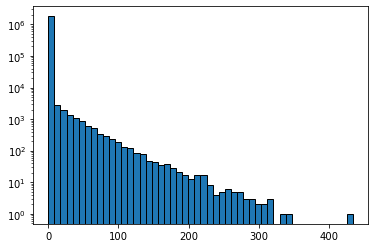

In [333]:
plt.hist(mdata[exp]['NP-lysate_enrich'],bins=50,edgecolor='black')
plt.yscale('log')

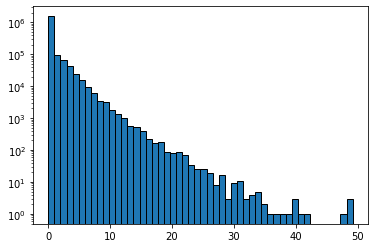

In [334]:
plt.hist(mdata[exp]['N-lysate_enrich'],bins=50,edgecolor='black')
plt.yscale('log')

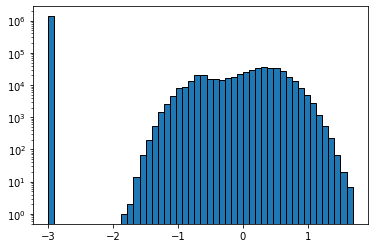

In [336]:
plt.hist(np.log10(mdata[exp]['N-lysate_enrich']+1e-3),bins=50,edgecolor='black')
plt.yscale('log')

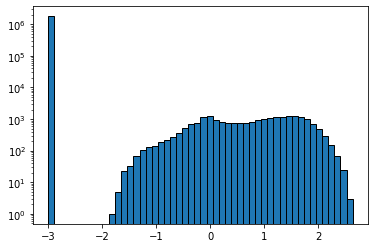

In [337]:
plt.hist(np.log10(mdata[exp]['NP-lysate_enrich']+1e-3),bins=50,edgecolor='black')
plt.yscale('log')

candidate
8 candidates from your Fn17 choice
['PSLYYNI_TRWRLYQAGQ',
'GINYYNI_TRWLGYQMWQ',
'PASRYNI_TRWRLARMWQ',
'VVNYYNI_TRGLLYQMWQ',
'PANRPNI_TSLRLYQMWQ',
'PANYSPI_TRWRLYQTSQ',
'GKNYYNI_TVWRLYQMWQ',
'PSLYYNI_TRWRLYQMVF',]
2. 2 candidates from your Fn22 choice.
['PNLWSRV_KRSFWSNLAG',
'PNLKTKV_KRSFWSLSAG']
3. 2 candidates from new Fn17 choice
 PSLYYNI_TRWRLYQAGQ
LSNYYNI_TRWRLYQLDQ
4. 2 candidates from new Fn22 choice
PNLWYLS_KRSFWSNVTG
PNLTSKV_KRSFRLNSAG
5. 1 candidates from ref seq Fn17
PANYYNI_**WRLYQMWQ
6. 1 candidate from your Fn17 de novo design.
PANGVNI_TRSRLYQAGQ

In [420]:
refdict['Fn17']

'PANYYNI_TRWRLYQMWQ'

In [29]:
candilist = ['PSLYYNI_TRWRLYQAGQ',
'GINYYNI_TRWLGYQMWQ',
'PASRYNI_TRWRLARMWQ',
'VVNYYNI_TRGLLYQMWQ',
'PANRPNI_TSLRLYQMWQ',
'PANYSPI_TRWRLYQTSQ',
'GKNYYNI_TVWRLYQMWQ',
'PSLYYNI_TRWRLYQMVF']+['PNLWSRV_KRSFWSNLAG',
'PNLKTKV_KRSFWSLSAG']+['PSLYYNI_TRWRLYQAGQ',
'LSNYYNI_TRWRLYQLDQ']+['PNLWYLS_KRSFWSNVTG',
'PNLTSKV_KRSFRLNSAG']+['PANYYNI_**WRLYQMWQ']+['PANGVNI_TRSRLYQAGQ']
#for exp in ['Fn17_2loop','Fn22_2loop']:
#    fdata[exp][fdata[exp]['seq'].isin(candilist)].sort_values(by='N-lysate_enrich',ascending=False).to_csv(exp+'_candidate.csv')

In [43]:
ccount = 0
ndata = pd.DataFrame(columns=['Loop1','Loop2','Input','N-lysate','NP-lysate','N-purified','preclear','Input_freq','N-lysate_freq','NP-lysate_freq','N-purified_freq','preclear_freq','N-lysate_enrich','NP-lysate_enrich','N-purified_enrich','preclear_enrich','seq','mutpos','N-lysate_predict2','NP-lysate_predict2','N-purified_predict2'])
for hit in candilist:
    ccount += 1
    for exp in explist:
        hdata = mdata[exp][mdata[exp]['seq'] == hit]
        if len(hdata) > 0:
            ndata = ndata.append(hdata)
ndata

Loop1       Loop2 Input N-lysate NP-lysate N-purified preclear  \
7062149   PSLYYNI  TRWRLYQAGQ     6      111         0         83       86   
2683078   GINYYNI  TRWLGYQMWQ    13      102         0        117        4   
9201078   PASRYNI  TRWRLARMWQ    12       45         1         98       16   
621463    VVNYYNI  TRGLLYQMWQ     6       95         0         47       26   
2963621   PANRPNI  TSLRLYQMWQ     7       86         0         54       24   
8210244   PANYSPI  TRWRLYQTSQ    11       54         0         84       18   
10336674  GKNYYNI  TVWRLYQMWQ    26      147         0        198       18   
2672473   PSLYYNI  TRWRLYQMVF    16       63         0        109       35   
2462844   PNLWSRV  KRSFWSNLAG     6       35         0         47       49   
123707    PNLKTKV  KRSFWSLSAG     7       17         0         38       25   
7062149   PSLYYNI  TRWRLYQAGQ     6      111         0         83       86   
4797169   LSNYYNI  TRWRLYQLDQ     6      109         0         68       52   
421768    PNLWYLS  KRSFWSNVTG     6       17         0         44       45   
574147    PNLTSKV  KRSFRLNSAG     8       29         0         50       28   
116640    PANYYNI  **WRLYQMWQ   109       39        85         16       91   
9421164   PANYYNI  **WRLYQMWQ    18        3         1          0       92   

            Input_freq  N-lysate_freq  NP-lysate_freq  ...  preclear_freq  \
7062149   1.781515e-07   4.305938e-06    0.000000e+00  ...   1.055887e-06   
2683078   3.859949e-07   3.956808e-06    0.000000e+00  ...   4.911103e-08   
9201078   3.563030e-07   1.745651e-06    1.103781e-07  ...   1.964441e-07   
621463    1.781515e-07   3.685262e-06    0.000000e+00  ...   3.192217e-07   
2963621   2.078434e-07   3.336132e-06    0.000000e+00  ...   2.946662e-07   
8210244   3.266111e-07   2.094781e-06    0.000000e+00  ...   2.209996e-07   
10336674  7.719898e-07   5.702459e-06    0.000000e+00  ...   2.209996e-07   
2672473   4.750706e-07   2.443911e-06    0.000000e+00  ...   4.297215e-07   
2462844   1.178783e-07   2.615254e-06    0.000000e+00  ...   8.822901e-07   
123707    1.375247e-07   1.270266e-06    0.000000e+00  ...   4.501480e-07   
7062149   1.781515e-07   4.305938e-06    0.000000e+00  ...   1.055887e-06   
4797169   1.781515e-07   4.228354e-06    0.000000e+00  ...   6.384434e-07   
421768    1.178783e-07   1.270266e-06    0.000000e+00  ...   8.102664e-07   
574147    1.571711e-07   2.166924e-06    0.000000e+00  ...   5.041658e-07   
116640    1.050439e-04   1.478937e-04    2.682793e-04  ...   1.137268e-04   
9421164   5.344545e-07   1.163767e-07    1.103781e-07  ...   1.129554e-06   

          N-lysate_enrich  NP-lysate_enrich  N-purified_enrich  \
7062149         50.476038          0.000000          50.318504   
2683078         21.407717          0.000000          32.737340   
9201078         10.231629          0.383763          29.706105   
621463          43.200213          0.000000          28.493611   
2963621         33.520767          0.000000          28.060577   
8210244         13.394133          0.000000          27.777137   
10336674        15.426149          0.000000          27.700826   
2672473         10.743211          0.000000          24.780348   
2462844         26.084393          0.000000          17.655952   
123707          10.859625          0.000000          12.235736   
7062149         50.476038          0.000000          50.318504   
4797169         49.566560          0.000000          41.224799   
421768          12.669562          0.000000          16.528976   
574147          16.209587          0.000000          14.087196   
116640           1.525490          2.671410           1.238962   
9421164          0.454739          0.255842           0.000000   

          preclear_enrich                 seq          mutpos  \
7062149          6.474260  PSLYYNI_TRWRLYQAGQ  [1, 2, 15, 16]   
2683078          0.138982  GINYYNI_TRWLGYQMWQ  [0, 1, 11, 12]   
9201078          0.602257  PASRYNI_TRWRLARMWQ  [2, 3, 13,

In [44]:
ndata.to_csv('candidate_list.csv')

In [51]:
for exp in explist:
    for lib in liblist:
        print(exp,lib,'number > 0',len(mdata[exp][mdata[exp][lib]>0]))

Fn22_1loop Input number > 0 6346
Fn22_1loop N-lysate number > 0 6339
Fn22_1loop NP-lysate number > 0 6329
Fn22_1loop N-purified number > 0 6333
Fn22_1loop preclear number > 0 6346
Fn17_1loop Input number > 0 6348
Fn17_1loop N-lysate number > 0 6338
Fn17_1loop NP-lysate number > 0 6301
Fn17_1loop N-purified number > 0 6325
Fn17_1loop preclear number > 0 6347
Fn22_2loop Input number > 0 1819505
Fn22_2loop N-lysate number > 0 455767
Fn22_2loop NP-lysate number > 0 23314
Fn22_2loop N-purified number > 0 609398
Fn22_2loop preclear number > 0 1532538
Fn17_2loop Input number > 0 1739024
Fn17_2loop N-lysate number > 0 563829
Fn17_2loop NP-lysate number > 0 145303
Fn17_2loop N-purified number > 0 432670
Fn17_2loop preclear number > 0 1389692


In [427]:
import sys
!conda install --yes --prefix {sys.prefix} biopython

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/Tianhao/Tools/anaconda3/envs/tensorflow

  added / updated specs:
    - biopython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    biopython-1.76             |   py37h516909a_0         2.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following NEW packages will be INSTALLED:

  biopython          conda-forge/linux-64::biopython-1.76-py37h516909a_0



biopython-1.76       | 2.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [429]:
import Bio

In [452]:
import sys
!conda install --yes --prefix {sys.prefix} distance

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/Tianhao/Tools/anaconda3/envs/tensorflow

  added / updated specs:
    - distance


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    distance-0.1.3             |             py_0          19 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          19 KB

The following NEW packages will be INSTALLED:

  distance           conda-forge/noarch::distance-0.1.3-py_0



distance-0.1.3       | 19 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


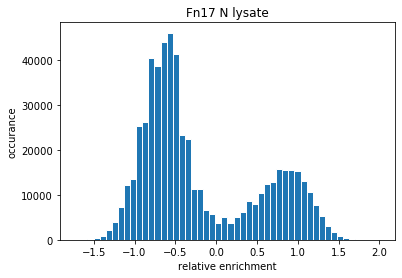

In [493]:
plt.figure()
plt.hist(np.log10(mdata['Fn17_2loop'][mdata['Fn17_2loop']['N-lysate_enrich']>0]['N-lysate_enrich']),bins=50,edgecolor='white')
plt.xlabel('relative enrichment')
plt.ylabel('occurance')
plt.title('Fn17 N lysate')
plt.savefig('distribution_Fn17_2loop_N_lysate.png',dpi=300)

In [469]:
for exp in explist:
    for lib in liblist[1:]:
        mdata[exp][lib+'_abs_enrich'] = mdata[exp][lib+'_freq']/mdata[exp]['Input_freq']

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Fn22_1loop


/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/scipy/stats/stats.py:339: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fn17_1loop
Fn22_2loop
Fn17_2loop


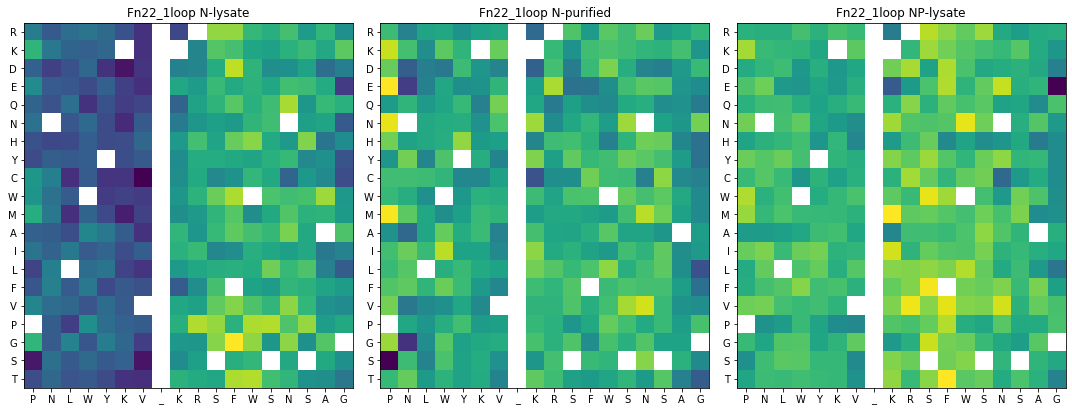

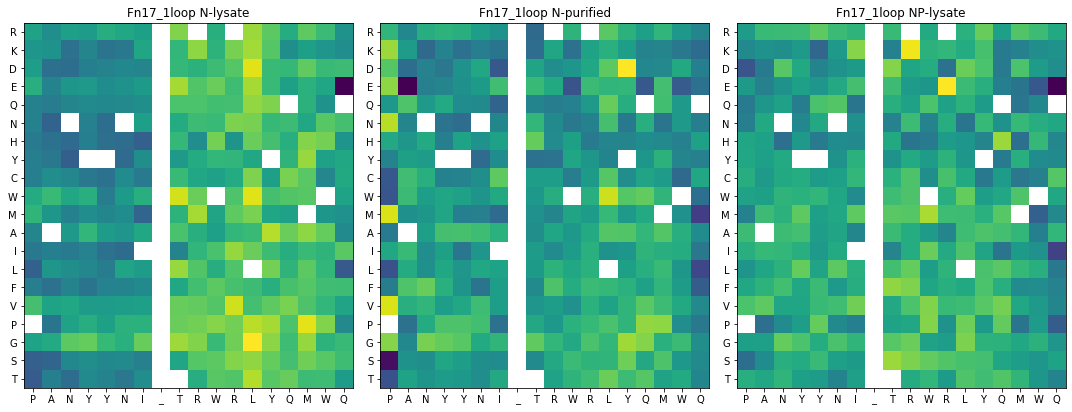

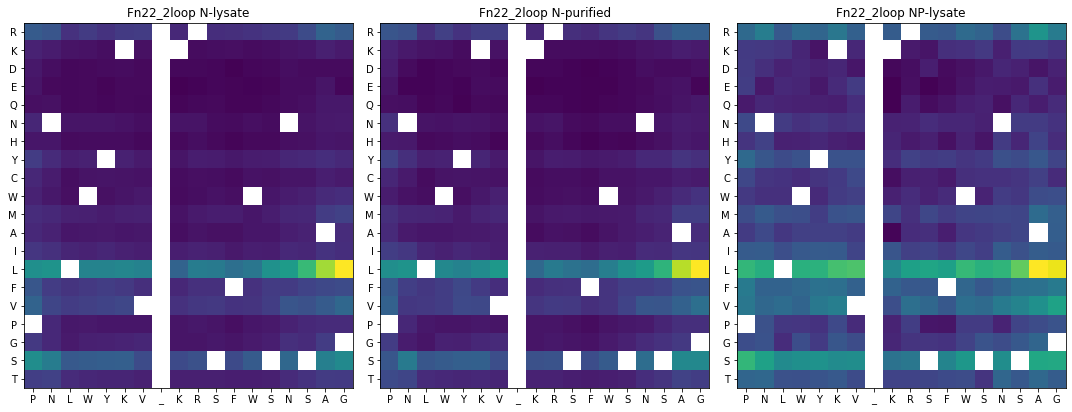

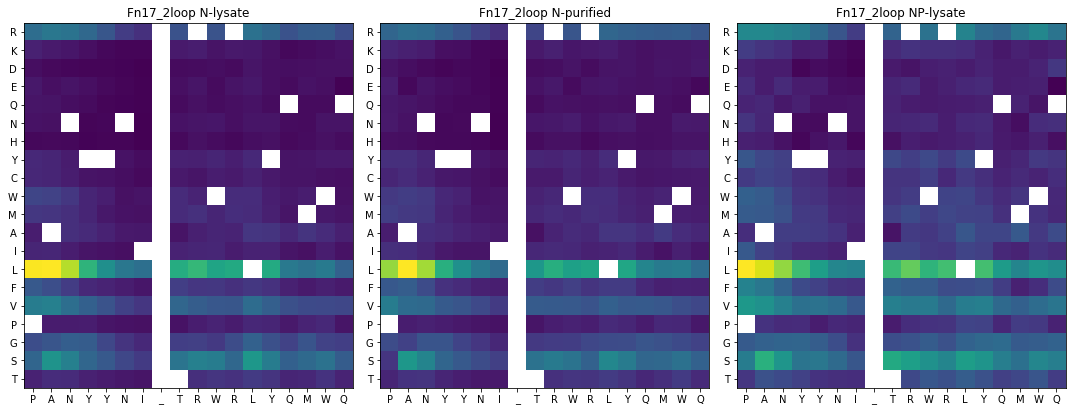

In [475]:
from scipy.stats import gmean
liblist = ['Input','N-lysate','N-purified','NP-lysate','preclear']
aalist = ['R','K','D','E','Q','N','H','Y','C','W','M','A','I','L','F','V','P','G','S','T']
heatdict_gmean = {}
for exp in explist:
    heatdict_gmean[exp] = {}
    print(exp)
    refseq = refdict[exp.rsplit('_')[0]]
    if '1loop' in exp: gmin = 1e-1
    if '2loop' in exp: gmin = 1e-3
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        #print(lib)
        ploti += 1
        heatarray = []
        for i in range(len(aalist)):
            heatarray.append([])
            for j in range(len(refseq)):
                heatarray[i].append(gmean(mdata[exp][(mdata[exp]['mutpos'].apply(lambda x: j in x)) & (mdata[exp]['seq'].apply(lambda x: x[j]==aalist[i]))][lib+'_enrich']+gmin))
        plt.subplot(1,3,ploti)
        plt.imshow(heatarray)
        plt.xticks(np.arange(len(refseq)),list(refseq))
        plt.yticks(np.arange(len(aalist)),aalist)
        plt.title(exp+' '+lib)
        heatdict_gmean[exp][lib] = heatarray
    plt.tight_layout()

/home/Tianhao/Tools/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN axis encountered
  # This is added back by InteractiveShellApp.init_path()


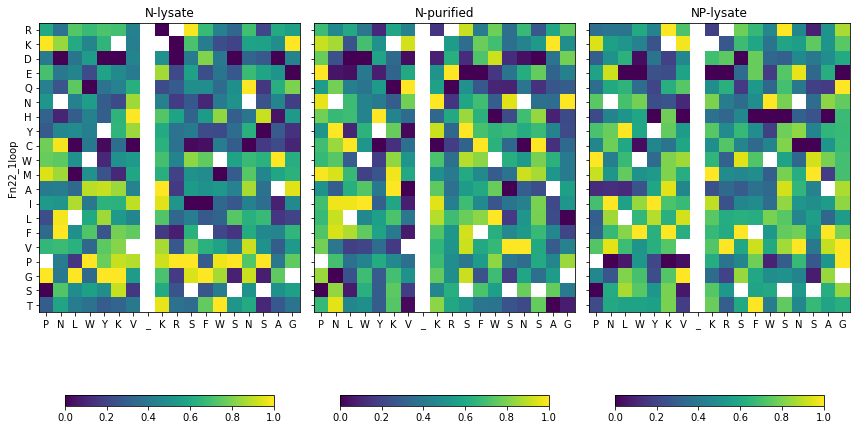

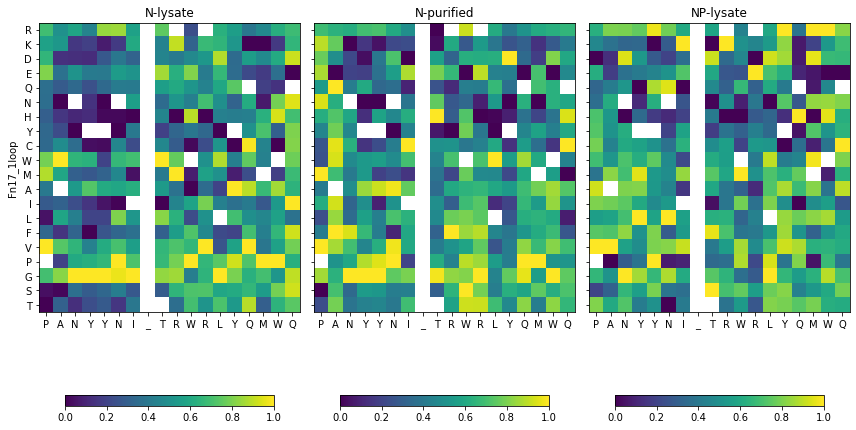

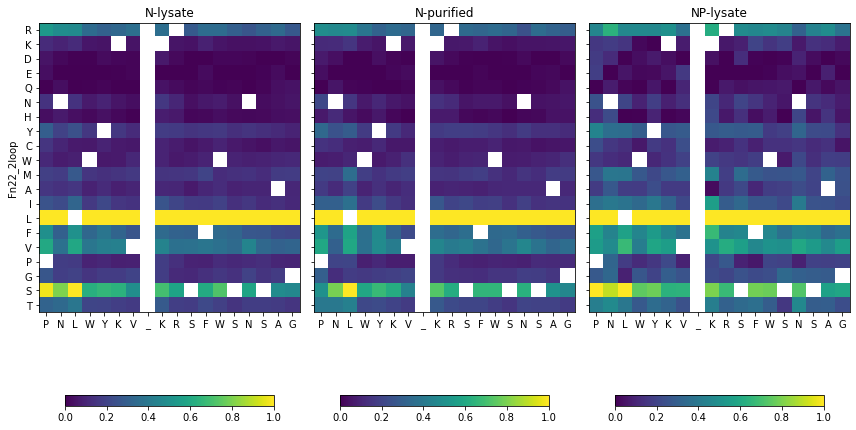

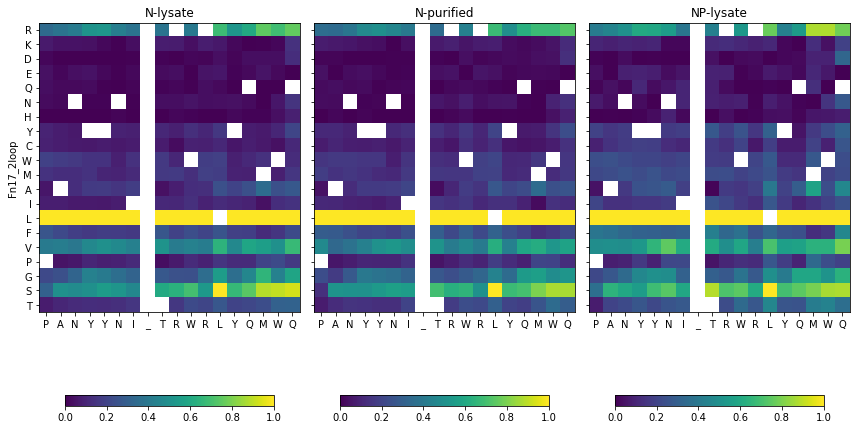

In [509]:
colordict = {'Fn22_1loop':(0.5,2.2),'Fn17_1loop':(0.7,1.6),'Fn22_2loop':(0,0.02),'Fn17_2loop':(0,0.02)}

    
for exp in explist:
    vmin,vmax = colordict[exp]
    refseq = refdict[exp.rsplit('_')[0]]
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,8))
    for ploti,ax in enumerate(axes.flat):
        #mask
        lib = liblist[ploti+1]
        norm_data = (heatdict_gmean[exp][lib] - np.nanmin(heatdict_gmean[exp][lib], axis=0)[ np.newaxis,:]) / (np.nanmax(heatdict_gmean[exp][lib], axis=0)[ np.newaxis,:] - np.nanmin(heatdict_gmean[exp][lib], axis=0)[ np.newaxis,:])
        im = ax.imshow(norm_data,cmap='viridis')
        ax.set_xticks(np.arange(len(refseq)))
        ax.set_xticklabels(list(refseq))
        ax.set_yticks(np.arange(len(aalist)))
        if ploti == 0:
            ax.set_yticklabels(aalist)
            ax.set_ylabel(exp)
        else:
            ax.set_yticklabels([])
        #bottom, top = ax.get_ylim()
        #ax.set_ylim(bottom + 0.5, top - 0.5)
        fig.colorbar(im, ax=ax,orientation='horizontal',shrink=0.8)
        ax.set_title(lib)
    #fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.savefig('heatmap_gmean_normalized_'+exp+'.png',dpi=300)

In [506]:
np.nanmin(heatdict_gmean[exp][lib], axis=1)[:, np.newaxis]

array([[0.00158234],
       [0.00130699],
       [0.00129492],
       [0.00128277],
       [0.00136187],
       [0.00133257],
       [0.00131001],
       [0.00143017],
       [0.00137314],
       [0.00144891],
       [0.00146284],
       [0.00136934],
       [0.00144635],
       [0.00202583],
       [0.00143572],
       [0.00174293],
       [0.00141298],
       [0.00152251],
       [0.00173326],
       [0.00150012]])

Fn22_1loop
Fn17_1loop
Fn22_2loop
Fn17_2loop


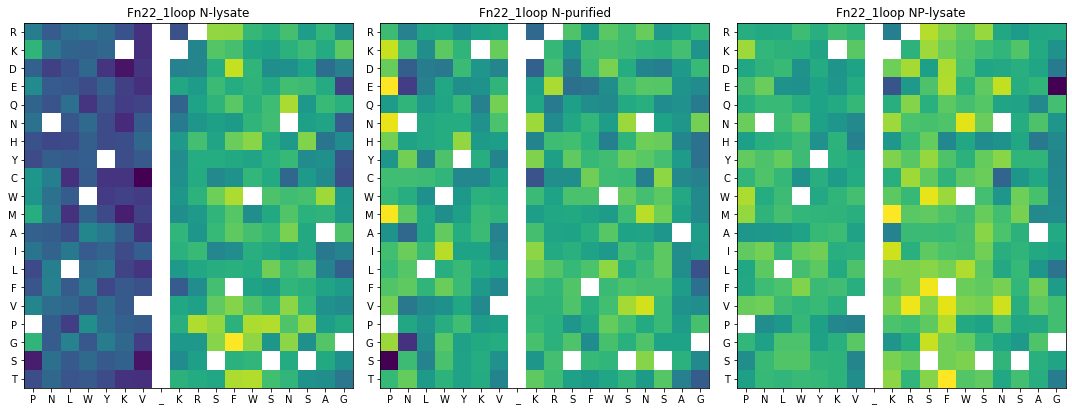

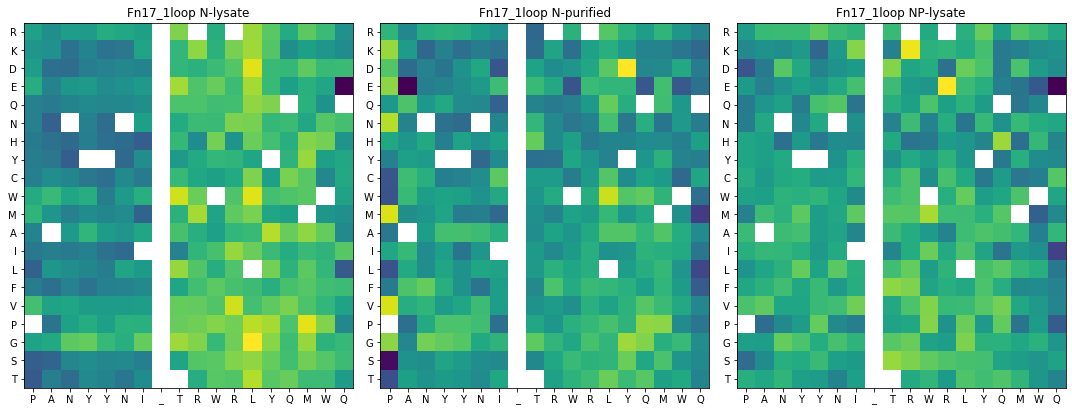

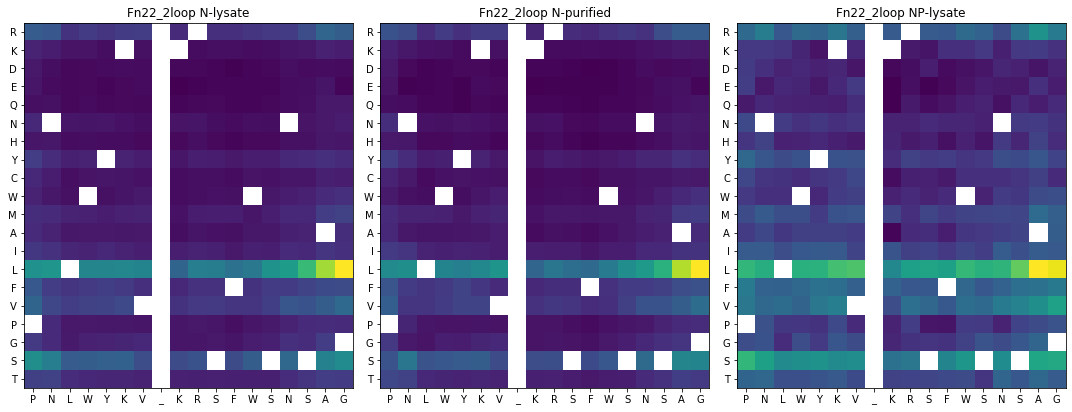

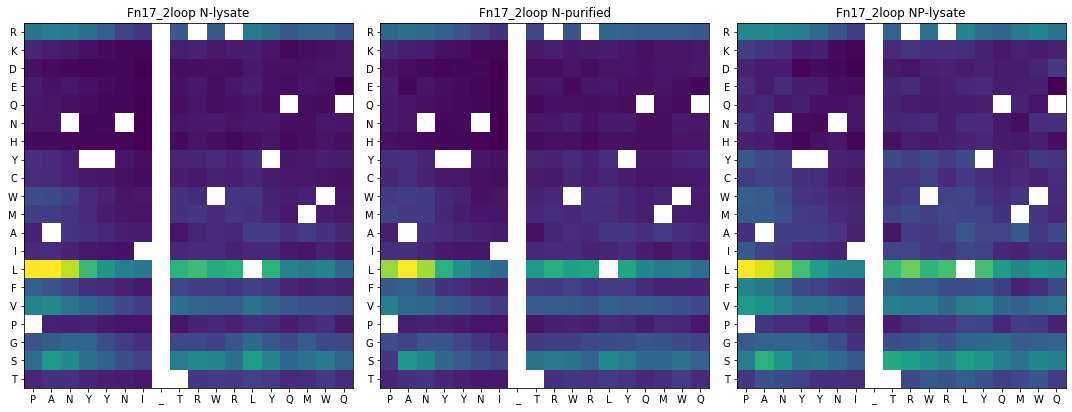

In [489]:
from scipy.stats import gmean
liblist = ['Input','N-lysate','N-purified','NP-lysate','preclear']
aalist = ['R','K','D','E','Q','N','H','Y','C','W','M','A','I','L','F','V','P','G','S','T']
heatdict_abs_gmean = {}
for exp in explist:
    heatdict_abs_gmean[exp] = {}
    print(exp)
    refseq = refdict[exp.rsplit('_')[0]]
    if '1loop' in exp: gmin = 1e-1
    if '2loop' in exp: gmin = 1e-3
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        #print(lib)
        ploti += 1
        heatarray = []
        for i in range(len(aalist)):
            heatarray.append([])
            for j in range(len(refseq)):
                heatarray[i].append(gmean(mdata[exp][(mdata[exp]['mutpos'].apply(lambda x: j in x)) & (mdata[exp]['seq'].apply(lambda x: x[j]==aalist[i]))][lib+'_abs_enrich']+gmin))
        plt.subplot(1,3,ploti)
        plt.imshow(heatarray)
        plt.xticks(np.arange(len(refseq)),list(refseq))
        plt.yticks(np.arange(len(aalist)),aalist)
        plt.title(exp+' '+lib)
        heatdict_abs_gmean[exp][lib] = heatarray
    plt.tight_layout()

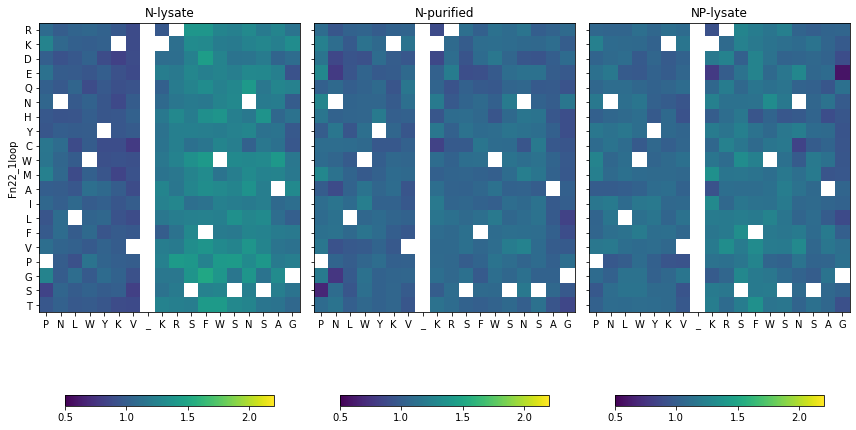

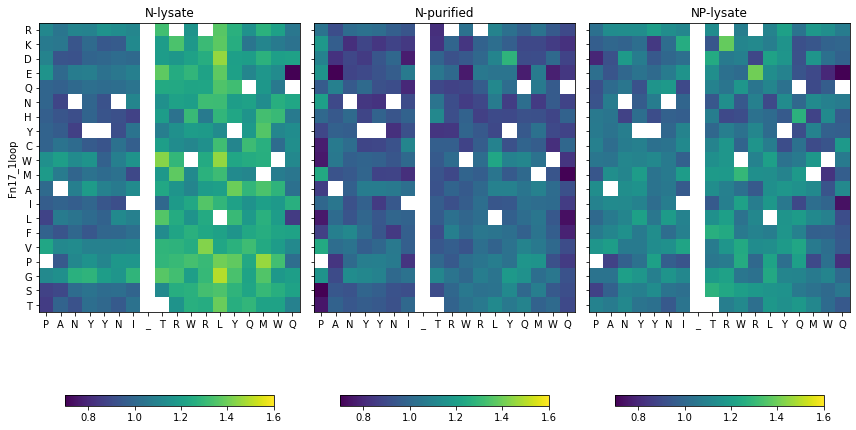

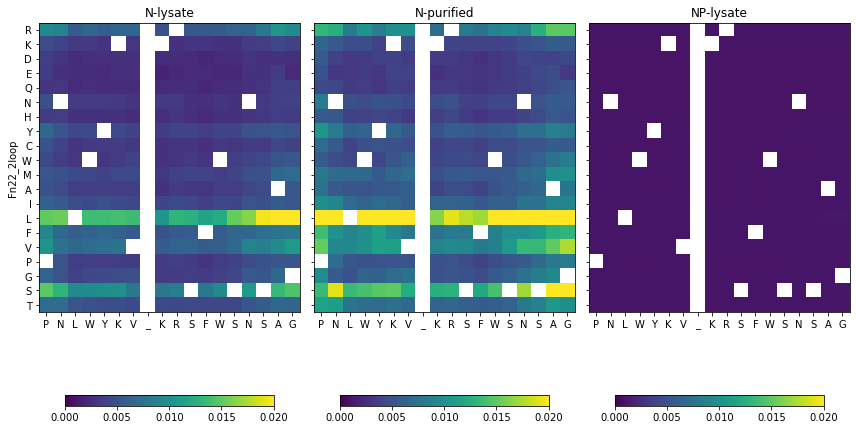

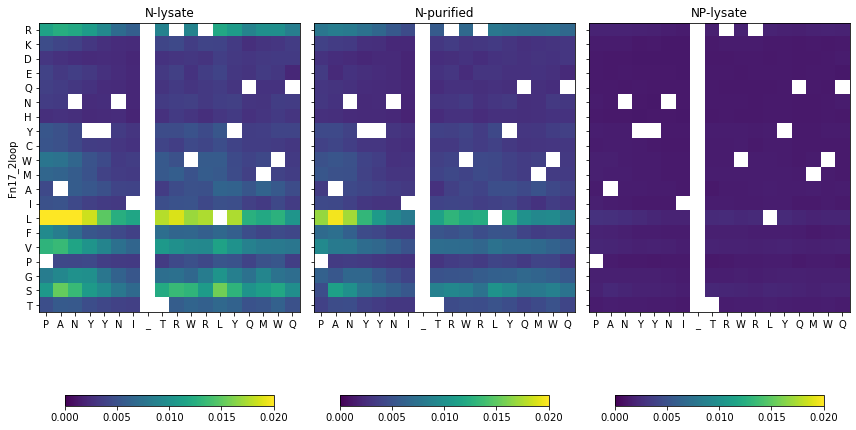

In [492]:
colordict = {'Fn22_1loop':(0.5,2.2),'Fn17_1loop':(0.7,1.6),'Fn22_2loop':(0,0.02),'Fn17_2loop':(0,0.02)}

    
for exp in explist:
    vmin,vmax = colordict[exp]
    refseq = refdict[exp.rsplit('_')[0]]
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,8))
    for ploti,ax in enumerate(axes.flat):
        #mask
        lib = liblist[ploti+1]
        im = ax.imshow(heatdict_abs_gmean[exp][lib],cmap='viridis',vmin=vmin,vmax=vmax)
        ax.set_xticks(np.arange(len(refseq)))
        ax.set_xticklabels(list(refseq))
        ax.set_yticks(np.arange(len(aalist)))
        if ploti == 0:
            ax.set_yticklabels(aalist)
            ax.set_ylabel(exp)
        else:
            ax.set_yticklabels([])
        #bottom, top = ax.get_ylim()
        #ax.set_ylim(bottom + 0.5, top - 0.5)
        fig.colorbar(im, ax=ax,orientation='horizontal',shrink=0.8)
        ax.set_title(lib)
    #fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.savefig('heatmap_abs_gmean_normalized_'+exp+'.png',dpi=300)

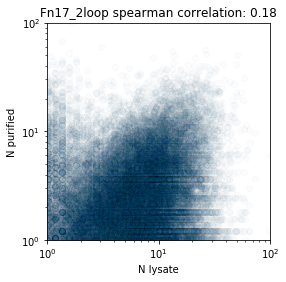

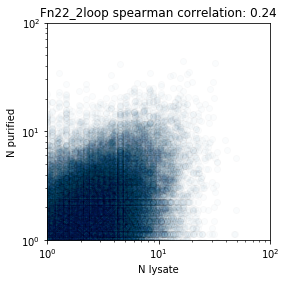

In [502]:

for exp in ['Fn17_2loop','Fn22_2loop']:
    plt.figure(figsize=(4,4))
    plt.scatter(mdata[exp]['N-lysate_enrich'],mdata[exp]['N-purified_enrich'],alpha=0.02,edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1,1e2])
    plt.ylim([1,1e2])
    plt.xlabel('N lysate')
    plt.ylabel('N purified')
    rho = spearmanr(mdata[exp]['N-lysate_enrich'][(mdata[exp]['N-lysate_enrich']>1) & (mdata[exp]['N-purified_enrich']>1)],mdata[exp]['N-purified_enrich'][(mdata[exp]['N-lysate_enrich']>1) & (mdata[exp]['N-purified_enrich']>1)])[0]
    plt.title(exp+' spearman correlation: '+str(round(rho,2)))
    plt.savefig('enrichment_correlation_'+exp+'.png')

In [52]:
exp = 'Fn22_2loop'
spearmanr(mdata[exp]['N-lysate_enrich'][(mdata[exp]['N-lysate_enrich']>1) & (mdata[exp]['N-purified_enrich']>1)],mdata[exp]['N-purified_enrich'][(mdata[exp]['N-lysate_enrich']>1) & (mdata[exp]['N-purified_enrich']>1)])

SpearmanrResult(correlation=0.24086477191945713, pvalue=0.0)

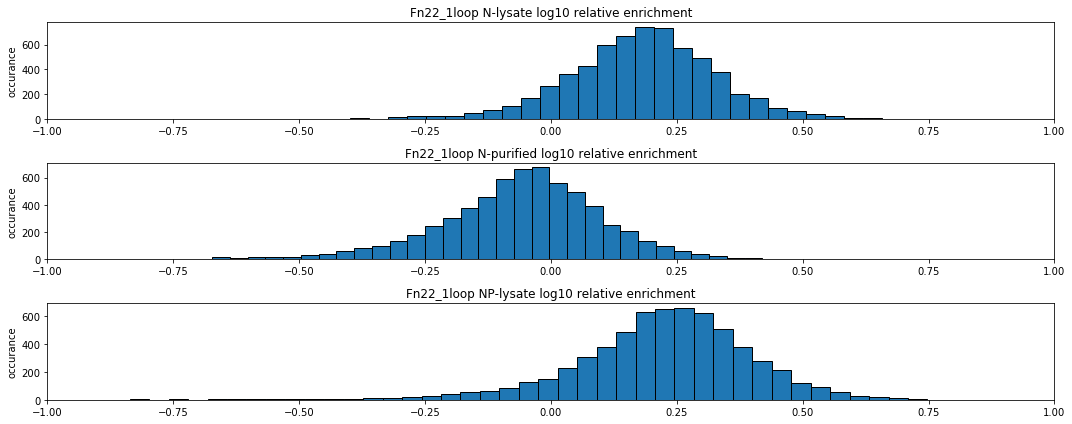

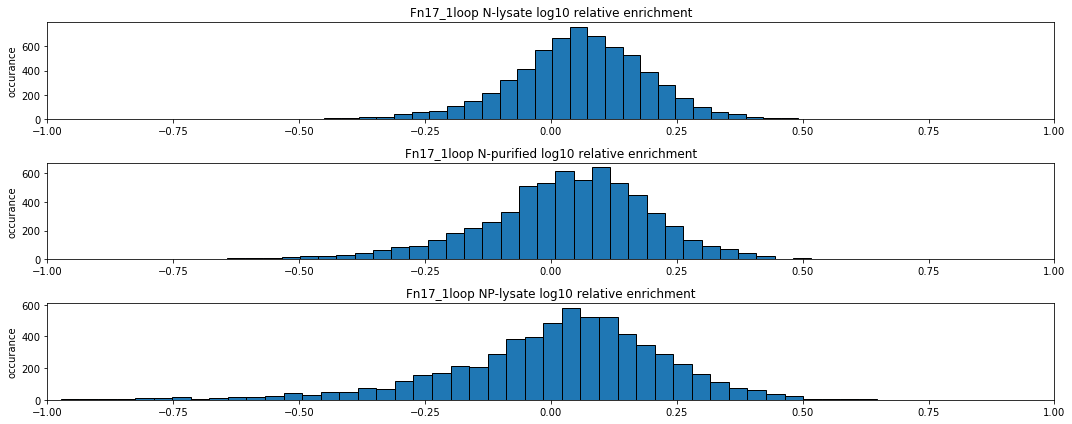

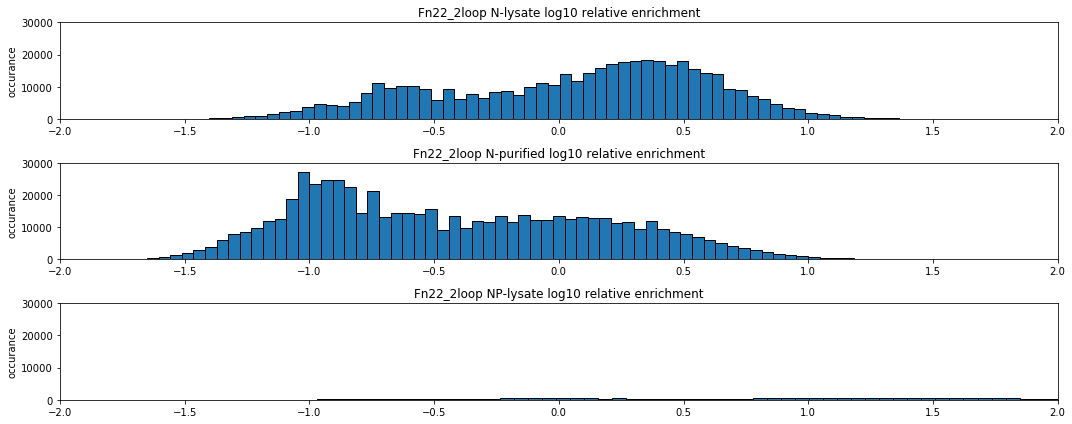

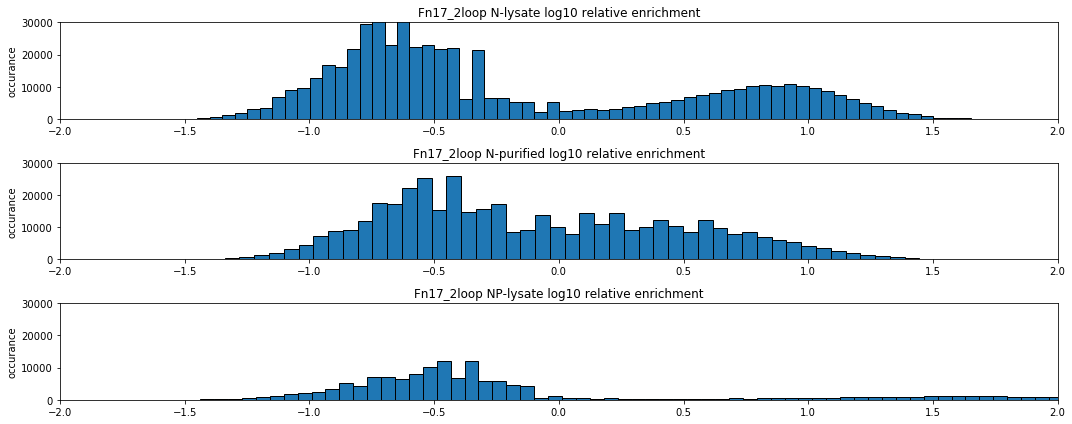

In [515]:
for exp in explist:
    plt.figure(figsize=(15,6))
    ploti = 0
    for lib in liblist[1:-1]:
        ploti += 1
        plt.subplot(3,1,ploti)
        plt.hist(np.log10(mdata[exp][lib+'_enrich']+1e-3),bins=100,edgecolor='black')
        plt.title(exp+' '+lib+' log10 relative enrichment')
        plt.ylabel('occurance')
        if '1loop' in exp:
            plt.xlim([-1,1])
        else:
            plt.xlim([-2,2])
            plt.ylim([0,30000])
        #plt.yscale('log')
    plt.tight_layout()
    plt.savefig('enrichment_distribution_'+exp+'.png')

In [573]:
import pydotplus as pydot
#keras.utils.pydot = pydot
#from tensorflow.keras.utils import model_to_dot
#import pydotplus as pydot
pydot.Dot.create(pydot.Dot())
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=False, show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=300)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [560]:
model

In [562]:

!conda install --yes --prefix {sys.prefix} pydot_ng

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - pydot_ng

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://conda.anaconda.org/bioconda/linux-64
  - https://conda.anaconda.org/bioconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [519]:
import sys
!conda install --yes --prefix {sys.prefix} graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [74]:
for exp in explist:
    mdata[exp].to_csv('final_data_'+exp+'.csv')